# 3nm Nanosheet Figure of Merit Prediction

Created on Jan 4, 2021

@author: Haoqing Xu @ICAC, IMECAS

This project focus on 3nm nanosheet FoM prediction with Multiple Layer Perceptron

In [1]:
import time
start = time.clock()

# Import packages

In [2]:
import torch
import math
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data Loading

In [3]:
data = np.loadtxt("data_partical.csv",dtype="float",delimiter=',', skiprows=1, usecols=None, unpack=False)
print('Data shape:', data.shape)
print(data[:,:])

Data shape: (2178, 9)
[[  1.00000000e-08   4.00000000e-09   0.00000000e+00 ...,   7.63000000e-02
    5.45000000e-05   3.07000000e-09]
 [  1.00000000e-08   4.00000000e-09   0.00000000e+00 ...,   7.16000000e-02
    5.34000000e-05   6.53000000e-10]
 [  1.00000000e-08   4.00000000e-09   0.00000000e+00 ...,   6.76000000e-02
    5.12000000e-05   2.35000000e-10]
 ..., 
 [  2.50000000e-08   7.00000000e-09   1.00000000e-09 ...,   7.48000000e-02
    1.30000000e-04   3.60000000e-08]
 [  2.50000000e-08   7.00000000e-09   1.00000000e-09 ...,   7.07000000e-02
    1.26000000e-04   1.27000000e-08]
 [  2.50000000e-08   7.00000000e-09   1.00000000e-09 ...,   6.73000000e-02
    1.23000000e-04   6.23000000e-09]]


## Pre-processing

X(Column 1-5): nanowireWidth  nanowireHeight  sheetRadius  spacerLength  gateLength

Y(Column 6-9): V_th  SS  I_on  I_off

In [4]:
print(data[:, 8])
data[:, 8] = -np.log10(data[:, 8])
print(data[:,8])#-log(I_off)

[  3.07000000e-09   6.53000000e-10   2.35000000e-10 ...,   3.60000000e-08
   1.27000000e-08   6.23000000e-09]
[ 8.51286162  9.18508682  9.62893214 ...,  7.4436975   7.89619628
  8.20551195]


In [5]:
X, Y = data[:,:5], data[:,5:]
#print('origin\n', Y)

#Y[:, 4:6] = -np.log10(Y[:, 4:6]) #-log(I_on, I_off)

ss_x, ss_y = StandardScaler(), StandardScaler()
X = ss_x.fit_transform(X)
Y = ss_y.fit_transform(Y)
print('Scaled X\n', X)
print('Scaled Y\n', Y)

#X2 = ss_x.inverse_transform(X1)
#Y = StandardScaler().fit_transform(Y)
#print('inverse_scaler\n', X2)

Scaled X
 [[-1.28733244 -1.34877011 -1.20928508 -1.40880498 -1.52246599]
 [-1.28733244 -1.34877011 -1.20928508 -1.40880498 -1.08621669]
 [-1.28733244 -1.34877011 -1.20928508 -1.40880498 -0.64996739]
 ..., 
 [ 1.50067888  0.82778309  0.01517931  0.72398736 -0.64996739]
 [ 1.50067888  0.82778309  0.01517931  0.72398736 -0.21371809]
 [ 1.50067888  0.82778309  0.01517931  0.72398736  0.22253121]]
Scaled Y
 [[ 0.17799441  0.68760382 -1.11657429  0.02702845]
 [ 0.73427159  0.41350069 -1.16104681  0.61339655]
 [ 1.07312064  0.18022143 -1.24999185  1.00055362]
 ..., 
 [-0.94147813  0.6001241   1.93585765 -0.90558126]
 [-0.48840872  0.36101286  1.7741394  -0.51087595]
 [-0.21309387  0.16272549  1.65285071 -0.2410663 ]]


ATTENTION:  'ss = StandardScaler()' is necessary due to inverse_transform share u and s with fit_transform

Split trainSet and testset

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1742, 5) (436, 5) (1742, 4) (436, 4)


In [7]:
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)

print('Shape and Type of x_train:', x_train.shape, x_train.dtype)
print('Shape and Type of y_train:', y_train.shape, y_train.dtype)
print('Shape and Type of x_test:', x_test.shape, x_test.dtype)
print('Shape and Type of y_test:', y_test.shape, y_test.dtype)

Shape and Type of x_train: torch.Size([1742, 5]) torch.float64
Shape and Type of y_train: torch.Size([1742, 4]) torch.float64
Shape and Type of x_test: torch.Size([436, 5]) torch.float64
Shape and Type of y_test: torch.Size([436, 4]) torch.float64


In [8]:
x_train = Variable(x_train)
y_train = Variable(y_train)
x_test = Variable(x_test)
y_test = Variable(y_test)

In [9]:
class Dataset(Dataset):
    def __init__(self,x,y):
        self.x=x
        self.y=y

    def __getitem__(self,index):
        return self.x[index], self.y[index]
  
    def __len__(self):
        return len(self.x)

In [10]:
dataset_train = Dataset(x_train, y_train)
dataset_test = Dataset(x_test, y_test)

print(dataset_train.x.shape, dataset_train.y.shape, dataset_test.x.shape, dataset_test.y.shape)

torch.Size([1742, 5]) torch.Size([1742, 4]) torch.Size([436, 5]) torch.Size([436, 4])


# Neural Network Building

Define the Network Structure

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(5, 100, bias = True)
        self.fc2 = nn.Linear(100, 100, bias = True)
        self.fc3 = nn.Linear(100, 100, bias = True)
        self.fc4 = nn.Linear(100, 100, bias = True)
        self.fc5 = nn.Linear(100, 4, bias = True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        out = self.fc5(out)
        return out

# Hyper-Parameter and Training Settings 

In [12]:
BATCH_SIZE = 16
EPOCHS = 25000
LR = 5e-6

model = MLP()

#optimizer = optim.RMSprop(model.parameters(), lr=LR)
#optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [13]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#For multiple GPU usage 
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids = [0,1]).cuda()

model = model.to(DEVICE)
print(model)

Let's use 2 GPUs!
DataParallel(
  (module): MLP(
    (fc1): Linear(in_features=5, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=100, bias=True)
    (fc5): Linear(in_features=100, out_features=4, bias=True)
    (sigmoid): Sigmoid()
  )
)


# Training and Test

In [14]:
train_loader= torch.utils.data.DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader= torch.utils.data.DataLoader(dataset=dataset_test, batch_size=dataset_test.y.shape[0], shuffle=True)

In [15]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    #loss = torch.zeros(1)
    #loss.to(DEVICE)
    train_loss = 0
    for inputs, labels in train_loader:
        inputs = Variable(inputs.float()).to(DEVICE)
        labels = Variable(labels.float()).to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.mse_loss(outputs, labels)
        
        train_loss += F.mse_loss(outputs, labels, reduction='sum').item()
        #loss_func = nn.L1Loss()
        #loss = loss_func(outputs, labels)
        # loss = -(labels * torch.log(output)+ (1-labels) * torch.log(1-output)).mean()
        loss.backward()
        optimizer.step()
    #output = (output>0.5).float()
    #correct = (output == labels).float().sum()
    #print("Epoch {}/{}, train_loss:{:.4f}, ".format(epoch+1,EPOCHS,loss.item()), end='')
    print("Epoch {}/{}, train_loss:{:.4f}, ".format(epoch+1,EPOCHS,train_loss), end='')
    #return loss.item()
    return train_loss

In [16]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = Variable(inputs.float()).to(DEVICE)
            labels = Variable(labels.float()).to(DEVICE)
            outputs = model(inputs)
            test_loss += F.mse_loss(outputs, labels, reduction='sum').item()
            #pred = torch.tensor([[1] if num[0] >= 0.5 else [0] for num in output]).to(device)
            #correct += (pred == target.long()).sum().item()
        print('test_loss: {:.4f}'.format(test_loss))
    return test_loss

In [17]:
loss_plot = np.empty([EPOCHS, 3])
for epoch in range(EPOCHS):
    loss_plot[epoch, 0] = epoch
    loss_plot[epoch, 1] = train(model, DEVICE, train_loader, optimizer, epoch)
    loss_plot[epoch, 2] = test(model, DEVICE, test_loader)

Epoch 1/25000, train_loss:7768.0329, test_loss: 1742.5786
Epoch 2/25000, train_loss:7646.0057, test_loss: 1717.1399
Epoch 3/25000, train_loss:7541.6912, test_loss: 1696.1757
Epoch 4/25000, train_loss:7456.0190, test_loss: 1678.7272
Epoch 5/25000, train_loss:7384.3768, test_loss: 1664.9272
Epoch 6/25000, train_loss:7325.6101, test_loss: 1653.2632
Epoch 7/25000, train_loss:7276.7495, test_loss: 1644.1711
Epoch 8/25000, train_loss:7237.3143, test_loss: 1636.9954
Epoch 9/25000, train_loss:7205.0097, test_loss: 1631.4397
Epoch 10/25000, train_loss:7179.4567, test_loss: 1627.1819
Epoch 11/25000, train_loss:7158.9101, test_loss: 1623.9769
Epoch 12/25000, train_loss:7142.9251, test_loss: 1621.5042
Epoch 13/25000, train_loss:7130.5371, test_loss: 1619.7529
Epoch 14/25000, train_loss:7120.8170, test_loss: 1618.6433
Epoch 15/25000, train_loss:7113.4400, test_loss: 1617.7936
Epoch 16/25000, train_loss:7107.6359, test_loss: 1617.2825
Epoch 17/25000, train_loss:7103.5776, test_loss: 1616.9932
Epoch 

Epoch 140/25000, train_loss:7008.4986, test_loss: 1598.3511
Epoch 141/25000, train_loss:7006.3205, test_loss: 1597.9048
Epoch 142/25000, train_loss:7004.1188, test_loss: 1597.2557
Epoch 143/25000, train_loss:7001.4455, test_loss: 1596.8091
Epoch 144/25000, train_loss:6999.5042, test_loss: 1595.9440
Epoch 145/25000, train_loss:6996.7121, test_loss: 1595.4180
Epoch 146/25000, train_loss:6994.1441, test_loss: 1594.7896
Epoch 147/25000, train_loss:6991.8668, test_loss: 1594.5085
Epoch 148/25000, train_loss:6989.2257, test_loss: 1593.6052
Epoch 149/25000, train_loss:6986.2814, test_loss: 1592.9993
Epoch 150/25000, train_loss:6983.3741, test_loss: 1592.3105
Epoch 151/25000, train_loss:6980.5981, test_loss: 1591.7505
Epoch 152/25000, train_loss:6977.6055, test_loss: 1590.9011
Epoch 153/25000, train_loss:6974.6621, test_loss: 1590.1484
Epoch 154/25000, train_loss:6971.6579, test_loss: 1589.5251
Epoch 155/25000, train_loss:6968.4938, test_loss: 1588.5778
Epoch 156/25000, train_loss:6964.9391, t

Epoch 277/25000, train_loss:4574.9430, test_loss: 1020.3491
Epoch 278/25000, train_loss:4541.4277, test_loss: 1012.8359
Epoch 279/25000, train_loss:4507.8187, test_loss: 1005.2809
Epoch 280/25000, train_loss:4474.9879, test_loss: 997.8409
Epoch 281/25000, train_loss:4442.7252, test_loss: 990.6644
Epoch 282/25000, train_loss:4410.5368, test_loss: 983.5417
Epoch 283/25000, train_loss:4379.0019, test_loss: 976.4720
Epoch 284/25000, train_loss:4348.3595, test_loss: 969.5255
Epoch 285/25000, train_loss:4318.1793, test_loss: 962.9741
Epoch 286/25000, train_loss:4288.7725, test_loss: 956.4033
Epoch 287/25000, train_loss:4259.4926, test_loss: 950.0549
Epoch 288/25000, train_loss:4231.4041, test_loss: 943.8121
Epoch 289/25000, train_loss:4203.8346, test_loss: 937.8610
Epoch 290/25000, train_loss:4177.1088, test_loss: 931.9755
Epoch 291/25000, train_loss:4151.0615, test_loss: 926.2825
Epoch 292/25000, train_loss:4125.7666, test_loss: 920.8275
Epoch 293/25000, train_loss:4100.8600, test_loss: 915

Epoch 416/25000, train_loss:3214.3907, test_loss: 736.6600
Epoch 417/25000, train_loss:3211.4074, test_loss: 736.1115
Epoch 418/25000, train_loss:3209.1165, test_loss: 735.5784
Epoch 419/25000, train_loss:3206.4719, test_loss: 734.8610
Epoch 420/25000, train_loss:3203.8082, test_loss: 734.3827
Epoch 421/25000, train_loss:3201.2290, test_loss: 734.0620
Epoch 422/25000, train_loss:3198.6467, test_loss: 733.6741
Epoch 423/25000, train_loss:3196.0970, test_loss: 733.1223
Epoch 424/25000, train_loss:3193.6771, test_loss: 732.9518
Epoch 425/25000, train_loss:3190.7265, test_loss: 732.0986
Epoch 426/25000, train_loss:3188.2876, test_loss: 731.6375
Epoch 427/25000, train_loss:3185.7720, test_loss: 731.2815
Epoch 428/25000, train_loss:3183.5097, test_loss: 730.4847
Epoch 429/25000, train_loss:3180.7223, test_loss: 730.1415
Epoch 430/25000, train_loss:3178.1035, test_loss: 729.4413
Epoch 431/25000, train_loss:3175.5948, test_loss: 729.2281
Epoch 432/25000, train_loss:3173.1410, test_loss: 728.40

Epoch 555/25000, train_loss:2800.5838, test_loss: 647.4507
Epoch 556/25000, train_loss:2796.8197, test_loss: 646.4725
Epoch 557/25000, train_loss:2792.8671, test_loss: 645.5261
Epoch 558/25000, train_loss:2788.6612, test_loss: 644.4504
Epoch 559/25000, train_loss:2784.8648, test_loss: 643.6903
Epoch 560/25000, train_loss:2780.7507, test_loss: 642.5867
Epoch 561/25000, train_loss:2776.8730, test_loss: 641.7692
Epoch 562/25000, train_loss:2772.7104, test_loss: 640.7233
Epoch 563/25000, train_loss:2768.8415, test_loss: 639.6754
Epoch 564/25000, train_loss:2764.3838, test_loss: 638.7330
Epoch 565/25000, train_loss:2760.2495, test_loss: 637.7706
Epoch 566/25000, train_loss:2756.1976, test_loss: 636.8329
Epoch 567/25000, train_loss:2751.9251, test_loss: 635.9099
Epoch 568/25000, train_loss:2747.8300, test_loss: 634.7213
Epoch 569/25000, train_loss:2743.4923, test_loss: 633.9455
Epoch 570/25000, train_loss:2739.3538, test_loss: 632.7246
Epoch 571/25000, train_loss:2735.2154, test_loss: 631.73

Epoch 694/25000, train_loss:2076.0644, test_loss: 469.2805
Epoch 695/25000, train_loss:2070.3822, test_loss: 467.9089
Epoch 696/25000, train_loss:2064.8110, test_loss: 466.6890
Epoch 697/25000, train_loss:2059.1170, test_loss: 464.9757
Epoch 698/25000, train_loss:2053.5163, test_loss: 463.7504
Epoch 699/25000, train_loss:2048.1656, test_loss: 462.4332
Epoch 700/25000, train_loss:2042.3706, test_loss: 460.9195
Epoch 701/25000, train_loss:2036.9356, test_loss: 459.3991
Epoch 702/25000, train_loss:2031.3948, test_loss: 457.9831
Epoch 703/25000, train_loss:2025.9733, test_loss: 456.7647
Epoch 704/25000, train_loss:2020.6471, test_loss: 455.2961
Epoch 705/25000, train_loss:2015.1966, test_loss: 454.1538
Epoch 706/25000, train_loss:2009.7695, test_loss: 452.7390
Epoch 707/25000, train_loss:2004.6801, test_loss: 451.6226
Epoch 708/25000, train_loss:1999.0094, test_loss: 449.8323
Epoch 709/25000, train_loss:1993.7842, test_loss: 448.5659
Epoch 710/25000, train_loss:1988.4310, test_loss: 447.09

Epoch 833/25000, train_loss:1581.7058, test_loss: 346.9547
Epoch 834/25000, train_loss:1579.5047, test_loss: 346.5529
Epoch 835/25000, train_loss:1577.4534, test_loss: 346.0529
Epoch 836/25000, train_loss:1575.9920, test_loss: 345.6664
Epoch 837/25000, train_loss:1573.6041, test_loss: 345.1963
Epoch 838/25000, train_loss:1571.5398, test_loss: 345.0041
Epoch 839/25000, train_loss:1569.6122, test_loss: 344.4734
Epoch 840/25000, train_loss:1567.7772, test_loss: 343.9805
Epoch 841/25000, train_loss:1565.6070, test_loss: 343.4089
Epoch 842/25000, train_loss:1563.9930, test_loss: 342.9697
Epoch 843/25000, train_loss:1562.0601, test_loss: 342.3110
Epoch 844/25000, train_loss:1559.7658, test_loss: 342.0289
Epoch 845/25000, train_loss:1557.9329, test_loss: 341.8811
Epoch 846/25000, train_loss:1556.1743, test_loss: 341.5643
Epoch 847/25000, train_loss:1554.1585, test_loss: 340.8619
Epoch 848/25000, train_loss:1552.5476, test_loss: 340.2265
Epoch 849/25000, train_loss:1550.7139, test_loss: 339.69

Epoch 972/25000, train_loss:1359.1901, test_loss: 299.5176
Epoch 973/25000, train_loss:1358.4410, test_loss: 298.8103
Epoch 974/25000, train_loss:1357.0301, test_loss: 299.0730
Epoch 975/25000, train_loss:1355.4663, test_loss: 298.5264
Epoch 976/25000, train_loss:1354.0289, test_loss: 298.2826
Epoch 977/25000, train_loss:1353.0815, test_loss: 297.9383
Epoch 978/25000, train_loss:1351.4188, test_loss: 297.9834
Epoch 979/25000, train_loss:1350.4647, test_loss: 297.5199
Epoch 980/25000, train_loss:1349.9071, test_loss: 297.4659
Epoch 981/25000, train_loss:1348.2758, test_loss: 297.2534
Epoch 982/25000, train_loss:1346.7451, test_loss: 296.7012
Epoch 983/25000, train_loss:1345.4730, test_loss: 296.4747
Epoch 984/25000, train_loss:1344.3957, test_loss: 296.2590
Epoch 985/25000, train_loss:1342.9264, test_loss: 295.8013
Epoch 986/25000, train_loss:1341.8459, test_loss: 295.9352
Epoch 987/25000, train_loss:1340.5394, test_loss: 295.3223
Epoch 988/25000, train_loss:1339.3864, test_loss: 295.50

Epoch 1110/25000, train_loss:1218.9692, test_loss: 268.5360
Epoch 1111/25000, train_loss:1217.9158, test_loss: 268.6890
Epoch 1112/25000, train_loss:1217.7364, test_loss: 268.7654
Epoch 1113/25000, train_loss:1216.6224, test_loss: 268.0593
Epoch 1114/25000, train_loss:1215.6730, test_loss: 267.8467
Epoch 1115/25000, train_loss:1214.7032, test_loss: 267.6989
Epoch 1116/25000, train_loss:1214.0540, test_loss: 267.6699
Epoch 1117/25000, train_loss:1213.3677, test_loss: 267.4343
Epoch 1118/25000, train_loss:1212.6988, test_loss: 267.2154
Epoch 1119/25000, train_loss:1211.9964, test_loss: 267.3136
Epoch 1120/25000, train_loss:1211.2133, test_loss: 266.6931
Epoch 1121/25000, train_loss:1210.2754, test_loss: 266.9695
Epoch 1122/25000, train_loss:1209.5007, test_loss: 266.5760
Epoch 1123/25000, train_loss:1208.9572, test_loss: 266.2751
Epoch 1124/25000, train_loss:1207.9187, test_loss: 266.2465
Epoch 1125/25000, train_loss:1207.5128, test_loss: 265.9940
Epoch 1126/25000, train_loss:1206.8264, 

Epoch 1247/25000, train_loss:1132.6877, test_loss: 248.4942
Epoch 1248/25000, train_loss:1132.4979, test_loss: 248.0500
Epoch 1249/25000, train_loss:1131.9222, test_loss: 247.9740
Epoch 1250/25000, train_loss:1131.0675, test_loss: 247.8298
Epoch 1251/25000, train_loss:1130.9566, test_loss: 247.9678
Epoch 1252/25000, train_loss:1130.1451, test_loss: 247.8123
Epoch 1253/25000, train_loss:1129.7551, test_loss: 247.7503
Epoch 1254/25000, train_loss:1129.3574, test_loss: 247.6292
Epoch 1255/25000, train_loss:1128.7125, test_loss: 247.1971
Epoch 1256/25000, train_loss:1128.0821, test_loss: 247.1706
Epoch 1257/25000, train_loss:1127.7120, test_loss: 247.0146
Epoch 1258/25000, train_loss:1127.4134, test_loss: 247.0671
Epoch 1259/25000, train_loss:1127.0061, test_loss: 246.7779
Epoch 1260/25000, train_loss:1126.3464, test_loss: 246.9440
Epoch 1261/25000, train_loss:1126.1143, test_loss: 246.7318
Epoch 1262/25000, train_loss:1125.4417, test_loss: 246.5709
Epoch 1263/25000, train_loss:1125.1648, 

Epoch 1384/25000, train_loss:1076.6517, test_loss: 234.4955
Epoch 1385/25000, train_loss:1076.4205, test_loss: 234.3959
Epoch 1386/25000, train_loss:1076.0643, test_loss: 234.1659
Epoch 1387/25000, train_loss:1075.4871, test_loss: 234.1181
Epoch 1388/25000, train_loss:1075.4282, test_loss: 234.0555
Epoch 1389/25000, train_loss:1074.9059, test_loss: 233.9664
Epoch 1390/25000, train_loss:1074.6615, test_loss: 233.7142
Epoch 1391/25000, train_loss:1074.4796, test_loss: 233.6203
Epoch 1392/25000, train_loss:1074.2625, test_loss: 233.7906
Epoch 1393/25000, train_loss:1073.6698, test_loss: 233.5381
Epoch 1394/25000, train_loss:1073.2742, test_loss: 233.2245
Epoch 1395/25000, train_loss:1073.0108, test_loss: 233.3970
Epoch 1396/25000, train_loss:1072.6917, test_loss: 233.3894
Epoch 1397/25000, train_loss:1072.3901, test_loss: 233.2489
Epoch 1398/25000, train_loss:1072.1939, test_loss: 233.0733
Epoch 1399/25000, train_loss:1071.6970, test_loss: 233.1839
Epoch 1400/25000, train_loss:1071.2573, 

Epoch 1521/25000, train_loss:1036.2449, test_loss: 223.8508
Epoch 1522/25000, train_loss:1036.1532, test_loss: 223.9026
Epoch 1523/25000, train_loss:1035.9780, test_loss: 223.7006
Epoch 1524/25000, train_loss:1035.4843, test_loss: 223.7443
Epoch 1525/25000, train_loss:1035.4228, test_loss: 223.7127
Epoch 1526/25000, train_loss:1035.0920, test_loss: 223.7626
Epoch 1527/25000, train_loss:1034.7351, test_loss: 223.4221
Epoch 1528/25000, train_loss:1034.4068, test_loss: 223.6443
Epoch 1529/25000, train_loss:1034.3130, test_loss: 223.3349
Epoch 1530/25000, train_loss:1034.1941, test_loss: 223.6265
Epoch 1531/25000, train_loss:1033.7505, test_loss: 223.1722
Epoch 1532/25000, train_loss:1033.8189, test_loss: 223.3878
Epoch 1533/25000, train_loss:1033.1819, test_loss: 223.1224
Epoch 1534/25000, train_loss:1033.4645, test_loss: 223.5752
Epoch 1535/25000, train_loss:1032.7072, test_loss: 222.9937
Epoch 1536/25000, train_loss:1032.8204, test_loss: 222.8842
Epoch 1537/25000, train_loss:1032.1151, 

Epoch 1658/25000, train_loss:1003.9064, test_loss: 215.9878
Epoch 1659/25000, train_loss:1003.7710, test_loss: 215.6408
Epoch 1660/25000, train_loss:1003.4411, test_loss: 215.9686
Epoch 1661/25000, train_loss:1003.3128, test_loss: 215.9072
Epoch 1662/25000, train_loss:1003.0173, test_loss: 215.6297
Epoch 1663/25000, train_loss:1002.8216, test_loss: 215.5276
Epoch 1664/25000, train_loss:1002.4545, test_loss: 215.7571
Epoch 1665/25000, train_loss:1002.6281, test_loss: 215.4911
Epoch 1666/25000, train_loss:1002.2834, test_loss: 215.5440
Epoch 1667/25000, train_loss:1002.4076, test_loss: 215.4339
Epoch 1668/25000, train_loss:1001.8172, test_loss: 215.2413
Epoch 1669/25000, train_loss:1001.7076, test_loss: 215.4577
Epoch 1670/25000, train_loss:1001.2038, test_loss: 215.6019
Epoch 1671/25000, train_loss:1000.9196, test_loss: 215.1204
Epoch 1672/25000, train_loss:1001.5456, test_loss: 214.9702
Epoch 1673/25000, train_loss:1000.6316, test_loss: 215.2059
Epoch 1674/25000, train_loss:1000.4003, 

Epoch 1797/25000, train_loss:975.9760, test_loss: 209.0581
Epoch 1798/25000, train_loss:975.5065, test_loss: 208.6915
Epoch 1799/25000, train_loss:975.5407, test_loss: 208.5480
Epoch 1800/25000, train_loss:975.2296, test_loss: 208.4957
Epoch 1801/25000, train_loss:974.9648, test_loss: 208.3952
Epoch 1802/25000, train_loss:974.7480, test_loss: 208.5630
Epoch 1803/25000, train_loss:974.9800, test_loss: 208.2803
Epoch 1804/25000, train_loss:974.5306, test_loss: 208.4942
Epoch 1805/25000, train_loss:974.1252, test_loss: 208.2007
Epoch 1806/25000, train_loss:974.5107, test_loss: 208.1017
Epoch 1807/25000, train_loss:973.9142, test_loss: 208.2715
Epoch 1808/25000, train_loss:973.6516, test_loss: 208.1247
Epoch 1809/25000, train_loss:973.4964, test_loss: 208.2118
Epoch 1810/25000, train_loss:973.1779, test_loss: 208.3687
Epoch 1811/25000, train_loss:973.1285, test_loss: 208.1888
Epoch 1812/25000, train_loss:973.4070, test_loss: 208.0169
Epoch 1813/25000, train_loss:972.8747, test_loss: 208.13

Epoch 1936/25000, train_loss:950.4097, test_loss: 202.1543
Epoch 1937/25000, train_loss:950.1989, test_loss: 202.1752
Epoch 1938/25000, train_loss:950.3014, test_loss: 201.9360
Epoch 1939/25000, train_loss:950.3917, test_loss: 202.3600
Epoch 1940/25000, train_loss:949.9558, test_loss: 202.2202
Epoch 1941/25000, train_loss:949.4874, test_loss: 202.1727
Epoch 1942/25000, train_loss:949.3780, test_loss: 201.8679
Epoch 1943/25000, train_loss:949.1270, test_loss: 202.0998
Epoch 1944/25000, train_loss:948.9533, test_loss: 202.0283
Epoch 1945/25000, train_loss:949.1413, test_loss: 202.0618
Epoch 1946/25000, train_loss:948.7589, test_loss: 202.1266
Epoch 1947/25000, train_loss:948.4691, test_loss: 202.0769
Epoch 1948/25000, train_loss:948.1969, test_loss: 202.0206
Epoch 1949/25000, train_loss:948.0889, test_loss: 201.8320
Epoch 1950/25000, train_loss:948.0334, test_loss: 202.1017
Epoch 1951/25000, train_loss:948.2671, test_loss: 201.6623
Epoch 1952/25000, train_loss:947.8919, test_loss: 201.74

Epoch 2075/25000, train_loss:927.4289, test_loss: 196.4576
Epoch 2076/25000, train_loss:927.3836, test_loss: 196.2592
Epoch 2077/25000, train_loss:926.9153, test_loss: 196.5296
Epoch 2078/25000, train_loss:926.9569, test_loss: 196.3761
Epoch 2079/25000, train_loss:926.5896, test_loss: 196.4434
Epoch 2080/25000, train_loss:926.7733, test_loss: 196.3517
Epoch 2081/25000, train_loss:926.5191, test_loss: 196.2439
Epoch 2082/25000, train_loss:926.2785, test_loss: 196.2405
Epoch 2083/25000, train_loss:925.9954, test_loss: 196.0933
Epoch 2084/25000, train_loss:925.7228, test_loss: 196.2594
Epoch 2085/25000, train_loss:925.8736, test_loss: 196.0361
Epoch 2086/25000, train_loss:925.3349, test_loss: 196.0951
Epoch 2087/25000, train_loss:925.5035, test_loss: 196.1512
Epoch 2088/25000, train_loss:924.9361, test_loss: 195.8413
Epoch 2089/25000, train_loss:925.0346, test_loss: 196.0559
Epoch 2090/25000, train_loss:924.7515, test_loss: 195.8547
Epoch 2091/25000, train_loss:924.6541, test_loss: 195.79

Epoch 2214/25000, train_loss:905.7636, test_loss: 190.4589
Epoch 2215/25000, train_loss:905.2473, test_loss: 190.7119
Epoch 2216/25000, train_loss:905.1802, test_loss: 190.7339
Epoch 2217/25000, train_loss:905.2152, test_loss: 190.8241
Epoch 2218/25000, train_loss:904.5996, test_loss: 190.5546
Epoch 2219/25000, train_loss:904.6705, test_loss: 190.7036
Epoch 2220/25000, train_loss:904.5716, test_loss: 190.6533
Epoch 2221/25000, train_loss:904.4303, test_loss: 190.3477
Epoch 2222/25000, train_loss:904.3272, test_loss: 190.0738
Epoch 2223/25000, train_loss:903.9864, test_loss: 190.5054
Epoch 2224/25000, train_loss:903.8989, test_loss: 190.4056
Epoch 2225/25000, train_loss:903.7724, test_loss: 190.3383
Epoch 2226/25000, train_loss:903.5926, test_loss: 190.3913
Epoch 2227/25000, train_loss:903.4219, test_loss: 190.2794
Epoch 2228/25000, train_loss:903.3214, test_loss: 190.0896
Epoch 2229/25000, train_loss:902.9838, test_loss: 190.0366
Epoch 2230/25000, train_loss:903.1258, test_loss: 190.21

Epoch 2353/25000, train_loss:884.6272, test_loss: 185.0678
Epoch 2354/25000, train_loss:884.1522, test_loss: 185.0067
Epoch 2355/25000, train_loss:884.1007, test_loss: 185.1108
Epoch 2356/25000, train_loss:883.8019, test_loss: 185.1473
Epoch 2357/25000, train_loss:883.6654, test_loss: 185.0325
Epoch 2358/25000, train_loss:883.6311, test_loss: 184.7992
Epoch 2359/25000, train_loss:883.4432, test_loss: 184.6683
Epoch 2360/25000, train_loss:883.3061, test_loss: 184.7327
Epoch 2361/25000, train_loss:883.1032, test_loss: 184.6170
Epoch 2362/25000, train_loss:883.2065, test_loss: 184.5533
Epoch 2363/25000, train_loss:883.1816, test_loss: 184.7841
Epoch 2364/25000, train_loss:882.5933, test_loss: 184.6049
Epoch 2365/25000, train_loss:882.6378, test_loss: 184.4900
Epoch 2366/25000, train_loss:882.2834, test_loss: 184.8471
Epoch 2367/25000, train_loss:882.2879, test_loss: 184.9901
Epoch 2368/25000, train_loss:882.1734, test_loss: 184.6955
Epoch 2369/25000, train_loss:881.9477, test_loss: 184.48

Epoch 2492/25000, train_loss:863.4406, test_loss: 179.4966
Epoch 2493/25000, train_loss:863.1136, test_loss: 179.4337
Epoch 2494/25000, train_loss:863.0585, test_loss: 179.5024
Epoch 2495/25000, train_loss:863.0445, test_loss: 179.5450
Epoch 2496/25000, train_loss:862.9170, test_loss: 179.2735
Epoch 2497/25000, train_loss:862.7483, test_loss: 179.1993
Epoch 2498/25000, train_loss:862.8594, test_loss: 179.5045
Epoch 2499/25000, train_loss:862.1804, test_loss: 179.4539
Epoch 2500/25000, train_loss:862.0341, test_loss: 179.3076
Epoch 2501/25000, train_loss:861.8865, test_loss: 179.2816
Epoch 2502/25000, train_loss:862.0701, test_loss: 179.2773
Epoch 2503/25000, train_loss:861.6351, test_loss: 179.2364
Epoch 2504/25000, train_loss:861.9434, test_loss: 179.2352
Epoch 2505/25000, train_loss:861.7879, test_loss: 179.1898
Epoch 2506/25000, train_loss:861.3432, test_loss: 179.0641
Epoch 2507/25000, train_loss:861.0731, test_loss: 178.5863
Epoch 2508/25000, train_loss:860.8765, test_loss: 178.62

Epoch 2631/25000, train_loss:842.2493, test_loss: 173.6318
Epoch 2632/25000, train_loss:842.3025, test_loss: 173.8596
Epoch 2633/25000, train_loss:842.0733, test_loss: 173.4724
Epoch 2634/25000, train_loss:841.8497, test_loss: 173.3039
Epoch 2635/25000, train_loss:841.3859, test_loss: 173.3815
Epoch 2636/25000, train_loss:841.3621, test_loss: 173.4565
Epoch 2637/25000, train_loss:841.5134, test_loss: 173.4688
Epoch 2638/25000, train_loss:841.0646, test_loss: 173.5001
Epoch 2639/25000, train_loss:840.9112, test_loss: 173.2818
Epoch 2640/25000, train_loss:840.9668, test_loss: 173.1733
Epoch 2641/25000, train_loss:840.5526, test_loss: 173.1876
Epoch 2642/25000, train_loss:840.5033, test_loss: 173.3125
Epoch 2643/25000, train_loss:840.2231, test_loss: 173.0925
Epoch 2644/25000, train_loss:840.0979, test_loss: 173.1546
Epoch 2645/25000, train_loss:840.5938, test_loss: 172.9079
Epoch 2646/25000, train_loss:839.7890, test_loss: 173.0854
Epoch 2647/25000, train_loss:840.1005, test_loss: 173.06

Epoch 2770/25000, train_loss:820.7446, test_loss: 167.7417
Epoch 2771/25000, train_loss:819.9697, test_loss: 167.6542
Epoch 2772/25000, train_loss:819.9642, test_loss: 167.6160
Epoch 2773/25000, train_loss:819.9248, test_loss: 167.5298
Epoch 2774/25000, train_loss:819.7693, test_loss: 167.5517
Epoch 2775/25000, train_loss:819.5938, test_loss: 167.5438
Epoch 2776/25000, train_loss:819.4044, test_loss: 167.2292
Epoch 2777/25000, train_loss:819.2758, test_loss: 167.5806
Epoch 2778/25000, train_loss:819.1412, test_loss: 167.1945
Epoch 2779/25000, train_loss:819.0181, test_loss: 167.3770
Epoch 2780/25000, train_loss:818.7488, test_loss: 167.1495
Epoch 2781/25000, train_loss:818.3437, test_loss: 167.3229
Epoch 2782/25000, train_loss:818.3510, test_loss: 167.1923
Epoch 2783/25000, train_loss:818.2271, test_loss: 167.3303
Epoch 2784/25000, train_loss:818.0855, test_loss: 167.0662
Epoch 2785/25000, train_loss:817.8158, test_loss: 167.2597
Epoch 2786/25000, train_loss:817.5783, test_loss: 166.99

Epoch 2909/25000, train_loss:797.0463, test_loss: 160.9801
Epoch 2910/25000, train_loss:797.1850, test_loss: 161.1700
Epoch 2911/25000, train_loss:797.2125, test_loss: 161.3646
Epoch 2912/25000, train_loss:796.4909, test_loss: 161.1851
Epoch 2913/25000, train_loss:796.6318, test_loss: 161.0260
Epoch 2914/25000, train_loss:796.3057, test_loss: 160.9533
Epoch 2915/25000, train_loss:796.1042, test_loss: 161.1347
Epoch 2916/25000, train_loss:795.9243, test_loss: 160.7799
Epoch 2917/25000, train_loss:795.6920, test_loss: 160.9442
Epoch 2918/25000, train_loss:795.6175, test_loss: 160.6420
Epoch 2919/25000, train_loss:795.5391, test_loss: 160.5107
Epoch 2920/25000, train_loss:795.1405, test_loss: 160.7648
Epoch 2921/25000, train_loss:795.0412, test_loss: 160.5784
Epoch 2922/25000, train_loss:795.1029, test_loss: 160.5273
Epoch 2923/25000, train_loss:795.1292, test_loss: 160.7006
Epoch 2924/25000, train_loss:794.5342, test_loss: 160.5809
Epoch 2925/25000, train_loss:794.4461, test_loss: 160.41

Epoch 3048/25000, train_loss:772.4467, test_loss: 154.3402
Epoch 3049/25000, train_loss:772.5956, test_loss: 154.2773
Epoch 3050/25000, train_loss:772.3104, test_loss: 154.3853
Epoch 3051/25000, train_loss:772.2005, test_loss: 154.2708
Epoch 3052/25000, train_loss:771.6967, test_loss: 154.1723
Epoch 3053/25000, train_loss:771.9045, test_loss: 154.3545
Epoch 3054/25000, train_loss:771.5538, test_loss: 153.8591
Epoch 3055/25000, train_loss:771.3473, test_loss: 153.9952
Epoch 3056/25000, train_loss:771.4474, test_loss: 154.1124
Epoch 3057/25000, train_loss:771.1239, test_loss: 153.9478
Epoch 3058/25000, train_loss:770.8472, test_loss: 154.0247
Epoch 3059/25000, train_loss:770.7584, test_loss: 153.7950
Epoch 3060/25000, train_loss:770.6825, test_loss: 153.6582
Epoch 3061/25000, train_loss:770.3163, test_loss: 153.4612
Epoch 3062/25000, train_loss:769.9944, test_loss: 153.7244
Epoch 3063/25000, train_loss:770.0169, test_loss: 153.4830
Epoch 3064/25000, train_loss:769.8889, test_loss: 153.43

Epoch 3187/25000, train_loss:746.4387, test_loss: 147.0738
Epoch 3188/25000, train_loss:746.5328, test_loss: 147.3091
Epoch 3189/25000, train_loss:746.1950, test_loss: 146.9394
Epoch 3190/25000, train_loss:745.9424, test_loss: 147.0113
Epoch 3191/25000, train_loss:745.7973, test_loss: 146.7047
Epoch 3192/25000, train_loss:745.7882, test_loss: 146.8350
Epoch 3193/25000, train_loss:745.7204, test_loss: 146.9118
Epoch 3194/25000, train_loss:745.5446, test_loss: 146.6935
Epoch 3195/25000, train_loss:744.9690, test_loss: 146.7890
Epoch 3196/25000, train_loss:744.9352, test_loss: 146.6524
Epoch 3197/25000, train_loss:744.9534, test_loss: 146.4007
Epoch 3198/25000, train_loss:744.5528, test_loss: 146.6546
Epoch 3199/25000, train_loss:744.0755, test_loss: 146.4579
Epoch 3200/25000, train_loss:743.8124, test_loss: 146.3571
Epoch 3201/25000, train_loss:743.9361, test_loss: 146.4747
Epoch 3202/25000, train_loss:743.5179, test_loss: 146.2569
Epoch 3203/25000, train_loss:743.5890, test_loss: 146.10

Epoch 3326/25000, train_loss:719.2851, test_loss: 139.2309
Epoch 3327/25000, train_loss:718.9796, test_loss: 139.1972
Epoch 3328/25000, train_loss:718.6804, test_loss: 139.3322
Epoch 3329/25000, train_loss:718.6622, test_loss: 139.2226
Epoch 3330/25000, train_loss:718.2572, test_loss: 139.0637
Epoch 3331/25000, train_loss:718.0693, test_loss: 139.2368
Epoch 3332/25000, train_loss:717.7483, test_loss: 138.9812
Epoch 3333/25000, train_loss:717.6941, test_loss: 138.9501
Epoch 3334/25000, train_loss:717.5347, test_loss: 139.1763
Epoch 3335/25000, train_loss:717.2649, test_loss: 139.0920
Epoch 3336/25000, train_loss:717.1011, test_loss: 138.8372
Epoch 3337/25000, train_loss:717.0287, test_loss: 138.6325
Epoch 3338/25000, train_loss:716.8473, test_loss: 138.6677
Epoch 3339/25000, train_loss:716.4775, test_loss: 138.6523
Epoch 3340/25000, train_loss:716.6882, test_loss: 138.6102
Epoch 3341/25000, train_loss:716.0442, test_loss: 138.5036
Epoch 3342/25000, train_loss:716.0038, test_loss: 138.53

Epoch 3465/25000, train_loss:691.1873, test_loss: 131.8402
Epoch 3466/25000, train_loss:691.1383, test_loss: 131.8428
Epoch 3467/25000, train_loss:690.9917, test_loss: 131.7596
Epoch 3468/25000, train_loss:690.6109, test_loss: 131.6548
Epoch 3469/25000, train_loss:690.4030, test_loss: 131.5593
Epoch 3470/25000, train_loss:690.2215, test_loss: 131.6260
Epoch 3471/25000, train_loss:689.9358, test_loss: 131.4090
Epoch 3472/25000, train_loss:690.5098, test_loss: 131.3563
Epoch 3473/25000, train_loss:689.8284, test_loss: 131.1857
Epoch 3474/25000, train_loss:689.4064, test_loss: 131.4998
Epoch 3475/25000, train_loss:689.1702, test_loss: 131.2340
Epoch 3476/25000, train_loss:688.7890, test_loss: 131.1896
Epoch 3477/25000, train_loss:688.6513, test_loss: 130.8809
Epoch 3478/25000, train_loss:688.4462, test_loss: 131.0520
Epoch 3479/25000, train_loss:688.3064, test_loss: 130.9360
Epoch 3480/25000, train_loss:688.3134, test_loss: 131.0476
Epoch 3481/25000, train_loss:687.8794, test_loss: 130.89

Epoch 3604/25000, train_loss:664.2537, test_loss: 124.4039
Epoch 3605/25000, train_loss:664.0374, test_loss: 124.3774
Epoch 3606/25000, train_loss:663.6452, test_loss: 124.1605
Epoch 3607/25000, train_loss:663.4845, test_loss: 124.2882
Epoch 3608/25000, train_loss:663.4721, test_loss: 124.1569
Epoch 3609/25000, train_loss:663.5107, test_loss: 124.1776
Epoch 3610/25000, train_loss:663.3822, test_loss: 124.2804
Epoch 3611/25000, train_loss:662.6807, test_loss: 124.0480
Epoch 3612/25000, train_loss:662.6871, test_loss: 123.9693
Epoch 3613/25000, train_loss:662.3551, test_loss: 123.8803
Epoch 3614/25000, train_loss:662.3161, test_loss: 123.7970
Epoch 3615/25000, train_loss:661.9630, test_loss: 123.8596
Epoch 3616/25000, train_loss:661.8538, test_loss: 123.8529
Epoch 3617/25000, train_loss:661.5058, test_loss: 123.7725
Epoch 3618/25000, train_loss:661.6499, test_loss: 123.5816
Epoch 3619/25000, train_loss:661.2557, test_loss: 123.8752
Epoch 3620/25000, train_loss:661.3871, test_loss: 123.64

Epoch 3743/25000, train_loss:638.7206, test_loss: 117.6584
Epoch 3744/25000, train_loss:638.5653, test_loss: 117.2697
Epoch 3745/25000, train_loss:638.5900, test_loss: 117.3141
Epoch 3746/25000, train_loss:637.9905, test_loss: 117.3896
Epoch 3747/25000, train_loss:638.4755, test_loss: 117.7165
Epoch 3748/25000, train_loss:637.9835, test_loss: 117.4065
Epoch 3749/25000, train_loss:637.5962, test_loss: 117.2750
Epoch 3750/25000, train_loss:637.5485, test_loss: 117.1510
Epoch 3751/25000, train_loss:637.3529, test_loss: 117.1786
Epoch 3752/25000, train_loss:637.6053, test_loss: 117.3195
Epoch 3753/25000, train_loss:636.9810, test_loss: 117.0336
Epoch 3754/25000, train_loss:636.7627, test_loss: 116.9388
Epoch 3755/25000, train_loss:636.5820, test_loss: 117.1745
Epoch 3756/25000, train_loss:636.4552, test_loss: 117.0050
Epoch 3757/25000, train_loss:636.2755, test_loss: 117.0445
Epoch 3758/25000, train_loss:636.1561, test_loss: 116.9767
Epoch 3759/25000, train_loss:636.0640, test_loss: 116.71

Epoch 3882/25000, train_loss:615.2880, test_loss: 111.2257
Epoch 3883/25000, train_loss:615.1209, test_loss: 111.3815
Epoch 3884/25000, train_loss:615.0660, test_loss: 111.1288
Epoch 3885/25000, train_loss:614.9939, test_loss: 111.0323
Epoch 3886/25000, train_loss:614.6528, test_loss: 110.9390
Epoch 3887/25000, train_loss:614.6515, test_loss: 111.0785
Epoch 3888/25000, train_loss:614.6304, test_loss: 111.0321
Epoch 3889/25000, train_loss:614.6013, test_loss: 110.7478
Epoch 3890/25000, train_loss:613.9773, test_loss: 110.9788
Epoch 3891/25000, train_loss:613.9110, test_loss: 110.6742
Epoch 3892/25000, train_loss:613.5753, test_loss: 110.8271
Epoch 3893/25000, train_loss:613.4787, test_loss: 110.5883
Epoch 3894/25000, train_loss:613.4428, test_loss: 110.7131
Epoch 3895/25000, train_loss:613.2422, test_loss: 110.6129
Epoch 3896/25000, train_loss:613.2319, test_loss: 110.5912
Epoch 3897/25000, train_loss:612.9409, test_loss: 110.4585
Epoch 3898/25000, train_loss:612.7117, test_loss: 110.58

Epoch 4021/25000, train_loss:593.9815, test_loss: 105.2839
Epoch 4022/25000, train_loss:594.0634, test_loss: 105.3565
Epoch 4023/25000, train_loss:593.7636, test_loss: 105.2214
Epoch 4024/25000, train_loss:593.4799, test_loss: 105.2395
Epoch 4025/25000, train_loss:593.7960, test_loss: 105.1412
Epoch 4026/25000, train_loss:593.2321, test_loss: 105.0119
Epoch 4027/25000, train_loss:593.1006, test_loss: 105.1215
Epoch 4028/25000, train_loss:593.1648, test_loss: 105.3595
Epoch 4029/25000, train_loss:592.8445, test_loss: 105.0657
Epoch 4030/25000, train_loss:592.8471, test_loss: 105.0221
Epoch 4031/25000, train_loss:592.7946, test_loss: 104.8074
Epoch 4032/25000, train_loss:592.4917, test_loss: 104.8245
Epoch 4033/25000, train_loss:592.6222, test_loss: 105.1849
Epoch 4034/25000, train_loss:592.0832, test_loss: 104.8536
Epoch 4035/25000, train_loss:591.8650, test_loss: 104.7090
Epoch 4036/25000, train_loss:592.0701, test_loss: 104.9626
Epoch 4037/25000, train_loss:591.5312, test_loss: 104.80

Epoch 4160/25000, train_loss:574.2810, test_loss: 99.9946
Epoch 4161/25000, train_loss:574.2995, test_loss: 99.9752
Epoch 4162/25000, train_loss:573.8041, test_loss: 99.8995
Epoch 4163/25000, train_loss:573.8355, test_loss: 99.7308
Epoch 4164/25000, train_loss:573.3951, test_loss: 99.7964
Epoch 4165/25000, train_loss:573.7451, test_loss: 99.7085
Epoch 4166/25000, train_loss:573.3123, test_loss: 99.5103
Epoch 4167/25000, train_loss:573.1755, test_loss: 99.6416
Epoch 4168/25000, train_loss:573.1410, test_loss: 99.3362
Epoch 4169/25000, train_loss:573.0934, test_loss: 99.5686
Epoch 4170/25000, train_loss:572.6623, test_loss: 99.5134
Epoch 4171/25000, train_loss:572.5958, test_loss: 99.6771
Epoch 4172/25000, train_loss:572.4574, test_loss: 99.6443
Epoch 4173/25000, train_loss:572.2496, test_loss: 99.1918
Epoch 4174/25000, train_loss:572.2651, test_loss: 99.4174
Epoch 4175/25000, train_loss:572.0066, test_loss: 99.2919
Epoch 4176/25000, train_loss:571.8051, test_loss: 99.2491
Epoch 4177/250

Epoch 4302/25000, train_loss:554.5805, test_loss: 94.6937
Epoch 4303/25000, train_loss:554.5593, test_loss: 94.5426
Epoch 4304/25000, train_loss:554.3706, test_loss: 94.4442
Epoch 4305/25000, train_loss:554.5593, test_loss: 94.3893
Epoch 4306/25000, train_loss:554.2098, test_loss: 94.4406
Epoch 4307/25000, train_loss:553.8233, test_loss: 94.4008
Epoch 4308/25000, train_loss:553.9211, test_loss: 94.2668
Epoch 4309/25000, train_loss:553.8852, test_loss: 94.4294
Epoch 4310/25000, train_loss:553.4294, test_loss: 94.2766
Epoch 4311/25000, train_loss:553.5587, test_loss: 94.1461
Epoch 4312/25000, train_loss:553.2411, test_loss: 94.1181
Epoch 4313/25000, train_loss:553.5167, test_loss: 94.0250
Epoch 4314/25000, train_loss:552.9983, test_loss: 93.9234
Epoch 4315/25000, train_loss:552.9428, test_loss: 93.9898
Epoch 4316/25000, train_loss:552.7673, test_loss: 93.9057
Epoch 4317/25000, train_loss:552.5482, test_loss: 94.0953
Epoch 4318/25000, train_loss:552.1946, test_loss: 93.9365
Epoch 4319/250

Epoch 4444/25000, train_loss:535.4954, test_loss: 89.3340
Epoch 4445/25000, train_loss:535.4329, test_loss: 89.0967
Epoch 4446/25000, train_loss:534.9751, test_loss: 89.1134
Epoch 4447/25000, train_loss:535.1621, test_loss: 89.1420
Epoch 4448/25000, train_loss:534.9131, test_loss: 89.0404
Epoch 4449/25000, train_loss:535.1845, test_loss: 89.2165
Epoch 4450/25000, train_loss:534.7414, test_loss: 89.2136
Epoch 4451/25000, train_loss:534.6213, test_loss: 88.8732
Epoch 4452/25000, train_loss:534.3904, test_loss: 89.0251
Epoch 4453/25000, train_loss:534.1356, test_loss: 89.0121
Epoch 4454/25000, train_loss:534.3367, test_loss: 88.8265
Epoch 4455/25000, train_loss:533.9965, test_loss: 88.8736
Epoch 4456/25000, train_loss:533.9036, test_loss: 88.6938
Epoch 4457/25000, train_loss:533.7655, test_loss: 88.7187
Epoch 4458/25000, train_loss:533.4996, test_loss: 88.7687
Epoch 4459/25000, train_loss:533.4818, test_loss: 88.5905
Epoch 4460/25000, train_loss:533.4475, test_loss: 88.5800
Epoch 4461/250

Epoch 4586/25000, train_loss:516.6219, test_loss: 84.0368
Epoch 4587/25000, train_loss:516.6194, test_loss: 84.0202
Epoch 4588/25000, train_loss:516.1886, test_loss: 83.7413
Epoch 4589/25000, train_loss:516.2933, test_loss: 83.7447
Epoch 4590/25000, train_loss:515.9685, test_loss: 83.7732
Epoch 4591/25000, train_loss:515.9896, test_loss: 83.6673
Epoch 4592/25000, train_loss:515.6615, test_loss: 83.5556
Epoch 4593/25000, train_loss:515.4583, test_loss: 83.5482
Epoch 4594/25000, train_loss:515.6611, test_loss: 83.6757
Epoch 4595/25000, train_loss:515.3130, test_loss: 83.5458
Epoch 4596/25000, train_loss:515.2454, test_loss: 83.4587
Epoch 4597/25000, train_loss:515.0276, test_loss: 83.8174
Epoch 4598/25000, train_loss:514.7165, test_loss: 83.4537
Epoch 4599/25000, train_loss:514.5906, test_loss: 83.5702
Epoch 4600/25000, train_loss:514.7223, test_loss: 83.4308
Epoch 4601/25000, train_loss:514.6297, test_loss: 83.4625
Epoch 4602/25000, train_loss:514.3159, test_loss: 83.2988
Epoch 4603/250

Epoch 4728/25000, train_loss:497.2997, test_loss: 78.5454
Epoch 4729/25000, train_loss:497.3151, test_loss: 78.7396
Epoch 4730/25000, train_loss:497.2703, test_loss: 78.7802
Epoch 4731/25000, train_loss:497.2074, test_loss: 78.5342
Epoch 4732/25000, train_loss:496.8548, test_loss: 78.6097
Epoch 4733/25000, train_loss:496.6541, test_loss: 78.4755
Epoch 4734/25000, train_loss:496.4584, test_loss: 78.4499
Epoch 4735/25000, train_loss:496.5251, test_loss: 78.4394
Epoch 4736/25000, train_loss:496.5732, test_loss: 78.3610
Epoch 4737/25000, train_loss:496.2779, test_loss: 78.2660
Epoch 4738/25000, train_loss:496.0644, test_loss: 78.0847
Epoch 4739/25000, train_loss:496.0000, test_loss: 78.2097
Epoch 4740/25000, train_loss:495.9541, test_loss: 78.0607
Epoch 4741/25000, train_loss:495.5973, test_loss: 78.0773
Epoch 4742/25000, train_loss:495.6188, test_loss: 78.1089
Epoch 4743/25000, train_loss:495.4145, test_loss: 78.0038
Epoch 4744/25000, train_loss:495.3345, test_loss: 78.2655
Epoch 4745/250

Epoch 4870/25000, train_loss:478.7204, test_loss: 73.3282
Epoch 4871/25000, train_loss:478.4725, test_loss: 73.4170
Epoch 4872/25000, train_loss:478.4728, test_loss: 73.3683
Epoch 4873/25000, train_loss:478.4435, test_loss: 73.5500
Epoch 4874/25000, train_loss:478.3235, test_loss: 73.2580
Epoch 4875/25000, train_loss:478.0851, test_loss: 73.2270
Epoch 4876/25000, train_loss:477.9339, test_loss: 73.3539
Epoch 4877/25000, train_loss:477.7803, test_loss: 73.3907
Epoch 4878/25000, train_loss:477.6247, test_loss: 73.1771
Epoch 4879/25000, train_loss:477.6357, test_loss: 73.2468
Epoch 4880/25000, train_loss:477.3966, test_loss: 73.2630
Epoch 4881/25000, train_loss:477.5696, test_loss: 73.2547
Epoch 4882/25000, train_loss:477.3284, test_loss: 73.0372
Epoch 4883/25000, train_loss:477.1859, test_loss: 73.1203
Epoch 4884/25000, train_loss:476.7761, test_loss: 72.9786
Epoch 4885/25000, train_loss:476.7845, test_loss: 72.9336
Epoch 4886/25000, train_loss:476.5604, test_loss: 73.0482
Epoch 4887/250

Epoch 5012/25000, train_loss:460.4264, test_loss: 68.2207
Epoch 5013/25000, train_loss:460.1566, test_loss: 68.5161
Epoch 5014/25000, train_loss:460.0640, test_loss: 68.3056
Epoch 5015/25000, train_loss:459.9039, test_loss: 68.0675
Epoch 5016/25000, train_loss:460.0725, test_loss: 68.1371
Epoch 5017/25000, train_loss:459.6818, test_loss: 68.1852
Epoch 5018/25000, train_loss:459.7210, test_loss: 68.2313
Epoch 5019/25000, train_loss:459.5174, test_loss: 68.1495
Epoch 5020/25000, train_loss:459.2425, test_loss: 67.9462
Epoch 5021/25000, train_loss:459.1838, test_loss: 67.9979
Epoch 5022/25000, train_loss:459.1976, test_loss: 68.2073
Epoch 5023/25000, train_loss:458.9658, test_loss: 67.8205
Epoch 5024/25000, train_loss:459.0818, test_loss: 68.0204
Epoch 5025/25000, train_loss:458.7659, test_loss: 67.7650
Epoch 5026/25000, train_loss:458.5055, test_loss: 67.8246
Epoch 5027/25000, train_loss:458.3904, test_loss: 67.8092
Epoch 5028/25000, train_loss:458.3468, test_loss: 67.9350
Epoch 5029/250

Epoch 5154/25000, train_loss:442.9667, test_loss: 63.4968
Epoch 5155/25000, train_loss:442.5309, test_loss: 63.2996
Epoch 5156/25000, train_loss:442.3564, test_loss: 63.2999
Epoch 5157/25000, train_loss:442.2382, test_loss: 63.3837
Epoch 5158/25000, train_loss:442.5766, test_loss: 63.3678
Epoch 5159/25000, train_loss:442.2773, test_loss: 63.0815
Epoch 5160/25000, train_loss:441.9337, test_loss: 63.2992
Epoch 5161/25000, train_loss:441.7134, test_loss: 63.3738
Epoch 5162/25000, train_loss:441.7551, test_loss: 63.0599
Epoch 5163/25000, train_loss:441.8774, test_loss: 63.1633
Epoch 5164/25000, train_loss:441.6246, test_loss: 63.2470
Epoch 5165/25000, train_loss:441.3889, test_loss: 63.1017
Epoch 5166/25000, train_loss:441.2378, test_loss: 63.1638
Epoch 5167/25000, train_loss:441.1402, test_loss: 62.9080
Epoch 5168/25000, train_loss:441.1018, test_loss: 62.8225
Epoch 5169/25000, train_loss:440.9374, test_loss: 62.8954
Epoch 5170/25000, train_loss:440.8268, test_loss: 62.9809
Epoch 5171/250

Epoch 5296/25000, train_loss:425.8047, test_loss: 58.7145
Epoch 5297/25000, train_loss:425.7495, test_loss: 58.6678
Epoch 5298/25000, train_loss:425.7425, test_loss: 58.7424
Epoch 5299/25000, train_loss:425.5211, test_loss: 58.7185
Epoch 5300/25000, train_loss:425.1877, test_loss: 58.6699
Epoch 5301/25000, train_loss:425.3413, test_loss: 58.7037
Epoch 5302/25000, train_loss:425.1577, test_loss: 58.7127
Epoch 5303/25000, train_loss:425.1494, test_loss: 58.7315
Epoch 5304/25000, train_loss:424.9210, test_loss: 58.5593
Epoch 5305/25000, train_loss:425.0783, test_loss: 58.5618
Epoch 5306/25000, train_loss:424.8922, test_loss: 58.4279
Epoch 5307/25000, train_loss:424.6858, test_loss: 58.2721
Epoch 5308/25000, train_loss:424.4614, test_loss: 58.2930
Epoch 5309/25000, train_loss:424.4766, test_loss: 58.4426
Epoch 5310/25000, train_loss:424.2160, test_loss: 58.2070
Epoch 5311/25000, train_loss:424.1094, test_loss: 58.2536
Epoch 5312/25000, train_loss:424.1551, test_loss: 58.2145
Epoch 5313/250

Epoch 5438/25000, train_loss:410.0625, test_loss: 54.3465
Epoch 5439/25000, train_loss:409.8977, test_loss: 54.4833
Epoch 5440/25000, train_loss:409.8206, test_loss: 54.3403
Epoch 5441/25000, train_loss:409.6801, test_loss: 54.1839
Epoch 5442/25000, train_loss:409.6011, test_loss: 54.2363
Epoch 5443/25000, train_loss:409.5725, test_loss: 54.3148
Epoch 5444/25000, train_loss:409.3706, test_loss: 54.0069
Epoch 5445/25000, train_loss:409.0605, test_loss: 54.1408
Epoch 5446/25000, train_loss:409.0663, test_loss: 53.9742
Epoch 5447/25000, train_loss:409.0100, test_loss: 53.9552
Epoch 5448/25000, train_loss:408.8380, test_loss: 54.0396
Epoch 5449/25000, train_loss:408.8169, test_loss: 54.0452
Epoch 5450/25000, train_loss:409.1139, test_loss: 53.8689
Epoch 5451/25000, train_loss:408.5514, test_loss: 54.0078
Epoch 5452/25000, train_loss:408.4548, test_loss: 53.9713
Epoch 5453/25000, train_loss:408.3988, test_loss: 53.9582
Epoch 5454/25000, train_loss:408.3194, test_loss: 53.7372
Epoch 5455/250

Epoch 5580/25000, train_loss:395.2311, test_loss: 50.1858
Epoch 5581/25000, train_loss:395.0484, test_loss: 50.0893
Epoch 5582/25000, train_loss:394.8657, test_loss: 50.1284
Epoch 5583/25000, train_loss:394.8481, test_loss: 50.2050
Epoch 5584/25000, train_loss:394.7911, test_loss: 50.1619
Epoch 5585/25000, train_loss:394.8017, test_loss: 50.1297
Epoch 5586/25000, train_loss:394.5820, test_loss: 50.0104
Epoch 5587/25000, train_loss:394.5395, test_loss: 49.9836
Epoch 5588/25000, train_loss:394.2697, test_loss: 50.1581
Epoch 5589/25000, train_loss:394.5830, test_loss: 50.2404
Epoch 5590/25000, train_loss:394.2372, test_loss: 49.9566
Epoch 5591/25000, train_loss:393.9609, test_loss: 49.8432
Epoch 5592/25000, train_loss:393.9655, test_loss: 49.7610
Epoch 5593/25000, train_loss:393.7556, test_loss: 49.6944
Epoch 5594/25000, train_loss:393.7909, test_loss: 49.8641
Epoch 5595/25000, train_loss:393.6933, test_loss: 49.7779
Epoch 5596/25000, train_loss:393.7217, test_loss: 49.7954
Epoch 5597/250

Epoch 5722/25000, train_loss:381.8220, test_loss: 46.3418
Epoch 5723/25000, train_loss:381.7276, test_loss: 46.2446
Epoch 5724/25000, train_loss:381.5609, test_loss: 46.3925
Epoch 5725/25000, train_loss:381.2247, test_loss: 46.1657
Epoch 5726/25000, train_loss:381.3759, test_loss: 46.2500
Epoch 5727/25000, train_loss:381.2507, test_loss: 46.2379
Epoch 5728/25000, train_loss:381.0556, test_loss: 46.0329
Epoch 5729/25000, train_loss:380.8861, test_loss: 46.0826
Epoch 5730/25000, train_loss:381.1680, test_loss: 45.9353
Epoch 5731/25000, train_loss:381.0476, test_loss: 46.4367
Epoch 5732/25000, train_loss:380.5621, test_loss: 46.1139
Epoch 5733/25000, train_loss:380.5234, test_loss: 46.0349
Epoch 5734/25000, train_loss:380.3521, test_loss: 46.0691
Epoch 5735/25000, train_loss:380.4323, test_loss: 46.1225
Epoch 5736/25000, train_loss:380.2391, test_loss: 46.1429
Epoch 5737/25000, train_loss:380.3576, test_loss: 45.8659
Epoch 5738/25000, train_loss:380.0746, test_loss: 46.0537
Epoch 5739/250

Epoch 5864/25000, train_loss:369.1996, test_loss: 42.8922
Epoch 5865/25000, train_loss:369.3112, test_loss: 42.8772
Epoch 5866/25000, train_loss:369.0114, test_loss: 42.9401
Epoch 5867/25000, train_loss:368.9022, test_loss: 42.8050
Epoch 5868/25000, train_loss:368.6593, test_loss: 42.6524
Epoch 5869/25000, train_loss:368.7301, test_loss: 42.6691
Epoch 5870/25000, train_loss:368.8494, test_loss: 42.7594
Epoch 5871/25000, train_loss:368.5490, test_loss: 42.6749
Epoch 5872/25000, train_loss:368.3481, test_loss: 42.5410
Epoch 5873/25000, train_loss:368.3552, test_loss: 42.5583
Epoch 5874/25000, train_loss:368.1655, test_loss: 42.5689
Epoch 5875/25000, train_loss:368.1300, test_loss: 42.6590
Epoch 5876/25000, train_loss:367.9962, test_loss: 42.5737
Epoch 5877/25000, train_loss:367.9880, test_loss: 42.5617
Epoch 5878/25000, train_loss:367.9258, test_loss: 42.3596
Epoch 5879/25000, train_loss:367.8690, test_loss: 42.3884
Epoch 5880/25000, train_loss:367.8390, test_loss: 42.4765
Epoch 5881/250

Epoch 6006/25000, train_loss:357.8714, test_loss: 39.7812
Epoch 6007/25000, train_loss:357.6803, test_loss: 39.8253
Epoch 6008/25000, train_loss:357.7566, test_loss: 39.6287
Epoch 6009/25000, train_loss:357.7689, test_loss: 39.9019
Epoch 6010/25000, train_loss:357.4928, test_loss: 39.6449
Epoch 6011/25000, train_loss:357.6508, test_loss: 39.5970
Epoch 6012/25000, train_loss:357.3294, test_loss: 39.5723
Epoch 6013/25000, train_loss:357.3818, test_loss: 39.6770
Epoch 6014/25000, train_loss:357.4890, test_loss: 39.5728
Epoch 6015/25000, train_loss:357.3138, test_loss: 39.5850
Epoch 6016/25000, train_loss:357.1773, test_loss: 39.4617
Epoch 6017/25000, train_loss:357.0678, test_loss: 39.3409
Epoch 6018/25000, train_loss:356.9883, test_loss: 39.5059
Epoch 6019/25000, train_loss:356.7973, test_loss: 39.5245
Epoch 6020/25000, train_loss:356.7561, test_loss: 39.4072
Epoch 6021/25000, train_loss:356.7291, test_loss: 39.5393
Epoch 6022/25000, train_loss:356.6292, test_loss: 39.5605
Epoch 6023/250

Epoch 6148/25000, train_loss:348.0387, test_loss: 36.9367
Epoch 6149/25000, train_loss:347.9248, test_loss: 37.0024
Epoch 6150/25000, train_loss:347.9469, test_loss: 36.7649
Epoch 6151/25000, train_loss:347.7575, test_loss: 36.7787
Epoch 6152/25000, train_loss:347.6178, test_loss: 36.9714
Epoch 6153/25000, train_loss:347.6905, test_loss: 36.7494
Epoch 6154/25000, train_loss:347.6679, test_loss: 36.7566
Epoch 6155/25000, train_loss:347.7828, test_loss: 36.9037
Epoch 6156/25000, train_loss:347.3434, test_loss: 36.9221
Epoch 6157/25000, train_loss:347.3463, test_loss: 36.7346
Epoch 6158/25000, train_loss:347.2954, test_loss: 36.7874
Epoch 6159/25000, train_loss:347.0782, test_loss: 36.7366
Epoch 6160/25000, train_loss:347.0375, test_loss: 36.7475
Epoch 6161/25000, train_loss:347.1617, test_loss: 36.6453
Epoch 6162/25000, train_loss:347.0577, test_loss: 36.5851
Epoch 6163/25000, train_loss:347.0629, test_loss: 36.6145
Epoch 6164/25000, train_loss:346.8686, test_loss: 36.5964
Epoch 6165/250

Epoch 6290/25000, train_loss:339.1058, test_loss: 34.5524
Epoch 6291/25000, train_loss:339.2181, test_loss: 34.5984
Epoch 6292/25000, train_loss:339.5769, test_loss: 34.4479
Epoch 6293/25000, train_loss:338.9868, test_loss: 34.5500
Epoch 6294/25000, train_loss:339.1362, test_loss: 34.6072
Epoch 6295/25000, train_loss:338.9033, test_loss: 34.4922
Epoch 6296/25000, train_loss:339.0330, test_loss: 34.4959
Epoch 6297/25000, train_loss:338.9303, test_loss: 34.5893
Epoch 6298/25000, train_loss:338.8168, test_loss: 34.3454
Epoch 6299/25000, train_loss:338.7075, test_loss: 34.5279
Epoch 6300/25000, train_loss:338.5715, test_loss: 34.4723
Epoch 6301/25000, train_loss:338.7343, test_loss: 34.2832
Epoch 6302/25000, train_loss:338.6190, test_loss: 34.5959
Epoch 6303/25000, train_loss:338.4556, test_loss: 34.3159
Epoch 6304/25000, train_loss:338.5689, test_loss: 34.1266
Epoch 6305/25000, train_loss:338.2019, test_loss: 34.2679
Epoch 6306/25000, train_loss:338.1964, test_loss: 34.2794
Epoch 6307/250

Epoch 6432/25000, train_loss:331.5067, test_loss: 32.3743
Epoch 6433/25000, train_loss:331.5685, test_loss: 32.2480
Epoch 6434/25000, train_loss:331.4974, test_loss: 32.2824
Epoch 6435/25000, train_loss:331.5443, test_loss: 32.3542
Epoch 6436/25000, train_loss:331.3130, test_loss: 32.3130
Epoch 6437/25000, train_loss:331.4278, test_loss: 32.2026
Epoch 6438/25000, train_loss:331.2650, test_loss: 32.1952
Epoch 6439/25000, train_loss:331.3517, test_loss: 32.3762
Epoch 6440/25000, train_loss:331.1594, test_loss: 32.3268
Epoch 6441/25000, train_loss:331.1531, test_loss: 32.1800
Epoch 6442/25000, train_loss:331.1521, test_loss: 32.1743
Epoch 6443/25000, train_loss:331.0757, test_loss: 32.1477
Epoch 6444/25000, train_loss:331.3721, test_loss: 32.1364
Epoch 6445/25000, train_loss:330.9458, test_loss: 32.1567
Epoch 6446/25000, train_loss:331.0005, test_loss: 32.2678
Epoch 6447/25000, train_loss:330.9201, test_loss: 32.4440
Epoch 6448/25000, train_loss:330.8729, test_loss: 32.2266
Epoch 6449/250

Epoch 6574/25000, train_loss:325.0700, test_loss: 30.4929
Epoch 6575/25000, train_loss:324.8756, test_loss: 30.4762
Epoch 6576/25000, train_loss:324.9300, test_loss: 30.5513
Epoch 6577/25000, train_loss:324.9406, test_loss: 30.6055
Epoch 6578/25000, train_loss:324.9473, test_loss: 30.4515
Epoch 6579/25000, train_loss:324.8710, test_loss: 30.6314
Epoch 6580/25000, train_loss:324.9910, test_loss: 30.6062
Epoch 6581/25000, train_loss:324.8669, test_loss: 30.4628
Epoch 6582/25000, train_loss:324.7335, test_loss: 30.4913
Epoch 6583/25000, train_loss:324.5675, test_loss: 30.5098
Epoch 6584/25000, train_loss:324.6272, test_loss: 30.4864
Epoch 6585/25000, train_loss:324.5079, test_loss: 30.3755
Epoch 6586/25000, train_loss:324.5258, test_loss: 30.3947
Epoch 6587/25000, train_loss:324.3179, test_loss: 30.3948
Epoch 6588/25000, train_loss:324.5335, test_loss: 30.3647
Epoch 6589/25000, train_loss:324.3000, test_loss: 30.4569
Epoch 6590/25000, train_loss:324.3846, test_loss: 30.4334
Epoch 6591/250

Epoch 6716/25000, train_loss:319.5009, test_loss: 28.9399
Epoch 6717/25000, train_loss:319.1975, test_loss: 28.8761
Epoch 6718/25000, train_loss:319.2527, test_loss: 29.0289
Epoch 6719/25000, train_loss:319.2278, test_loss: 28.8554
Epoch 6720/25000, train_loss:319.1806, test_loss: 28.7656
Epoch 6721/25000, train_loss:319.1027, test_loss: 28.7191
Epoch 6722/25000, train_loss:319.1243, test_loss: 28.7725
Epoch 6723/25000, train_loss:319.0526, test_loss: 28.7368
Epoch 6724/25000, train_loss:319.0039, test_loss: 28.7666
Epoch 6725/25000, train_loss:318.9026, test_loss: 28.8081
Epoch 6726/25000, train_loss:318.9237, test_loss: 28.8371
Epoch 6727/25000, train_loss:318.8485, test_loss: 28.7947
Epoch 6728/25000, train_loss:318.7650, test_loss: 28.6937
Epoch 6729/25000, train_loss:318.8448, test_loss: 28.7956
Epoch 6730/25000, train_loss:319.0424, test_loss: 28.8310
Epoch 6731/25000, train_loss:318.7341, test_loss: 28.7240
Epoch 6732/25000, train_loss:318.7540, test_loss: 28.6221
Epoch 6733/250

Epoch 6858/25000, train_loss:314.3649, test_loss: 27.4456
Epoch 6859/25000, train_loss:314.2995, test_loss: 27.5262
Epoch 6860/25000, train_loss:314.4419, test_loss: 27.4036
Epoch 6861/25000, train_loss:314.3361, test_loss: 27.4348
Epoch 6862/25000, train_loss:314.3079, test_loss: 27.4107
Epoch 6863/25000, train_loss:314.3611, test_loss: 27.4685
Epoch 6864/25000, train_loss:314.1760, test_loss: 27.3509
Epoch 6865/25000, train_loss:314.1963, test_loss: 27.4735
Epoch 6866/25000, train_loss:314.3821, test_loss: 27.4024
Epoch 6867/25000, train_loss:314.1381, test_loss: 27.4141
Epoch 6868/25000, train_loss:314.2663, test_loss: 27.4716
Epoch 6869/25000, train_loss:313.9690, test_loss: 27.3494
Epoch 6870/25000, train_loss:314.2228, test_loss: 27.3852
Epoch 6871/25000, train_loss:314.0929, test_loss: 27.4994
Epoch 6872/25000, train_loss:314.2053, test_loss: 27.3649
Epoch 6873/25000, train_loss:313.9451, test_loss: 27.4317
Epoch 6874/25000, train_loss:314.0603, test_loss: 27.2989
Epoch 6875/250

Epoch 7000/25000, train_loss:310.1338, test_loss: 26.2997
Epoch 7001/25000, train_loss:310.0692, test_loss: 26.2812
Epoch 7002/25000, train_loss:310.3489, test_loss: 26.1556
Epoch 7003/25000, train_loss:309.9374, test_loss: 26.2836
Epoch 7004/25000, train_loss:310.1179, test_loss: 26.2695
Epoch 7005/25000, train_loss:309.9938, test_loss: 26.3732
Epoch 7006/25000, train_loss:310.0869, test_loss: 26.1265
Epoch 7007/25000, train_loss:309.8564, test_loss: 26.1622
Epoch 7008/25000, train_loss:309.9065, test_loss: 26.1420
Epoch 7009/25000, train_loss:309.7899, test_loss: 26.2209
Epoch 7010/25000, train_loss:309.8778, test_loss: 26.0568
Epoch 7011/25000, train_loss:310.0735, test_loss: 26.1152
Epoch 7012/25000, train_loss:309.9747, test_loss: 26.2855
Epoch 7013/25000, train_loss:309.6883, test_loss: 26.1820
Epoch 7014/25000, train_loss:309.6226, test_loss: 26.2099
Epoch 7015/25000, train_loss:309.8588, test_loss: 26.2481
Epoch 7016/25000, train_loss:309.8243, test_loss: 26.2085
Epoch 7017/250

Epoch 7142/25000, train_loss:306.5058, test_loss: 25.2593
Epoch 7143/25000, train_loss:306.3446, test_loss: 25.0897
Epoch 7144/25000, train_loss:306.4316, test_loss: 25.2634
Epoch 7145/25000, train_loss:306.4933, test_loss: 25.1429
Epoch 7146/25000, train_loss:306.3523, test_loss: 25.1414
Epoch 7147/25000, train_loss:306.4574, test_loss: 25.0633
Epoch 7148/25000, train_loss:306.2416, test_loss: 25.1177
Epoch 7149/25000, train_loss:306.3650, test_loss: 25.0818
Epoch 7150/25000, train_loss:306.2854, test_loss: 25.0546
Epoch 7151/25000, train_loss:306.2200, test_loss: 25.1352
Epoch 7152/25000, train_loss:306.1694, test_loss: 25.0123
Epoch 7153/25000, train_loss:306.1871, test_loss: 25.1418
Epoch 7154/25000, train_loss:306.1633, test_loss: 25.0442
Epoch 7155/25000, train_loss:306.1808, test_loss: 24.9575
Epoch 7156/25000, train_loss:306.3243, test_loss: 25.0155
Epoch 7157/25000, train_loss:306.1016, test_loss: 24.9917
Epoch 7158/25000, train_loss:306.1877, test_loss: 24.9728
Epoch 7159/250

Epoch 7284/25000, train_loss:303.2365, test_loss: 24.1839
Epoch 7285/25000, train_loss:303.0607, test_loss: 24.1939
Epoch 7286/25000, train_loss:303.1416, test_loss: 24.1438
Epoch 7287/25000, train_loss:303.1697, test_loss: 24.2762
Epoch 7288/25000, train_loss:303.0638, test_loss: 24.1863
Epoch 7289/25000, train_loss:302.9984, test_loss: 24.1981
Epoch 7290/25000, train_loss:303.0305, test_loss: 24.1855
Epoch 7291/25000, train_loss:303.0528, test_loss: 24.1950
Epoch 7292/25000, train_loss:303.2538, test_loss: 24.2455
Epoch 7293/25000, train_loss:303.0474, test_loss: 24.1626
Epoch 7294/25000, train_loss:303.3054, test_loss: 24.1022
Epoch 7295/25000, train_loss:302.9190, test_loss: 24.0595
Epoch 7296/25000, train_loss:302.7736, test_loss: 24.2104
Epoch 7297/25000, train_loss:302.9259, test_loss: 24.0913
Epoch 7298/25000, train_loss:302.9540, test_loss: 24.0615
Epoch 7299/25000, train_loss:302.8722, test_loss: 24.0872
Epoch 7300/25000, train_loss:302.8296, test_loss: 24.1087
Epoch 7301/250

Epoch 7426/25000, train_loss:300.1958, test_loss: 23.3044
Epoch 7427/25000, train_loss:300.2383, test_loss: 23.3746
Epoch 7428/25000, train_loss:300.1849, test_loss: 23.2403
Epoch 7429/25000, train_loss:300.2155, test_loss: 23.2668
Epoch 7430/25000, train_loss:300.1961, test_loss: 23.3465
Epoch 7431/25000, train_loss:300.1186, test_loss: 23.3008
Epoch 7432/25000, train_loss:300.3734, test_loss: 23.3840
Epoch 7433/25000, train_loss:300.2672, test_loss: 23.2812
Epoch 7434/25000, train_loss:300.0774, test_loss: 23.2474
Epoch 7435/25000, train_loss:299.9523, test_loss: 23.3143
Epoch 7436/25000, train_loss:300.0565, test_loss: 23.2755
Epoch 7437/25000, train_loss:300.1390, test_loss: 23.3244
Epoch 7438/25000, train_loss:299.9930, test_loss: 23.2690
Epoch 7439/25000, train_loss:300.0104, test_loss: 23.2072
Epoch 7440/25000, train_loss:299.9882, test_loss: 23.2322
Epoch 7441/25000, train_loss:300.0930, test_loss: 23.2633
Epoch 7442/25000, train_loss:299.9463, test_loss: 23.2036
Epoch 7443/250

Epoch 7568/25000, train_loss:297.7935, test_loss: 22.6247
Epoch 7569/25000, train_loss:297.6599, test_loss: 22.5132
Epoch 7570/25000, train_loss:297.6095, test_loss: 22.5403
Epoch 7571/25000, train_loss:297.6316, test_loss: 22.4712
Epoch 7572/25000, train_loss:297.5622, test_loss: 22.5469
Epoch 7573/25000, train_loss:297.6243, test_loss: 22.4597
Epoch 7574/25000, train_loss:297.6832, test_loss: 22.5449
Epoch 7575/25000, train_loss:297.5348, test_loss: 22.4344
Epoch 7576/25000, train_loss:297.4691, test_loss: 22.5754
Epoch 7577/25000, train_loss:297.4334, test_loss: 22.4800
Epoch 7578/25000, train_loss:297.6293, test_loss: 22.4759
Epoch 7579/25000, train_loss:297.4781, test_loss: 22.5348
Epoch 7580/25000, train_loss:297.4674, test_loss: 22.4574
Epoch 7581/25000, train_loss:297.5158, test_loss: 22.5549
Epoch 7582/25000, train_loss:297.5383, test_loss: 22.5158
Epoch 7583/25000, train_loss:297.3429, test_loss: 22.4801
Epoch 7584/25000, train_loss:297.3965, test_loss: 22.4590
Epoch 7585/250

Epoch 7710/25000, train_loss:295.3976, test_loss: 21.9017
Epoch 7711/25000, train_loss:295.2500, test_loss: 21.8834
Epoch 7712/25000, train_loss:295.3993, test_loss: 21.8436
Epoch 7713/25000, train_loss:295.4167, test_loss: 21.7631
Epoch 7714/25000, train_loss:295.1850, test_loss: 21.7676
Epoch 7715/25000, train_loss:295.3438, test_loss: 21.7429
Epoch 7716/25000, train_loss:295.2824, test_loss: 21.7609
Epoch 7717/25000, train_loss:295.2086, test_loss: 21.7538
Epoch 7718/25000, train_loss:295.1312, test_loss: 21.8198
Epoch 7719/25000, train_loss:295.2120, test_loss: 21.8310
Epoch 7720/25000, train_loss:295.1253, test_loss: 21.7858
Epoch 7721/25000, train_loss:295.1818, test_loss: 21.8178
Epoch 7722/25000, train_loss:295.1266, test_loss: 21.7175
Epoch 7723/25000, train_loss:295.1903, test_loss: 21.7987
Epoch 7724/25000, train_loss:295.0617, test_loss: 21.7995
Epoch 7725/25000, train_loss:295.0793, test_loss: 21.7887
Epoch 7726/25000, train_loss:295.0545, test_loss: 21.6990
Epoch 7727/250

Epoch 7852/25000, train_loss:293.1691, test_loss: 21.1779
Epoch 7853/25000, train_loss:293.1635, test_loss: 21.1554
Epoch 7854/25000, train_loss:293.1764, test_loss: 21.2890
Epoch 7855/25000, train_loss:293.0356, test_loss: 21.1639
Epoch 7856/25000, train_loss:293.0613, test_loss: 21.1921
Epoch 7857/25000, train_loss:293.2118, test_loss: 21.1425
Epoch 7858/25000, train_loss:293.1696, test_loss: 21.1389
Epoch 7859/25000, train_loss:293.1179, test_loss: 21.2068
Epoch 7860/25000, train_loss:293.0689, test_loss: 21.1081
Epoch 7861/25000, train_loss:293.1719, test_loss: 21.0678
Epoch 7862/25000, train_loss:293.0153, test_loss: 21.0457
Epoch 7863/25000, train_loss:292.9727, test_loss: 21.1687
Epoch 7864/25000, train_loss:293.2850, test_loss: 21.1729
Epoch 7865/25000, train_loss:293.0043, test_loss: 21.2032
Epoch 7866/25000, train_loss:293.1611, test_loss: 21.1142
Epoch 7867/25000, train_loss:293.0536, test_loss: 21.3295
Epoch 7868/25000, train_loss:292.9517, test_loss: 21.0889
Epoch 7869/250

Epoch 7994/25000, train_loss:291.0570, test_loss: 20.6236
Epoch 7995/25000, train_loss:291.2582, test_loss: 20.6522
Epoch 7996/25000, train_loss:291.1344, test_loss: 20.4578
Epoch 7997/25000, train_loss:291.1254, test_loss: 20.5057
Epoch 7998/25000, train_loss:291.3659, test_loss: 20.6261
Epoch 7999/25000, train_loss:291.0995, test_loss: 20.5302
Epoch 8000/25000, train_loss:291.2611, test_loss: 20.5901
Epoch 8001/25000, train_loss:291.0714, test_loss: 20.5835
Epoch 8002/25000, train_loss:290.9004, test_loss: 20.5427
Epoch 8003/25000, train_loss:291.0925, test_loss: 20.5831
Epoch 8004/25000, train_loss:291.1581, test_loss: 20.4589
Epoch 8005/25000, train_loss:290.8901, test_loss: 20.6110
Epoch 8006/25000, train_loss:291.0878, test_loss: 20.5332
Epoch 8007/25000, train_loss:290.9613, test_loss: 20.5198
Epoch 8008/25000, train_loss:291.2073, test_loss: 20.5613
Epoch 8009/25000, train_loss:290.9767, test_loss: 20.5823
Epoch 8010/25000, train_loss:290.9821, test_loss: 20.5146
Epoch 8011/250

Epoch 8136/25000, train_loss:289.2530, test_loss: 20.0333
Epoch 8137/25000, train_loss:289.2902, test_loss: 20.0077
Epoch 8138/25000, train_loss:289.2852, test_loss: 19.9871
Epoch 8139/25000, train_loss:289.1798, test_loss: 19.9766
Epoch 8140/25000, train_loss:289.2157, test_loss: 19.9689
Epoch 8141/25000, train_loss:289.3315, test_loss: 19.9739
Epoch 8142/25000, train_loss:289.2112, test_loss: 19.9893
Epoch 8143/25000, train_loss:289.2011, test_loss: 19.9950
Epoch 8144/25000, train_loss:289.1699, test_loss: 19.8863
Epoch 8145/25000, train_loss:289.1637, test_loss: 19.9985
Epoch 8146/25000, train_loss:289.0347, test_loss: 19.9766
Epoch 8147/25000, train_loss:289.1295, test_loss: 20.0901
Epoch 8148/25000, train_loss:289.1016, test_loss: 19.9360
Epoch 8149/25000, train_loss:289.0507, test_loss: 19.9261
Epoch 8150/25000, train_loss:289.0914, test_loss: 19.9681
Epoch 8151/25000, train_loss:289.1850, test_loss: 19.9664
Epoch 8152/25000, train_loss:289.1381, test_loss: 19.9178
Epoch 8153/250

Epoch 8278/25000, train_loss:287.5390, test_loss: 19.5105
Epoch 8279/25000, train_loss:287.6971, test_loss: 19.4733
Epoch 8280/25000, train_loss:287.4236, test_loss: 19.4652
Epoch 8281/25000, train_loss:287.4799, test_loss: 19.5948
Epoch 8282/25000, train_loss:287.4223, test_loss: 19.4775
Epoch 8283/25000, train_loss:287.4151, test_loss: 19.4936
Epoch 8284/25000, train_loss:287.5105, test_loss: 19.5054
Epoch 8285/25000, train_loss:287.3816, test_loss: 19.4372
Epoch 8286/25000, train_loss:287.4179, test_loss: 19.5233
Epoch 8287/25000, train_loss:287.4542, test_loss: 19.4398
Epoch 8288/25000, train_loss:287.5082, test_loss: 19.4939
Epoch 8289/25000, train_loss:287.3027, test_loss: 19.3979
Epoch 8290/25000, train_loss:287.3331, test_loss: 19.5395
Epoch 8291/25000, train_loss:287.4315, test_loss: 19.4726
Epoch 8292/25000, train_loss:287.2715, test_loss: 19.4620
Epoch 8293/25000, train_loss:287.3323, test_loss: 19.5067
Epoch 8294/25000, train_loss:287.5460, test_loss: 19.3607
Epoch 8295/250

Epoch 8420/25000, train_loss:285.8026, test_loss: 19.0535
Epoch 8421/25000, train_loss:285.9300, test_loss: 19.0794
Epoch 8422/25000, train_loss:285.9472, test_loss: 19.0999
Epoch 8423/25000, train_loss:285.7965, test_loss: 19.0815
Epoch 8424/25000, train_loss:285.7828, test_loss: 19.0678
Epoch 8425/25000, train_loss:285.7258, test_loss: 18.9976
Epoch 8426/25000, train_loss:285.7552, test_loss: 19.0045
Epoch 8427/25000, train_loss:285.6392, test_loss: 19.0093
Epoch 8428/25000, train_loss:285.8075, test_loss: 18.9467
Epoch 8429/25000, train_loss:285.7399, test_loss: 19.1447
Epoch 8430/25000, train_loss:285.7921, test_loss: 19.0773
Epoch 8431/25000, train_loss:285.5805, test_loss: 18.9547
Epoch 8432/25000, train_loss:285.6266, test_loss: 18.9571
Epoch 8433/25000, train_loss:285.6551, test_loss: 18.9755
Epoch 8434/25000, train_loss:285.6629, test_loss: 18.9595
Epoch 8435/25000, train_loss:285.6447, test_loss: 18.9549
Epoch 8436/25000, train_loss:285.7036, test_loss: 18.9675
Epoch 8437/250

Epoch 8562/25000, train_loss:284.1825, test_loss: 18.6039
Epoch 8563/25000, train_loss:284.1892, test_loss: 18.5717
Epoch 8564/25000, train_loss:284.2879, test_loss: 18.7049
Epoch 8565/25000, train_loss:284.2299, test_loss: 18.5755
Epoch 8566/25000, train_loss:284.2309, test_loss: 18.5791
Epoch 8567/25000, train_loss:284.2983, test_loss: 18.4487
Epoch 8568/25000, train_loss:284.1861, test_loss: 18.6323
Epoch 8569/25000, train_loss:284.1569, test_loss: 18.5434
Epoch 8570/25000, train_loss:284.2402, test_loss: 18.6271
Epoch 8571/25000, train_loss:284.0981, test_loss: 18.5704
Epoch 8572/25000, train_loss:284.1473, test_loss: 18.5278
Epoch 8573/25000, train_loss:284.3315, test_loss: 18.5814
Epoch 8574/25000, train_loss:284.1445, test_loss: 18.5791
Epoch 8575/25000, train_loss:284.0153, test_loss: 18.4613
Epoch 8576/25000, train_loss:284.0594, test_loss: 18.4635
Epoch 8577/25000, train_loss:284.2692, test_loss: 18.4830
Epoch 8578/25000, train_loss:284.0948, test_loss: 18.4537
Epoch 8579/250

Epoch 8704/25000, train_loss:282.7501, test_loss: 18.1252
Epoch 8705/25000, train_loss:282.5947, test_loss: 18.2006
Epoch 8706/25000, train_loss:282.5768, test_loss: 18.1271
Epoch 8707/25000, train_loss:282.7375, test_loss: 18.1046
Epoch 8708/25000, train_loss:282.5893, test_loss: 18.1010
Epoch 8709/25000, train_loss:282.7451, test_loss: 18.0859
Epoch 8710/25000, train_loss:282.5841, test_loss: 18.0515
Epoch 8711/25000, train_loss:282.7446, test_loss: 18.0937
Epoch 8712/25000, train_loss:282.6116, test_loss: 18.0791
Epoch 8713/25000, train_loss:282.6271, test_loss: 18.1626
Epoch 8714/25000, train_loss:282.7023, test_loss: 18.0929
Epoch 8715/25000, train_loss:282.5493, test_loss: 18.1652
Epoch 8716/25000, train_loss:282.6190, test_loss: 18.1190
Epoch 8717/25000, train_loss:282.5727, test_loss: 18.0848
Epoch 8718/25000, train_loss:282.6071, test_loss: 18.0480
Epoch 8719/25000, train_loss:282.6138, test_loss: 18.0645
Epoch 8720/25000, train_loss:282.6146, test_loss: 18.1534
Epoch 8721/250

Epoch 8846/25000, train_loss:281.3233, test_loss: 17.6981
Epoch 8847/25000, train_loss:281.1689, test_loss: 17.7495
Epoch 8848/25000, train_loss:281.4689, test_loss: 17.7706
Epoch 8849/25000, train_loss:281.2566, test_loss: 17.7057
Epoch 8850/25000, train_loss:281.1877, test_loss: 17.7951
Epoch 8851/25000, train_loss:281.3093, test_loss: 17.7131
Epoch 8852/25000, train_loss:281.1748, test_loss: 17.8313
Epoch 8853/25000, train_loss:281.3898, test_loss: 17.7374
Epoch 8854/25000, train_loss:281.2149, test_loss: 17.6559
Epoch 8855/25000, train_loss:281.1229, test_loss: 17.6445
Epoch 8856/25000, train_loss:281.2089, test_loss: 17.6610
Epoch 8857/25000, train_loss:281.2477, test_loss: 17.6507
Epoch 8858/25000, train_loss:281.1919, test_loss: 17.8244
Epoch 8859/25000, train_loss:281.1196, test_loss: 17.6436
Epoch 8860/25000, train_loss:281.0783, test_loss: 17.8229
Epoch 8861/25000, train_loss:281.0189, test_loss: 17.6143
Epoch 8862/25000, train_loss:281.1472, test_loss: 17.6163
Epoch 8863/250

Epoch 8988/25000, train_loss:279.7061, test_loss: 17.3799
Epoch 8989/25000, train_loss:279.8105, test_loss: 17.2838
Epoch 8990/25000, train_loss:279.7371, test_loss: 17.3334
Epoch 8991/25000, train_loss:279.9658, test_loss: 17.3385
Epoch 8992/25000, train_loss:279.8347, test_loss: 17.4074
Epoch 8993/25000, train_loss:279.7695, test_loss: 17.3841
Epoch 8994/25000, train_loss:279.7192, test_loss: 17.3018
Epoch 8995/25000, train_loss:279.7315, test_loss: 17.3767
Epoch 8996/25000, train_loss:279.6987, test_loss: 17.3303
Epoch 8997/25000, train_loss:279.6722, test_loss: 17.3032
Epoch 8998/25000, train_loss:279.7868, test_loss: 17.2713
Epoch 8999/25000, train_loss:279.7246, test_loss: 17.2459
Epoch 9000/25000, train_loss:279.6461, test_loss: 17.3134
Epoch 9001/25000, train_loss:279.5866, test_loss: 17.3820
Epoch 9002/25000, train_loss:279.5655, test_loss: 17.2672
Epoch 9003/25000, train_loss:279.5863, test_loss: 17.2542
Epoch 9004/25000, train_loss:279.6063, test_loss: 17.3231
Epoch 9005/250

Epoch 9130/25000, train_loss:278.4191, test_loss: 16.9386
Epoch 9131/25000, train_loss:278.5519, test_loss: 16.9331
Epoch 9132/25000, train_loss:278.4123, test_loss: 16.9937
Epoch 9133/25000, train_loss:278.5067, test_loss: 16.9587
Epoch 9134/25000, train_loss:278.3464, test_loss: 16.9151
Epoch 9135/25000, train_loss:278.4297, test_loss: 17.0192
Epoch 9136/25000, train_loss:278.4840, test_loss: 16.9854
Epoch 9137/25000, train_loss:278.3969, test_loss: 16.9249
Epoch 9138/25000, train_loss:278.4685, test_loss: 16.9728
Epoch 9139/25000, train_loss:278.3056, test_loss: 16.9684
Epoch 9140/25000, train_loss:278.3974, test_loss: 16.9287
Epoch 9141/25000, train_loss:278.4359, test_loss: 17.0689
Epoch 9142/25000, train_loss:278.5475, test_loss: 16.9735
Epoch 9143/25000, train_loss:278.3099, test_loss: 16.9488
Epoch 9144/25000, train_loss:278.2662, test_loss: 16.9507
Epoch 9145/25000, train_loss:278.4352, test_loss: 16.9583
Epoch 9146/25000, train_loss:278.4936, test_loss: 16.9088
Epoch 9147/250

Epoch 9272/25000, train_loss:277.0340, test_loss: 16.6173
Epoch 9273/25000, train_loss:277.1769, test_loss: 16.6729
Epoch 9274/25000, train_loss:277.1239, test_loss: 16.6092
Epoch 9275/25000, train_loss:277.2693, test_loss: 16.5890
Epoch 9276/25000, train_loss:277.2610, test_loss: 16.5263
Epoch 9277/25000, train_loss:277.1832, test_loss: 16.6210
Epoch 9278/25000, train_loss:277.0625, test_loss: 16.6856
Epoch 9279/25000, train_loss:277.0259, test_loss: 16.6012
Epoch 9280/25000, train_loss:277.1042, test_loss: 16.5657
Epoch 9281/25000, train_loss:277.0746, test_loss: 16.6251
Epoch 9282/25000, train_loss:276.9914, test_loss: 16.6572
Epoch 9283/25000, train_loss:277.0674, test_loss: 16.5925
Epoch 9284/25000, train_loss:276.9529, test_loss: 16.5807
Epoch 9285/25000, train_loss:277.0838, test_loss: 16.6138
Epoch 9286/25000, train_loss:276.9471, test_loss: 16.5585
Epoch 9287/25000, train_loss:277.0448, test_loss: 16.6186
Epoch 9288/25000, train_loss:276.9651, test_loss: 16.5886
Epoch 9289/250

Epoch 9414/25000, train_loss:275.9473, test_loss: 16.2444
Epoch 9415/25000, train_loss:276.0427, test_loss: 16.2607
Epoch 9416/25000, train_loss:275.9464, test_loss: 16.2252
Epoch 9417/25000, train_loss:275.9887, test_loss: 16.2818
Epoch 9418/25000, train_loss:275.8863, test_loss: 16.3162
Epoch 9419/25000, train_loss:275.8017, test_loss: 16.2893
Epoch 9420/25000, train_loss:275.8335, test_loss: 16.3204
Epoch 9421/25000, train_loss:275.8920, test_loss: 16.2841
Epoch 9422/25000, train_loss:275.8156, test_loss: 16.2351
Epoch 9423/25000, train_loss:275.8609, test_loss: 16.2246
Epoch 9424/25000, train_loss:275.7740, test_loss: 16.2473
Epoch 9425/25000, train_loss:275.7076, test_loss: 16.2700
Epoch 9426/25000, train_loss:275.7242, test_loss: 16.3241
Epoch 9427/25000, train_loss:275.6791, test_loss: 16.2818
Epoch 9428/25000, train_loss:275.7266, test_loss: 16.2057
Epoch 9429/25000, train_loss:275.7974, test_loss: 16.3478
Epoch 9430/25000, train_loss:275.6546, test_loss: 16.3178
Epoch 9431/250

Epoch 9556/25000, train_loss:274.6171, test_loss: 15.9868
Epoch 9557/25000, train_loss:274.5445, test_loss: 15.9429
Epoch 9558/25000, train_loss:274.7167, test_loss: 15.9741
Epoch 9559/25000, train_loss:274.6728, test_loss: 15.9492
Epoch 9560/25000, train_loss:274.6668, test_loss: 15.9552
Epoch 9561/25000, train_loss:274.4300, test_loss: 15.9357
Epoch 9562/25000, train_loss:274.6019, test_loss: 15.9476
Epoch 9563/25000, train_loss:274.4429, test_loss: 15.9333
Epoch 9564/25000, train_loss:274.5109, test_loss: 15.9152
Epoch 9565/25000, train_loss:274.5444, test_loss: 15.9293
Epoch 9566/25000, train_loss:274.4469, test_loss: 15.9341
Epoch 9567/25000, train_loss:274.6157, test_loss: 15.9861
Epoch 9568/25000, train_loss:274.4973, test_loss: 15.8714
Epoch 9569/25000, train_loss:274.8793, test_loss: 15.9252
Epoch 9570/25000, train_loss:274.5226, test_loss: 15.9151
Epoch 9571/25000, train_loss:274.5513, test_loss: 15.9213
Epoch 9572/25000, train_loss:274.3702, test_loss: 15.9763
Epoch 9573/250

Epoch 9698/25000, train_loss:273.4769, test_loss: 15.6382
Epoch 9699/25000, train_loss:273.5784, test_loss: 15.6506
Epoch 9700/25000, train_loss:273.2795, test_loss: 15.6271
Epoch 9701/25000, train_loss:273.5152, test_loss: 15.6229
Epoch 9702/25000, train_loss:273.2906, test_loss: 15.6021
Epoch 9703/25000, train_loss:273.4196, test_loss: 15.6187
Epoch 9704/25000, train_loss:273.2282, test_loss: 15.7503
Epoch 9705/25000, train_loss:273.3271, test_loss: 15.6832
Epoch 9706/25000, train_loss:273.3267, test_loss: 15.6201
Epoch 9707/25000, train_loss:273.1756, test_loss: 15.7189
Epoch 9708/25000, train_loss:273.3364, test_loss: 15.6215
Epoch 9709/25000, train_loss:273.2987, test_loss: 15.6679
Epoch 9710/25000, train_loss:273.1343, test_loss: 15.6293
Epoch 9711/25000, train_loss:273.2743, test_loss: 15.6786
Epoch 9712/25000, train_loss:273.1728, test_loss: 15.6500
Epoch 9713/25000, train_loss:273.1736, test_loss: 15.6741
Epoch 9714/25000, train_loss:273.3132, test_loss: 15.5901
Epoch 9715/250

Epoch 9840/25000, train_loss:272.2377, test_loss: 15.4782
Epoch 9841/25000, train_loss:272.2477, test_loss: 15.4013
Epoch 9842/25000, train_loss:272.1634, test_loss: 15.3541
Epoch 9843/25000, train_loss:272.1116, test_loss: 15.3222
Epoch 9844/25000, train_loss:272.1355, test_loss: 15.3615
Epoch 9845/25000, train_loss:272.2938, test_loss: 15.3640
Epoch 9846/25000, train_loss:272.1161, test_loss: 15.3917
Epoch 9847/25000, train_loss:272.1817, test_loss: 15.3993
Epoch 9848/25000, train_loss:272.1807, test_loss: 15.3032
Epoch 9849/25000, train_loss:272.0135, test_loss: 15.3870
Epoch 9850/25000, train_loss:272.1415, test_loss: 15.3437
Epoch 9851/25000, train_loss:272.1780, test_loss: 15.3997
Epoch 9852/25000, train_loss:272.0653, test_loss: 15.3460
Epoch 9853/25000, train_loss:272.0067, test_loss: 15.4774
Epoch 9854/25000, train_loss:272.1402, test_loss: 15.3665
Epoch 9855/25000, train_loss:271.9583, test_loss: 15.4493
Epoch 9856/25000, train_loss:271.9772, test_loss: 15.3698
Epoch 9857/250

Epoch 9982/25000, train_loss:271.0304, test_loss: 15.1044
Epoch 9983/25000, train_loss:271.0717, test_loss: 15.1459
Epoch 9984/25000, train_loss:270.9856, test_loss: 15.0521
Epoch 9985/25000, train_loss:271.0147, test_loss: 15.0788
Epoch 9986/25000, train_loss:270.8882, test_loss: 15.0986
Epoch 9987/25000, train_loss:270.9951, test_loss: 15.0768
Epoch 9988/25000, train_loss:271.1555, test_loss: 15.1161
Epoch 9989/25000, train_loss:270.9921, test_loss: 15.0340
Epoch 9990/25000, train_loss:270.9675, test_loss: 14.9927
Epoch 9991/25000, train_loss:271.0584, test_loss: 15.0436
Epoch 9992/25000, train_loss:270.8926, test_loss: 15.1029
Epoch 9993/25000, train_loss:271.0233, test_loss: 15.1448
Epoch 9994/25000, train_loss:270.8685, test_loss: 15.0730
Epoch 9995/25000, train_loss:270.9704, test_loss: 15.0546
Epoch 9996/25000, train_loss:270.8864, test_loss: 15.0702
Epoch 9997/25000, train_loss:270.8529, test_loss: 15.0796
Epoch 9998/25000, train_loss:270.9638, test_loss: 15.0869
Epoch 9999/250

Epoch 10122/25000, train_loss:269.8639, test_loss: 14.8352
Epoch 10123/25000, train_loss:269.9646, test_loss: 14.7493
Epoch 10124/25000, train_loss:269.8178, test_loss: 14.8725
Epoch 10125/25000, train_loss:270.1050, test_loss: 14.8049
Epoch 10126/25000, train_loss:270.1523, test_loss: 14.8866
Epoch 10127/25000, train_loss:269.8496, test_loss: 14.8484
Epoch 10128/25000, train_loss:269.8498, test_loss: 14.8497
Epoch 10129/25000, train_loss:269.9250, test_loss: 14.8393
Epoch 10130/25000, train_loss:270.1057, test_loss: 14.8163
Epoch 10131/25000, train_loss:269.9560, test_loss: 14.8391
Epoch 10132/25000, train_loss:269.8730, test_loss: 14.8397
Epoch 10133/25000, train_loss:270.0203, test_loss: 14.8184
Epoch 10134/25000, train_loss:269.8206, test_loss: 14.8003
Epoch 10135/25000, train_loss:269.7531, test_loss: 14.8469
Epoch 10136/25000, train_loss:269.8008, test_loss: 14.7790
Epoch 10137/25000, train_loss:269.8330, test_loss: 14.7592
Epoch 10138/25000, train_loss:269.7630, test_loss: 14.80

Epoch 10261/25000, train_loss:268.8664, test_loss: 14.6586
Epoch 10262/25000, train_loss:268.9424, test_loss: 14.5583
Epoch 10263/25000, train_loss:268.8374, test_loss: 14.5748
Epoch 10264/25000, train_loss:268.8857, test_loss: 14.5520
Epoch 10265/25000, train_loss:268.8928, test_loss: 14.5457
Epoch 10266/25000, train_loss:268.8329, test_loss: 14.4992
Epoch 10267/25000, train_loss:269.0821, test_loss: 14.5665
Epoch 10268/25000, train_loss:268.7755, test_loss: 14.5149
Epoch 10269/25000, train_loss:268.9109, test_loss: 14.5673
Epoch 10270/25000, train_loss:268.7556, test_loss: 14.4478
Epoch 10271/25000, train_loss:268.7339, test_loss: 14.6460
Epoch 10272/25000, train_loss:268.7238, test_loss: 14.5778
Epoch 10273/25000, train_loss:268.8993, test_loss: 14.5351
Epoch 10274/25000, train_loss:268.7251, test_loss: 14.5227
Epoch 10275/25000, train_loss:268.7085, test_loss: 14.6012
Epoch 10276/25000, train_loss:268.9660, test_loss: 14.5909
Epoch 10277/25000, train_loss:268.7141, test_loss: 14.55

Epoch 10400/25000, train_loss:267.8847, test_loss: 14.3049
Epoch 10401/25000, train_loss:267.7648, test_loss: 14.3516
Epoch 10402/25000, train_loss:267.8134, test_loss: 14.2697
Epoch 10403/25000, train_loss:267.7268, test_loss: 14.3183
Epoch 10404/25000, train_loss:267.9408, test_loss: 14.3721
Epoch 10405/25000, train_loss:267.8555, test_loss: 14.4056
Epoch 10406/25000, train_loss:267.6156, test_loss: 14.3360
Epoch 10407/25000, train_loss:267.7043, test_loss: 14.2998
Epoch 10408/25000, train_loss:267.8049, test_loss: 14.2699
Epoch 10409/25000, train_loss:267.8908, test_loss: 14.3704
Epoch 10410/25000, train_loss:267.8999, test_loss: 14.3530
Epoch 10411/25000, train_loss:267.7138, test_loss: 14.3881
Epoch 10412/25000, train_loss:267.7217, test_loss: 14.3591
Epoch 10413/25000, train_loss:267.9097, test_loss: 14.3063
Epoch 10414/25000, train_loss:267.6734, test_loss: 14.3242
Epoch 10415/25000, train_loss:267.7175, test_loss: 14.4002
Epoch 10416/25000, train_loss:267.6231, test_loss: 14.26

Epoch 10539/25000, train_loss:266.8799, test_loss: 14.1117
Epoch 10540/25000, train_loss:266.8290, test_loss: 14.1238
Epoch 10541/25000, train_loss:266.7923, test_loss: 14.0445
Epoch 10542/25000, train_loss:266.9609, test_loss: 14.0730
Epoch 10543/25000, train_loss:266.8551, test_loss: 14.1309
Epoch 10544/25000, train_loss:266.7048, test_loss: 14.0524
Epoch 10545/25000, train_loss:266.7125, test_loss: 14.0399
Epoch 10546/25000, train_loss:266.7301, test_loss: 14.0834
Epoch 10547/25000, train_loss:266.7934, test_loss: 14.0421
Epoch 10548/25000, train_loss:266.6113, test_loss: 14.1332
Epoch 10549/25000, train_loss:267.0754, test_loss: 14.1166
Epoch 10550/25000, train_loss:266.7233, test_loss: 14.0480
Epoch 10551/25000, train_loss:266.7063, test_loss: 14.1311
Epoch 10552/25000, train_loss:266.6646, test_loss: 14.0665
Epoch 10553/25000, train_loss:266.6387, test_loss: 14.0972
Epoch 10554/25000, train_loss:266.6261, test_loss: 13.9994
Epoch 10555/25000, train_loss:266.6059, test_loss: 14.07

Epoch 10678/25000, train_loss:265.7506, test_loss: 13.8562
Epoch 10679/25000, train_loss:265.7901, test_loss: 13.9231
Epoch 10680/25000, train_loss:265.8508, test_loss: 13.9071
Epoch 10681/25000, train_loss:265.7947, test_loss: 13.9232
Epoch 10682/25000, train_loss:265.7879, test_loss: 13.8066
Epoch 10683/25000, train_loss:265.8146, test_loss: 13.8634
Epoch 10684/25000, train_loss:265.7418, test_loss: 13.8127
Epoch 10685/25000, train_loss:265.7036, test_loss: 13.9572
Epoch 10686/25000, train_loss:265.9005, test_loss: 13.8705
Epoch 10687/25000, train_loss:265.8282, test_loss: 13.8605
Epoch 10688/25000, train_loss:265.7465, test_loss: 13.8776
Epoch 10689/25000, train_loss:265.6770, test_loss: 13.8710
Epoch 10690/25000, train_loss:265.8335, test_loss: 13.8604
Epoch 10691/25000, train_loss:265.5887, test_loss: 13.9182
Epoch 10692/25000, train_loss:265.8426, test_loss: 13.8236
Epoch 10693/25000, train_loss:265.6961, test_loss: 13.8816
Epoch 10694/25000, train_loss:265.7504, test_loss: 13.90

Epoch 10817/25000, train_loss:264.8135, test_loss: 13.6593
Epoch 10818/25000, train_loss:264.9151, test_loss: 13.6663
Epoch 10819/25000, train_loss:264.9376, test_loss: 13.6421
Epoch 10820/25000, train_loss:264.8841, test_loss: 13.6289
Epoch 10821/25000, train_loss:264.8701, test_loss: 13.6586
Epoch 10822/25000, train_loss:264.8016, test_loss: 13.7512
Epoch 10823/25000, train_loss:264.9029, test_loss: 13.7066
Epoch 10824/25000, train_loss:264.9854, test_loss: 13.6952
Epoch 10825/25000, train_loss:264.8077, test_loss: 13.7041
Epoch 10826/25000, train_loss:264.9116, test_loss: 13.6234
Epoch 10827/25000, train_loss:264.7967, test_loss: 13.6007
Epoch 10828/25000, train_loss:264.9400, test_loss: 13.5972
Epoch 10829/25000, train_loss:264.6843, test_loss: 13.6260
Epoch 10830/25000, train_loss:264.7818, test_loss: 13.6348
Epoch 10831/25000, train_loss:264.8298, test_loss: 13.6085
Epoch 10832/25000, train_loss:264.6369, test_loss: 13.5808
Epoch 10833/25000, train_loss:264.8868, test_loss: 13.63

Epoch 10956/25000, train_loss:263.8542, test_loss: 13.4567
Epoch 10957/25000, train_loss:263.8649, test_loss: 13.4066
Epoch 10958/25000, train_loss:263.9207, test_loss: 13.4323
Epoch 10959/25000, train_loss:263.9131, test_loss: 13.4141
Epoch 10960/25000, train_loss:264.0096, test_loss: 13.5011
Epoch 10961/25000, train_loss:263.8481, test_loss: 13.4928
Epoch 10962/25000, train_loss:263.9582, test_loss: 13.4557
Epoch 10963/25000, train_loss:263.7789, test_loss: 13.3832
Epoch 10964/25000, train_loss:263.9260, test_loss: 13.3652
Epoch 10965/25000, train_loss:263.9836, test_loss: 13.4359
Epoch 10966/25000, train_loss:263.7039, test_loss: 13.3700
Epoch 10967/25000, train_loss:263.9106, test_loss: 13.3860
Epoch 10968/25000, train_loss:263.8475, test_loss: 13.4197
Epoch 10969/25000, train_loss:263.9077, test_loss: 13.3523
Epoch 10970/25000, train_loss:263.8612, test_loss: 13.3488
Epoch 10971/25000, train_loss:263.8220, test_loss: 13.3408
Epoch 10972/25000, train_loss:263.8876, test_loss: 13.37

Epoch 11095/25000, train_loss:262.9605, test_loss: 13.2436
Epoch 11096/25000, train_loss:262.9714, test_loss: 13.2322
Epoch 11097/25000, train_loss:263.0323, test_loss: 13.3241
Epoch 11098/25000, train_loss:263.0852, test_loss: 13.3077
Epoch 11099/25000, train_loss:263.0628, test_loss: 13.2837
Epoch 11100/25000, train_loss:263.0592, test_loss: 13.3346
Epoch 11101/25000, train_loss:262.9986, test_loss: 13.2955
Epoch 11102/25000, train_loss:262.8290, test_loss: 13.2278
Epoch 11103/25000, train_loss:262.8572, test_loss: 13.2037
Epoch 11104/25000, train_loss:262.9202, test_loss: 13.1940
Epoch 11105/25000, train_loss:262.9759, test_loss: 13.1930
Epoch 11106/25000, train_loss:262.9239, test_loss: 13.2823
Epoch 11107/25000, train_loss:262.9556, test_loss: 13.2576
Epoch 11108/25000, train_loss:262.9142, test_loss: 13.1961
Epoch 11109/25000, train_loss:262.9920, test_loss: 13.2308
Epoch 11110/25000, train_loss:262.9763, test_loss: 13.2846
Epoch 11111/25000, train_loss:262.8205, test_loss: 13.21

Epoch 11234/25000, train_loss:262.2545, test_loss: 13.0388
Epoch 11235/25000, train_loss:262.0823, test_loss: 13.0284
Epoch 11236/25000, train_loss:262.1628, test_loss: 12.9553
Epoch 11237/25000, train_loss:262.2837, test_loss: 13.0645
Epoch 11238/25000, train_loss:262.1412, test_loss: 13.0250
Epoch 11239/25000, train_loss:262.0970, test_loss: 13.0403
Epoch 11240/25000, train_loss:262.0244, test_loss: 13.0032
Epoch 11241/25000, train_loss:262.0337, test_loss: 12.9587
Epoch 11242/25000, train_loss:262.2226, test_loss: 12.9974
Epoch 11243/25000, train_loss:262.0603, test_loss: 13.0294
Epoch 11244/25000, train_loss:262.2537, test_loss: 13.0853
Epoch 11245/25000, train_loss:262.4261, test_loss: 13.0800
Epoch 11246/25000, train_loss:261.9913, test_loss: 12.9746
Epoch 11247/25000, train_loss:262.2997, test_loss: 13.0388
Epoch 11248/25000, train_loss:262.0189, test_loss: 12.9846
Epoch 11249/25000, train_loss:262.0632, test_loss: 13.0306
Epoch 11250/25000, train_loss:262.0442, test_loss: 13.01

Epoch 11373/25000, train_loss:261.5612, test_loss: 12.8953
Epoch 11374/25000, train_loss:261.2782, test_loss: 12.8503
Epoch 11375/25000, train_loss:261.2725, test_loss: 12.8605
Epoch 11376/25000, train_loss:261.2340, test_loss: 12.8461
Epoch 11377/25000, train_loss:261.3488, test_loss: 12.8645
Epoch 11378/25000, train_loss:261.3564, test_loss: 12.8582
Epoch 11379/25000, train_loss:261.3307, test_loss: 12.8911
Epoch 11380/25000, train_loss:261.3590, test_loss: 12.8146
Epoch 11381/25000, train_loss:261.3547, test_loss: 12.9014
Epoch 11382/25000, train_loss:261.4490, test_loss: 12.8731
Epoch 11383/25000, train_loss:261.2803, test_loss: 12.8002
Epoch 11384/25000, train_loss:261.2244, test_loss: 12.7849
Epoch 11385/25000, train_loss:261.4447, test_loss: 12.7877
Epoch 11386/25000, train_loss:261.3133, test_loss: 12.7430
Epoch 11387/25000, train_loss:261.1849, test_loss: 12.8716
Epoch 11388/25000, train_loss:261.2812, test_loss: 12.8379
Epoch 11389/25000, train_loss:261.1692, test_loss: 12.79

Epoch 11512/25000, train_loss:260.4452, test_loss: 12.6311
Epoch 11513/25000, train_loss:260.6738, test_loss: 12.6343
Epoch 11514/25000, train_loss:260.4383, test_loss: 12.7105
Epoch 11515/25000, train_loss:260.6613, test_loss: 12.6238
Epoch 11516/25000, train_loss:260.3548, test_loss: 12.6406
Epoch 11517/25000, train_loss:260.5811, test_loss: 12.7602
Epoch 11518/25000, train_loss:260.4203, test_loss: 12.6741
Epoch 11519/25000, train_loss:260.5291, test_loss: 12.6366
Epoch 11520/25000, train_loss:260.4325, test_loss: 12.6018
Epoch 11521/25000, train_loss:260.6142, test_loss: 12.6084
Epoch 11522/25000, train_loss:260.5791, test_loss: 12.5751
Epoch 11523/25000, train_loss:260.4376, test_loss: 12.7648
Epoch 11524/25000, train_loss:260.5230, test_loss: 12.6483
Epoch 11525/25000, train_loss:260.4669, test_loss: 12.6965
Epoch 11526/25000, train_loss:260.3984, test_loss: 12.5958
Epoch 11527/25000, train_loss:260.4291, test_loss: 12.6264
Epoch 11528/25000, train_loss:260.5690, test_loss: 12.67

Epoch 11651/25000, train_loss:259.6300, test_loss: 12.5221
Epoch 11652/25000, train_loss:259.6804, test_loss: 12.4522
Epoch 11653/25000, train_loss:259.6760, test_loss: 12.5226
Epoch 11654/25000, train_loss:259.6509, test_loss: 12.4584
Epoch 11655/25000, train_loss:259.7654, test_loss: 12.4537
Epoch 11656/25000, train_loss:259.6699, test_loss: 12.5150
Epoch 11657/25000, train_loss:259.8112, test_loss: 12.4840
Epoch 11658/25000, train_loss:259.7285, test_loss: 12.5164
Epoch 11659/25000, train_loss:259.7173, test_loss: 12.4586
Epoch 11660/25000, train_loss:259.6546, test_loss: 12.4771
Epoch 11661/25000, train_loss:259.5711, test_loss: 12.4736
Epoch 11662/25000, train_loss:259.6578, test_loss: 12.4641
Epoch 11663/25000, train_loss:259.6354, test_loss: 12.4224
Epoch 11664/25000, train_loss:259.5989, test_loss: 12.4639
Epoch 11665/25000, train_loss:259.5858, test_loss: 12.5061
Epoch 11666/25000, train_loss:259.5927, test_loss: 12.4439
Epoch 11667/25000, train_loss:259.6694, test_loss: 12.43

Epoch 11790/25000, train_loss:258.9435, test_loss: 12.2981
Epoch 11791/25000, train_loss:258.9743, test_loss: 12.2975
Epoch 11792/25000, train_loss:258.8852, test_loss: 12.3774
Epoch 11793/25000, train_loss:258.9403, test_loss: 12.3197
Epoch 11794/25000, train_loss:259.0476, test_loss: 12.3184
Epoch 11795/25000, train_loss:258.9140, test_loss: 12.3704
Epoch 11796/25000, train_loss:259.0667, test_loss: 12.3929
Epoch 11797/25000, train_loss:259.0253, test_loss: 12.2831
Epoch 11798/25000, train_loss:258.9466, test_loss: 12.2769
Epoch 11799/25000, train_loss:258.9637, test_loss: 12.2790
Epoch 11800/25000, train_loss:258.8797, test_loss: 12.3425
Epoch 11801/25000, train_loss:259.0094, test_loss: 12.3175
Epoch 11802/25000, train_loss:258.8817, test_loss: 12.3316
Epoch 11803/25000, train_loss:259.0734, test_loss: 12.2291
Epoch 11804/25000, train_loss:258.9451, test_loss: 12.3060
Epoch 11805/25000, train_loss:258.8487, test_loss: 12.2623
Epoch 11806/25000, train_loss:258.9321, test_loss: 12.33

Epoch 11929/25000, train_loss:258.2896, test_loss: 12.1495
Epoch 11930/25000, train_loss:258.2545, test_loss: 12.1383
Epoch 11931/25000, train_loss:258.2510, test_loss: 12.1724
Epoch 11932/25000, train_loss:258.2493, test_loss: 12.1714
Epoch 11933/25000, train_loss:258.1766, test_loss: 12.1336
Epoch 11934/25000, train_loss:258.2449, test_loss: 12.2066
Epoch 11935/25000, train_loss:258.1821, test_loss: 12.1801
Epoch 11936/25000, train_loss:258.3114, test_loss: 12.1958
Epoch 11937/25000, train_loss:258.2056, test_loss: 12.2204
Epoch 11938/25000, train_loss:258.1395, test_loss: 12.1214
Epoch 11939/25000, train_loss:258.3102, test_loss: 12.1945
Epoch 11940/25000, train_loss:258.1612, test_loss: 12.1732
Epoch 11941/25000, train_loss:258.2947, test_loss: 12.1356
Epoch 11942/25000, train_loss:258.1144, test_loss: 12.1392
Epoch 11943/25000, train_loss:258.2210, test_loss: 12.1190
Epoch 11944/25000, train_loss:258.2084, test_loss: 12.1874
Epoch 11945/25000, train_loss:258.1144, test_loss: 12.16

Epoch 12068/25000, train_loss:257.5178, test_loss: 12.0556
Epoch 12069/25000, train_loss:257.6558, test_loss: 11.9607
Epoch 12070/25000, train_loss:257.5656, test_loss: 12.0193
Epoch 12071/25000, train_loss:257.5091, test_loss: 12.0196
Epoch 12072/25000, train_loss:257.5672, test_loss: 11.9715
Epoch 12073/25000, train_loss:257.6106, test_loss: 12.0182
Epoch 12074/25000, train_loss:257.5812, test_loss: 11.9984
Epoch 12075/25000, train_loss:257.5594, test_loss: 11.9954
Epoch 12076/25000, train_loss:257.4772, test_loss: 12.0080
Epoch 12077/25000, train_loss:257.4368, test_loss: 12.0519
Epoch 12078/25000, train_loss:257.4750, test_loss: 12.0106
Epoch 12079/25000, train_loss:257.4507, test_loss: 12.0051
Epoch 12080/25000, train_loss:257.5116, test_loss: 11.9532
Epoch 12081/25000, train_loss:257.6035, test_loss: 12.1206
Epoch 12082/25000, train_loss:257.4955, test_loss: 11.9442
Epoch 12083/25000, train_loss:257.5570, test_loss: 11.9716
Epoch 12084/25000, train_loss:257.5608, test_loss: 11.99

Epoch 12207/25000, train_loss:256.9258, test_loss: 11.8732
Epoch 12208/25000, train_loss:256.8194, test_loss: 11.8838
Epoch 12209/25000, train_loss:256.9625, test_loss: 11.9325
Epoch 12210/25000, train_loss:256.8571, test_loss: 11.8489
Epoch 12211/25000, train_loss:256.7673, test_loss: 11.8544
Epoch 12212/25000, train_loss:256.8640, test_loss: 11.8989
Epoch 12213/25000, train_loss:256.7432, test_loss: 11.9053
Epoch 12214/25000, train_loss:256.8506, test_loss: 11.8595
Epoch 12215/25000, train_loss:256.8253, test_loss: 11.8331
Epoch 12216/25000, train_loss:256.7905, test_loss: 11.8400
Epoch 12217/25000, train_loss:256.7484, test_loss: 11.8252
Epoch 12218/25000, train_loss:256.7087, test_loss: 11.8478
Epoch 12219/25000, train_loss:256.8560, test_loss: 11.9663
Epoch 12220/25000, train_loss:256.7127, test_loss: 11.8473
Epoch 12221/25000, train_loss:256.8472, test_loss: 11.7855
Epoch 12222/25000, train_loss:256.8079, test_loss: 11.8822
Epoch 12223/25000, train_loss:256.8596, test_loss: 11.82

Epoch 12346/25000, train_loss:256.1473, test_loss: 11.7655
Epoch 12347/25000, train_loss:256.2129, test_loss: 11.7308
Epoch 12348/25000, train_loss:256.2547, test_loss: 11.6900
Epoch 12349/25000, train_loss:256.2340, test_loss: 11.7947
Epoch 12350/25000, train_loss:256.0582, test_loss: 11.7341
Epoch 12351/25000, train_loss:256.2035, test_loss: 11.6822
Epoch 12352/25000, train_loss:256.1422, test_loss: 11.7335
Epoch 12353/25000, train_loss:256.2209, test_loss: 11.7707
Epoch 12354/25000, train_loss:256.1705, test_loss: 11.7337
Epoch 12355/25000, train_loss:256.0844, test_loss: 11.8279
Epoch 12356/25000, train_loss:256.0966, test_loss: 11.7244
Epoch 12357/25000, train_loss:256.2243, test_loss: 11.6930
Epoch 12358/25000, train_loss:256.3361, test_loss: 11.7207
Epoch 12359/25000, train_loss:256.1295, test_loss: 11.7211
Epoch 12360/25000, train_loss:256.1768, test_loss: 11.7105
Epoch 12361/25000, train_loss:256.2838, test_loss: 11.7379
Epoch 12362/25000, train_loss:256.1059, test_loss: 11.75

Epoch 12485/25000, train_loss:255.5616, test_loss: 11.5337
Epoch 12486/25000, train_loss:255.5800, test_loss: 11.6766
Epoch 12487/25000, train_loss:255.7772, test_loss: 11.6218
Epoch 12488/25000, train_loss:255.4923, test_loss: 11.6036
Epoch 12489/25000, train_loss:255.5257, test_loss: 11.5490
Epoch 12490/25000, train_loss:255.4771, test_loss: 11.5910
Epoch 12491/25000, train_loss:255.5426, test_loss: 11.5260
Epoch 12492/25000, train_loss:255.5335, test_loss: 11.6589
Epoch 12493/25000, train_loss:255.6063, test_loss: 11.6135
Epoch 12494/25000, train_loss:255.5248, test_loss: 11.5690
Epoch 12495/25000, train_loss:255.4960, test_loss: 11.5771
Epoch 12496/25000, train_loss:255.5662, test_loss: 11.5905
Epoch 12497/25000, train_loss:255.5123, test_loss: 11.5750
Epoch 12498/25000, train_loss:255.6803, test_loss: 11.5379
Epoch 12499/25000, train_loss:255.4997, test_loss: 11.5419
Epoch 12500/25000, train_loss:255.4697, test_loss: 11.5195
Epoch 12501/25000, train_loss:255.6010, test_loss: 11.58

Epoch 12624/25000, train_loss:255.0154, test_loss: 11.4898
Epoch 12625/25000, train_loss:254.9079, test_loss: 11.5035
Epoch 12626/25000, train_loss:255.1553, test_loss: 11.5311
Epoch 12627/25000, train_loss:254.9811, test_loss: 11.5060
Epoch 12628/25000, train_loss:254.9106, test_loss: 11.5182
Epoch 12629/25000, train_loss:254.9914, test_loss: 11.5699
Epoch 12630/25000, train_loss:254.9692, test_loss: 11.5123
Epoch 12631/25000, train_loss:254.8824, test_loss: 11.4515
Epoch 12632/25000, train_loss:254.9623, test_loss: 11.5121
Epoch 12633/25000, train_loss:254.9663, test_loss: 11.4894
Epoch 12634/25000, train_loss:254.9915, test_loss: 11.5556
Epoch 12635/25000, train_loss:254.8619, test_loss: 11.5050
Epoch 12636/25000, train_loss:254.8134, test_loss: 11.4606
Epoch 12637/25000, train_loss:254.9213, test_loss: 11.5033
Epoch 12638/25000, train_loss:255.0735, test_loss: 11.4944
Epoch 12639/25000, train_loss:254.9021, test_loss: 11.4933
Epoch 12640/25000, train_loss:255.1281, test_loss: 11.43

Epoch 12763/25000, train_loss:254.5027, test_loss: 11.3458
Epoch 12764/25000, train_loss:254.3863, test_loss: 11.3631
Epoch 12765/25000, train_loss:254.4708, test_loss: 11.3965
Epoch 12766/25000, train_loss:254.5295, test_loss: 11.3297
Epoch 12767/25000, train_loss:254.4720, test_loss: 11.3213
Epoch 12768/25000, train_loss:254.3257, test_loss: 11.2999
Epoch 12769/25000, train_loss:254.3618, test_loss: 11.3360
Epoch 12770/25000, train_loss:254.4295, test_loss: 11.3756
Epoch 12771/25000, train_loss:254.4746, test_loss: 11.3320
Epoch 12772/25000, train_loss:254.3647, test_loss: 11.3328
Epoch 12773/25000, train_loss:254.4253, test_loss: 11.3215
Epoch 12774/25000, train_loss:254.4942, test_loss: 11.2714
Epoch 12775/25000, train_loss:254.2221, test_loss: 11.3272
Epoch 12776/25000, train_loss:254.6015, test_loss: 11.3888
Epoch 12777/25000, train_loss:254.2285, test_loss: 11.3450
Epoch 12778/25000, train_loss:254.3931, test_loss: 11.3830
Epoch 12779/25000, train_loss:254.1595, test_loss: 11.29

Epoch 12902/25000, train_loss:253.8578, test_loss: 11.2772
Epoch 12903/25000, train_loss:253.8002, test_loss: 11.2644
Epoch 12904/25000, train_loss:253.8649, test_loss: 11.2050
Epoch 12905/25000, train_loss:253.8752, test_loss: 11.3171
Epoch 12906/25000, train_loss:253.7310, test_loss: 11.2159
Epoch 12907/25000, train_loss:253.7768, test_loss: 11.2396
Epoch 12908/25000, train_loss:253.9527, test_loss: 11.2072
Epoch 12909/25000, train_loss:253.8512, test_loss: 11.1996
Epoch 12910/25000, train_loss:253.8163, test_loss: 11.3008
Epoch 12911/25000, train_loss:253.7923, test_loss: 11.3536
Epoch 12912/25000, train_loss:253.8266, test_loss: 11.2750
Epoch 12913/25000, train_loss:253.9145, test_loss: 11.2723
Epoch 12914/25000, train_loss:253.8633, test_loss: 11.1808
Epoch 12915/25000, train_loss:253.8352, test_loss: 11.2387
Epoch 12916/25000, train_loss:253.9437, test_loss: 11.2563
Epoch 12917/25000, train_loss:253.8660, test_loss: 11.2384
Epoch 12918/25000, train_loss:253.8054, test_loss: 11.26

Epoch 13041/25000, train_loss:253.4695, test_loss: 11.1599
Epoch 13042/25000, train_loss:253.3252, test_loss: 11.1308
Epoch 13043/25000, train_loss:253.2216, test_loss: 11.1555
Epoch 13044/25000, train_loss:253.3193, test_loss: 11.1164
Epoch 13045/25000, train_loss:253.2583, test_loss: 11.2545
Epoch 13046/25000, train_loss:253.2707, test_loss: 11.1175
Epoch 13047/25000, train_loss:253.2059, test_loss: 11.0900
Epoch 13048/25000, train_loss:253.3555, test_loss: 11.1234
Epoch 13049/25000, train_loss:253.2443, test_loss: 11.1051
Epoch 13050/25000, train_loss:253.2597, test_loss: 11.1609
Epoch 13051/25000, train_loss:253.2241, test_loss: 11.1522
Epoch 13052/25000, train_loss:253.1841, test_loss: 11.1184
Epoch 13053/25000, train_loss:253.1648, test_loss: 11.1354
Epoch 13054/25000, train_loss:253.3905, test_loss: 11.1291
Epoch 13055/25000, train_loss:253.1998, test_loss: 11.1136
Epoch 13056/25000, train_loss:253.2231, test_loss: 11.1576
Epoch 13057/25000, train_loss:253.2324, test_loss: 11.15

Epoch 13180/25000, train_loss:252.9734, test_loss: 11.0684
Epoch 13181/25000, train_loss:252.8799, test_loss: 10.9987
Epoch 13182/25000, train_loss:252.8401, test_loss: 10.9935
Epoch 13183/25000, train_loss:252.8168, test_loss: 11.0115
Epoch 13184/25000, train_loss:252.8353, test_loss: 11.1414
Epoch 13185/25000, train_loss:252.9159, test_loss: 11.1281
Epoch 13186/25000, train_loss:252.8156, test_loss: 11.0126
Epoch 13187/25000, train_loss:252.7654, test_loss: 11.0283
Epoch 13188/25000, train_loss:252.8463, test_loss: 10.9727
Epoch 13189/25000, train_loss:252.6367, test_loss: 10.9916
Epoch 13190/25000, train_loss:252.7465, test_loss: 10.9492
Epoch 13191/25000, train_loss:252.6678, test_loss: 11.0480
Epoch 13192/25000, train_loss:252.7803, test_loss: 11.0274
Epoch 13193/25000, train_loss:252.6728, test_loss: 11.0698
Epoch 13194/25000, train_loss:252.7949, test_loss: 10.9541
Epoch 13195/25000, train_loss:252.6374, test_loss: 11.0760
Epoch 13196/25000, train_loss:252.5896, test_loss: 11.01

Epoch 13319/25000, train_loss:252.2371, test_loss: 10.9573
Epoch 13320/25000, train_loss:252.1756, test_loss: 10.9318
Epoch 13321/25000, train_loss:252.3547, test_loss: 10.8884
Epoch 13322/25000, train_loss:252.2520, test_loss: 10.9191
Epoch 13323/25000, train_loss:252.2779, test_loss: 10.9787
Epoch 13324/25000, train_loss:252.2768, test_loss: 10.9116
Epoch 13325/25000, train_loss:252.3438, test_loss: 10.9566
Epoch 13326/25000, train_loss:252.1782, test_loss: 10.9003
Epoch 13327/25000, train_loss:252.1988, test_loss: 10.9868
Epoch 13328/25000, train_loss:252.1778, test_loss: 10.9535
Epoch 13329/25000, train_loss:252.3500, test_loss: 10.8754
Epoch 13330/25000, train_loss:252.2935, test_loss: 10.9407
Epoch 13331/25000, train_loss:252.2697, test_loss: 10.9521
Epoch 13332/25000, train_loss:252.3214, test_loss: 10.9158
Epoch 13333/25000, train_loss:252.2041, test_loss: 11.0339
Epoch 13334/25000, train_loss:252.3241, test_loss: 11.0376
Epoch 13335/25000, train_loss:252.1212, test_loss: 10.92

Epoch 13458/25000, train_loss:251.9115, test_loss: 10.8331
Epoch 13459/25000, train_loss:251.9144, test_loss: 10.9042
Epoch 13460/25000, train_loss:251.8519, test_loss: 10.8223
Epoch 13461/25000, train_loss:251.8511, test_loss: 10.8180
Epoch 13462/25000, train_loss:251.8917, test_loss: 10.7959
Epoch 13463/25000, train_loss:252.1639, test_loss: 10.7904
Epoch 13464/25000, train_loss:251.7715, test_loss: 10.9021
Epoch 13465/25000, train_loss:251.7473, test_loss: 10.8349
Epoch 13466/25000, train_loss:251.7268, test_loss: 10.8133
Epoch 13467/25000, train_loss:251.8751, test_loss: 10.8176
Epoch 13468/25000, train_loss:251.6681, test_loss: 10.8579
Epoch 13469/25000, train_loss:251.7764, test_loss: 10.9004
Epoch 13470/25000, train_loss:251.7388, test_loss: 10.8214
Epoch 13471/25000, train_loss:251.8824, test_loss: 10.8220
Epoch 13472/25000, train_loss:251.6740, test_loss: 10.8357
Epoch 13473/25000, train_loss:251.7236, test_loss: 10.8785
Epoch 13474/25000, train_loss:251.8699, test_loss: 10.82

Epoch 13597/25000, train_loss:251.3557, test_loss: 10.7321
Epoch 13598/25000, train_loss:251.3596, test_loss: 10.7274
Epoch 13599/25000, train_loss:251.3685, test_loss: 10.7695
Epoch 13600/25000, train_loss:251.4724, test_loss: 10.7026
Epoch 13601/25000, train_loss:251.5590, test_loss: 10.7107
Epoch 13602/25000, train_loss:251.3448, test_loss: 10.7895
Epoch 13603/25000, train_loss:251.2871, test_loss: 10.7857
Epoch 13604/25000, train_loss:251.2827, test_loss: 10.7294
Epoch 13605/25000, train_loss:251.4694, test_loss: 10.7559
Epoch 13606/25000, train_loss:251.2663, test_loss: 10.6846
Epoch 13607/25000, train_loss:251.2951, test_loss: 10.6837
Epoch 13608/25000, train_loss:251.4098, test_loss: 10.7469
Epoch 13609/25000, train_loss:251.2819, test_loss: 10.7230
Epoch 13610/25000, train_loss:251.2892, test_loss: 10.7300
Epoch 13611/25000, train_loss:251.2852, test_loss: 10.7251
Epoch 13612/25000, train_loss:251.3733, test_loss: 10.7090
Epoch 13613/25000, train_loss:251.4405, test_loss: 10.70

Epoch 13736/25000, train_loss:251.1033, test_loss: 10.6443
Epoch 13737/25000, train_loss:250.8218, test_loss: 10.6610
Epoch 13738/25000, train_loss:250.9375, test_loss: 10.7369
Epoch 13739/25000, train_loss:250.8310, test_loss: 10.6174
Epoch 13740/25000, train_loss:250.8635, test_loss: 10.6448
Epoch 13741/25000, train_loss:250.8153, test_loss: 10.7628
Epoch 13742/25000, train_loss:251.0000, test_loss: 10.6753
Epoch 13743/25000, train_loss:250.8325, test_loss: 10.6086
Epoch 13744/25000, train_loss:250.8827, test_loss: 10.6778
Epoch 13745/25000, train_loss:250.8460, test_loss: 10.6715
Epoch 13746/25000, train_loss:250.8924, test_loss: 10.7220
Epoch 13747/25000, train_loss:250.9938, test_loss: 10.7211
Epoch 13748/25000, train_loss:250.8091, test_loss: 10.6664
Epoch 13749/25000, train_loss:250.9806, test_loss: 10.5936
Epoch 13750/25000, train_loss:250.8182, test_loss: 10.6011
Epoch 13751/25000, train_loss:250.9018, test_loss: 10.6582
Epoch 13752/25000, train_loss:250.8947, test_loss: 10.67

Epoch 13875/25000, train_loss:250.4275, test_loss: 10.5768
Epoch 13876/25000, train_loss:250.3973, test_loss: 10.5220
Epoch 13877/25000, train_loss:250.6190, test_loss: 10.4769
Epoch 13878/25000, train_loss:250.3692, test_loss: 10.6103
Epoch 13879/25000, train_loss:250.5710, test_loss: 10.5416
Epoch 13880/25000, train_loss:250.4774, test_loss: 10.5614
Epoch 13881/25000, train_loss:250.3704, test_loss: 10.6177
Epoch 13882/25000, train_loss:250.5197, test_loss: 10.6824
Epoch 13883/25000, train_loss:250.3248, test_loss: 10.5443
Epoch 13884/25000, train_loss:250.5373, test_loss: 10.6315
Epoch 13885/25000, train_loss:250.4415, test_loss: 10.5825
Epoch 13886/25000, train_loss:250.4497, test_loss: 10.5171
Epoch 13887/25000, train_loss:250.5620, test_loss: 10.5234
Epoch 13888/25000, train_loss:250.5463, test_loss: 10.5999
Epoch 13889/25000, train_loss:250.5219, test_loss: 10.6444
Epoch 13890/25000, train_loss:250.4946, test_loss: 10.5838
Epoch 13891/25000, train_loss:250.3766, test_loss: 10.51

Epoch 14014/25000, train_loss:250.0739, test_loss: 10.4875
Epoch 14015/25000, train_loss:250.0031, test_loss: 10.4331
Epoch 14016/25000, train_loss:250.1080, test_loss: 10.5242
Epoch 14017/25000, train_loss:250.1386, test_loss: 10.5292
Epoch 14018/25000, train_loss:249.9893, test_loss: 10.4906
Epoch 14019/25000, train_loss:250.1771, test_loss: 10.5293
Epoch 14020/25000, train_loss:250.1207, test_loss: 10.5321
Epoch 14021/25000, train_loss:250.0270, test_loss: 10.5454
Epoch 14022/25000, train_loss:250.0335, test_loss: 10.5191
Epoch 14023/25000, train_loss:250.0626, test_loss: 10.4530
Epoch 14024/25000, train_loss:250.0104, test_loss: 10.4586
Epoch 14025/25000, train_loss:250.0666, test_loss: 10.4590
Epoch 14026/25000, train_loss:249.9631, test_loss: 10.4292
Epoch 14027/25000, train_loss:249.9187, test_loss: 10.4973
Epoch 14028/25000, train_loss:249.9910, test_loss: 10.4863
Epoch 14029/25000, train_loss:249.9912, test_loss: 10.5034
Epoch 14030/25000, train_loss:250.0571, test_loss: 10.54

Epoch 14153/25000, train_loss:249.6631, test_loss: 10.3783
Epoch 14154/25000, train_loss:249.7205, test_loss: 10.4213
Epoch 14155/25000, train_loss:249.6687, test_loss: 10.4386
Epoch 14156/25000, train_loss:249.8857, test_loss: 10.4174
Epoch 14157/25000, train_loss:249.7072, test_loss: 10.4429
Epoch 14158/25000, train_loss:249.6461, test_loss: 10.3670
Epoch 14159/25000, train_loss:249.5882, test_loss: 10.4808
Epoch 14160/25000, train_loss:249.5609, test_loss: 10.4108
Epoch 14161/25000, train_loss:249.6734, test_loss: 10.3808
Epoch 14162/25000, train_loss:249.5582, test_loss: 10.3831
Epoch 14163/25000, train_loss:249.6385, test_loss: 10.4276
Epoch 14164/25000, train_loss:249.6334, test_loss: 10.4308
Epoch 14165/25000, train_loss:249.6040, test_loss: 10.4361
Epoch 14166/25000, train_loss:249.5342, test_loss: 10.4011
Epoch 14167/25000, train_loss:249.4972, test_loss: 10.4164
Epoch 14168/25000, train_loss:249.6366, test_loss: 10.4037
Epoch 14169/25000, train_loss:249.6357, test_loss: 10.53

Epoch 14292/25000, train_loss:249.3264, test_loss: 10.3275
Epoch 14293/25000, train_loss:249.2563, test_loss: 10.4046
Epoch 14294/25000, train_loss:249.3455, test_loss: 10.3282
Epoch 14295/25000, train_loss:249.2406, test_loss: 10.3925
Epoch 14296/25000, train_loss:249.2420, test_loss: 10.3790
Epoch 14297/25000, train_loss:249.3129, test_loss: 10.3936
Epoch 14298/25000, train_loss:249.2235, test_loss: 10.3274
Epoch 14299/25000, train_loss:249.1222, test_loss: 10.3494
Epoch 14300/25000, train_loss:249.3518, test_loss: 10.3076
Epoch 14301/25000, train_loss:249.0968, test_loss: 10.3769
Epoch 14302/25000, train_loss:249.1919, test_loss: 10.3049
Epoch 14303/25000, train_loss:249.2297, test_loss: 10.3355
Epoch 14304/25000, train_loss:249.2968, test_loss: 10.4001
Epoch 14305/25000, train_loss:249.2218, test_loss: 10.4057
Epoch 14306/25000, train_loss:249.1732, test_loss: 10.3861
Epoch 14307/25000, train_loss:249.1538, test_loss: 10.3647
Epoch 14308/25000, train_loss:249.3944, test_loss: 10.36

Epoch 14431/25000, train_loss:249.0603, test_loss: 10.2960
Epoch 14432/25000, train_loss:248.8036, test_loss: 10.3175
Epoch 14433/25000, train_loss:248.8926, test_loss: 10.3039
Epoch 14434/25000, train_loss:248.7712, test_loss: 10.2488
Epoch 14435/25000, train_loss:248.9490, test_loss: 10.2755
Epoch 14436/25000, train_loss:248.9870, test_loss: 10.2536
Epoch 14437/25000, train_loss:248.8225, test_loss: 10.2939
Epoch 14438/25000, train_loss:248.8370, test_loss: 10.3265
Epoch 14439/25000, train_loss:248.9555, test_loss: 10.2984
Epoch 14440/25000, train_loss:248.7790, test_loss: 10.2753
Epoch 14441/25000, train_loss:249.1249, test_loss: 10.2033
Epoch 14442/25000, train_loss:249.0047, test_loss: 10.2640
Epoch 14443/25000, train_loss:248.8079, test_loss: 10.2810
Epoch 14444/25000, train_loss:248.8349, test_loss: 10.2503
Epoch 14445/25000, train_loss:248.8378, test_loss: 10.3197
Epoch 14446/25000, train_loss:248.9471, test_loss: 10.2903
Epoch 14447/25000, train_loss:248.8172, test_loss: 10.24

Epoch 14570/25000, train_loss:248.5383, test_loss: 10.1963
Epoch 14571/25000, train_loss:248.5891, test_loss: 10.2187
Epoch 14572/25000, train_loss:248.5618, test_loss: 10.2596
Epoch 14573/25000, train_loss:248.5449, test_loss: 10.2001
Epoch 14574/25000, train_loss:248.5185, test_loss: 10.1515
Epoch 14575/25000, train_loss:248.4763, test_loss: 10.1854
Epoch 14576/25000, train_loss:248.5204, test_loss: 10.1884
Epoch 14577/25000, train_loss:248.4808, test_loss: 10.2258
Epoch 14578/25000, train_loss:248.4871, test_loss: 10.1239
Epoch 14579/25000, train_loss:248.6435, test_loss: 10.2641
Epoch 14580/25000, train_loss:248.6035, test_loss: 10.1763
Epoch 14581/25000, train_loss:248.4429, test_loss: 10.2657
Epoch 14582/25000, train_loss:248.5072, test_loss: 10.2232
Epoch 14583/25000, train_loss:248.4160, test_loss: 10.2109
Epoch 14584/25000, train_loss:248.5790, test_loss: 10.2147
Epoch 14585/25000, train_loss:248.4461, test_loss: 10.1969
Epoch 14586/25000, train_loss:248.6179, test_loss: 10.21

Epoch 14709/25000, train_loss:248.3771, test_loss: 10.2161
Epoch 14710/25000, train_loss:248.2463, test_loss: 10.1145
Epoch 14711/25000, train_loss:248.0559, test_loss: 10.1811
Epoch 14712/25000, train_loss:248.1725, test_loss: 10.1684
Epoch 14713/25000, train_loss:248.0913, test_loss: 10.1405
Epoch 14714/25000, train_loss:248.3054, test_loss: 10.0845
Epoch 14715/25000, train_loss:248.2615, test_loss: 10.0897
Epoch 14716/25000, train_loss:248.1059, test_loss: 10.1834
Epoch 14717/25000, train_loss:248.0975, test_loss: 10.2575
Epoch 14718/25000, train_loss:248.2023, test_loss: 10.1875
Epoch 14719/25000, train_loss:248.0503, test_loss: 10.1449
Epoch 14720/25000, train_loss:248.1532, test_loss: 10.1997
Epoch 14721/25000, train_loss:248.1989, test_loss: 10.1406
Epoch 14722/25000, train_loss:248.2140, test_loss: 10.2141
Epoch 14723/25000, train_loss:248.1009, test_loss: 10.2596
Epoch 14724/25000, train_loss:248.1047, test_loss: 10.1465
Epoch 14725/25000, train_loss:248.1306, test_loss: 10.16

Epoch 14848/25000, train_loss:247.8672, test_loss: 10.0931
Epoch 14849/25000, train_loss:247.9160, test_loss: 10.1093
Epoch 14850/25000, train_loss:247.8499, test_loss: 10.1288
Epoch 14851/25000, train_loss:247.7272, test_loss: 10.1106
Epoch 14852/25000, train_loss:247.9923, test_loss: 10.1794
Epoch 14853/25000, train_loss:247.8740, test_loss: 10.0888
Epoch 14854/25000, train_loss:247.8676, test_loss: 10.1715
Epoch 14855/25000, train_loss:247.8877, test_loss: 10.1211
Epoch 14856/25000, train_loss:247.8723, test_loss: 10.1632
Epoch 14857/25000, train_loss:247.7782, test_loss: 10.1115
Epoch 14858/25000, train_loss:247.9017, test_loss: 10.0747
Epoch 14859/25000, train_loss:247.6747, test_loss: 10.1010
Epoch 14860/25000, train_loss:247.7613, test_loss: 10.0677
Epoch 14861/25000, train_loss:247.7898, test_loss: 10.0146
Epoch 14862/25000, train_loss:247.7447, test_loss: 10.0948
Epoch 14863/25000, train_loss:247.7213, test_loss: 10.1154
Epoch 14864/25000, train_loss:247.8241, test_loss: 10.12

Epoch 14988/25000, train_loss:247.4616, test_loss: 10.0040
Epoch 14989/25000, train_loss:247.4891, test_loss: 9.9705
Epoch 14990/25000, train_loss:247.5496, test_loss: 9.9869
Epoch 14991/25000, train_loss:247.5381, test_loss: 10.0367
Epoch 14992/25000, train_loss:247.4411, test_loss: 10.0945
Epoch 14993/25000, train_loss:247.5636, test_loss: 9.9940
Epoch 14994/25000, train_loss:247.4076, test_loss: 9.9830
Epoch 14995/25000, train_loss:247.5309, test_loss: 10.0546
Epoch 14996/25000, train_loss:247.4889, test_loss: 10.0278
Epoch 14997/25000, train_loss:247.4936, test_loss: 10.0719
Epoch 14998/25000, train_loss:247.4696, test_loss: 10.0060
Epoch 14999/25000, train_loss:247.5694, test_loss: 9.9703
Epoch 15000/25000, train_loss:247.5488, test_loss: 10.0533
Epoch 15001/25000, train_loss:247.4737, test_loss: 10.0417
Epoch 15002/25000, train_loss:247.4078, test_loss: 9.9976
Epoch 15003/25000, train_loss:247.4970, test_loss: 9.9873
Epoch 15004/25000, train_loss:247.5372, test_loss: 10.0269
Epoc

Epoch 15129/25000, train_loss:247.2369, test_loss: 9.9458
Epoch 15130/25000, train_loss:247.2350, test_loss: 10.0369
Epoch 15131/25000, train_loss:247.3252, test_loss: 9.9715
Epoch 15132/25000, train_loss:247.1710, test_loss: 9.9746
Epoch 15133/25000, train_loss:247.1864, test_loss: 9.9215
Epoch 15134/25000, train_loss:247.2175, test_loss: 9.8884
Epoch 15135/25000, train_loss:247.2636, test_loss: 10.0318
Epoch 15136/25000, train_loss:247.2096, test_loss: 9.9633
Epoch 15137/25000, train_loss:247.2488, test_loss: 10.0073
Epoch 15138/25000, train_loss:247.1008, test_loss: 9.9612
Epoch 15139/25000, train_loss:247.1824, test_loss: 9.9199
Epoch 15140/25000, train_loss:247.1580, test_loss: 9.8986
Epoch 15141/25000, train_loss:247.0698, test_loss: 9.9546
Epoch 15142/25000, train_loss:247.1520, test_loss: 9.9623
Epoch 15143/25000, train_loss:247.2725, test_loss: 9.9423
Epoch 15144/25000, train_loss:247.2334, test_loss: 9.9114
Epoch 15145/25000, train_loss:247.1929, test_loss: 9.9561
Epoch 15146

Epoch 15271/25000, train_loss:246.8805, test_loss: 9.9051
Epoch 15272/25000, train_loss:246.9262, test_loss: 9.9326
Epoch 15273/25000, train_loss:246.7324, test_loss: 9.8451
Epoch 15274/25000, train_loss:246.8700, test_loss: 9.8630
Epoch 15275/25000, train_loss:246.8480, test_loss: 9.8703
Epoch 15276/25000, train_loss:246.7895, test_loss: 9.9893
Epoch 15277/25000, train_loss:246.7721, test_loss: 9.9120
Epoch 15278/25000, train_loss:246.8917, test_loss: 9.9095
Epoch 15279/25000, train_loss:246.7918, test_loss: 9.9019
Epoch 15280/25000, train_loss:246.8245, test_loss: 9.8636
Epoch 15281/25000, train_loss:246.7585, test_loss: 9.9123
Epoch 15282/25000, train_loss:246.7677, test_loss: 9.8390
Epoch 15283/25000, train_loss:246.8830, test_loss: 9.9606
Epoch 15284/25000, train_loss:246.8233, test_loss: 9.9988
Epoch 15285/25000, train_loss:246.8745, test_loss: 9.8919
Epoch 15286/25000, train_loss:246.9670, test_loss: 9.8927
Epoch 15287/25000, train_loss:246.7413, test_loss: 9.8655
Epoch 15288/25

Epoch 15413/25000, train_loss:246.5248, test_loss: 9.8949
Epoch 15414/25000, train_loss:246.5570, test_loss: 9.9626
Epoch 15415/25000, train_loss:246.6206, test_loss: 9.9016
Epoch 15416/25000, train_loss:246.5942, test_loss: 9.8525
Epoch 15417/25000, train_loss:246.5188, test_loss: 9.8884
Epoch 15418/25000, train_loss:246.5134, test_loss: 9.8208
Epoch 15419/25000, train_loss:246.4836, test_loss: 9.8199
Epoch 15420/25000, train_loss:246.5876, test_loss: 9.8315
Epoch 15421/25000, train_loss:246.4673, test_loss: 9.8566
Epoch 15422/25000, train_loss:246.5037, test_loss: 9.8397
Epoch 15423/25000, train_loss:246.5022, test_loss: 9.8011
Epoch 15424/25000, train_loss:246.4713, test_loss: 9.8344
Epoch 15425/25000, train_loss:246.5814, test_loss: 9.9533
Epoch 15426/25000, train_loss:246.5738, test_loss: 9.9091
Epoch 15427/25000, train_loss:246.4809, test_loss: 9.8711
Epoch 15428/25000, train_loss:246.5308, test_loss: 9.8120
Epoch 15429/25000, train_loss:246.8088, test_loss: 9.9681
Epoch 15430/25

Epoch 15555/25000, train_loss:246.2226, test_loss: 9.7558
Epoch 15556/25000, train_loss:246.3470, test_loss: 9.6636
Epoch 15557/25000, train_loss:246.2686, test_loss: 9.7931
Epoch 15558/25000, train_loss:246.1839, test_loss: 9.8232
Epoch 15559/25000, train_loss:246.2312, test_loss: 9.8270
Epoch 15560/25000, train_loss:246.2349, test_loss: 9.7779
Epoch 15561/25000, train_loss:246.3008, test_loss: 9.7657
Epoch 15562/25000, train_loss:246.4226, test_loss: 9.6932
Epoch 15563/25000, train_loss:246.1599, test_loss: 9.7421
Epoch 15564/25000, train_loss:246.3960, test_loss: 9.7701
Epoch 15565/25000, train_loss:246.2341, test_loss: 9.7868
Epoch 15566/25000, train_loss:246.2586, test_loss: 9.7560
Epoch 15567/25000, train_loss:246.2556, test_loss: 9.7301
Epoch 15568/25000, train_loss:246.2959, test_loss: 9.7852
Epoch 15569/25000, train_loss:246.2686, test_loss: 9.8468
Epoch 15570/25000, train_loss:246.2668, test_loss: 9.8114
Epoch 15571/25000, train_loss:246.3260, test_loss: 9.9071
Epoch 15572/25

Epoch 15697/25000, train_loss:246.0106, test_loss: 9.7369
Epoch 15698/25000, train_loss:246.0297, test_loss: 9.6375
Epoch 15699/25000, train_loss:245.8890, test_loss: 9.6451
Epoch 15700/25000, train_loss:246.0951, test_loss: 9.7462
Epoch 15701/25000, train_loss:245.9690, test_loss: 9.7632
Epoch 15702/25000, train_loss:246.0408, test_loss: 9.7576
Epoch 15703/25000, train_loss:246.0771, test_loss: 9.7700
Epoch 15704/25000, train_loss:245.8812, test_loss: 9.7273
Epoch 15705/25000, train_loss:245.8716, test_loss: 9.6847
Epoch 15706/25000, train_loss:245.9067, test_loss: 9.7291
Epoch 15707/25000, train_loss:245.9561, test_loss: 9.7381
Epoch 15708/25000, train_loss:245.9331, test_loss: 9.6823
Epoch 15709/25000, train_loss:246.0543, test_loss: 9.7245
Epoch 15710/25000, train_loss:245.9412, test_loss: 9.6954
Epoch 15711/25000, train_loss:245.8469, test_loss: 9.6894
Epoch 15712/25000, train_loss:246.0271, test_loss: 9.7884
Epoch 15713/25000, train_loss:246.1156, test_loss: 9.7844
Epoch 15714/25

Epoch 15839/25000, train_loss:245.6555, test_loss: 9.6860
Epoch 15840/25000, train_loss:245.6241, test_loss: 9.6648
Epoch 15841/25000, train_loss:245.7599, test_loss: 9.6382
Epoch 15842/25000, train_loss:245.7589, test_loss: 9.6799
Epoch 15843/25000, train_loss:245.7211, test_loss: 9.6647
Epoch 15844/25000, train_loss:245.7294, test_loss: 9.6688
Epoch 15845/25000, train_loss:245.7609, test_loss: 9.6582
Epoch 15846/25000, train_loss:245.6845, test_loss: 9.6858
Epoch 15847/25000, train_loss:245.5822, test_loss: 9.6421
Epoch 15848/25000, train_loss:245.6275, test_loss: 9.7117
Epoch 15849/25000, train_loss:245.6981, test_loss: 9.6317
Epoch 15850/25000, train_loss:245.7534, test_loss: 9.5996
Epoch 15851/25000, train_loss:245.6738, test_loss: 9.6990
Epoch 15852/25000, train_loss:245.7130, test_loss: 9.7078
Epoch 15853/25000, train_loss:245.6060, test_loss: 9.6733
Epoch 15854/25000, train_loss:245.6699, test_loss: 9.6999
Epoch 15855/25000, train_loss:245.5916, test_loss: 9.6823
Epoch 15856/25

Epoch 15981/25000, train_loss:245.4449, test_loss: 9.6376
Epoch 15982/25000, train_loss:245.4050, test_loss: 9.5914
Epoch 15983/25000, train_loss:245.3415, test_loss: 9.6263
Epoch 15984/25000, train_loss:245.3237, test_loss: 9.6383
Epoch 15985/25000, train_loss:245.4196, test_loss: 9.5835
Epoch 15986/25000, train_loss:245.3210, test_loss: 9.6736
Epoch 15987/25000, train_loss:245.4580, test_loss: 9.6216
Epoch 15988/25000, train_loss:245.4355, test_loss: 9.5882
Epoch 15989/25000, train_loss:245.3436, test_loss: 9.6386
Epoch 15990/25000, train_loss:245.4060, test_loss: 9.6430
Epoch 15991/25000, train_loss:245.4175, test_loss: 9.6010
Epoch 15992/25000, train_loss:245.3468, test_loss: 9.5794
Epoch 15993/25000, train_loss:245.3101, test_loss: 9.5902
Epoch 15994/25000, train_loss:245.4158, test_loss: 9.5599
Epoch 15995/25000, train_loss:245.2593, test_loss: 9.6578
Epoch 15996/25000, train_loss:245.3322, test_loss: 9.5400
Epoch 15997/25000, train_loss:245.5857, test_loss: 9.5660
Epoch 15998/25

Epoch 16123/25000, train_loss:244.9988, test_loss: 9.6085
Epoch 16124/25000, train_loss:245.2955, test_loss: 9.5040
Epoch 16125/25000, train_loss:245.1562, test_loss: 9.4605
Epoch 16126/25000, train_loss:245.1858, test_loss: 9.4916
Epoch 16127/25000, train_loss:245.0478, test_loss: 9.5555
Epoch 16128/25000, train_loss:245.1946, test_loss: 9.5950
Epoch 16129/25000, train_loss:245.0067, test_loss: 9.5624
Epoch 16130/25000, train_loss:245.1420, test_loss: 9.5808
Epoch 16131/25000, train_loss:245.0499, test_loss: 9.5787
Epoch 16132/25000, train_loss:245.1508, test_loss: 9.5149
Epoch 16133/25000, train_loss:245.1529, test_loss: 9.4673
Epoch 16134/25000, train_loss:245.1064, test_loss: 9.4619
Epoch 16135/25000, train_loss:245.2219, test_loss: 9.4748
Epoch 16136/25000, train_loss:245.1779, test_loss: 9.5286
Epoch 16137/25000, train_loss:245.1297, test_loss: 9.4758
Epoch 16138/25000, train_loss:245.0716, test_loss: 9.4925
Epoch 16139/25000, train_loss:245.1597, test_loss: 9.5792
Epoch 16140/25

Epoch 16265/25000, train_loss:244.8423, test_loss: 9.4911
Epoch 16266/25000, train_loss:244.8587, test_loss: 9.5317
Epoch 16267/25000, train_loss:244.8130, test_loss: 9.4989
Epoch 16268/25000, train_loss:244.8592, test_loss: 9.4984
Epoch 16269/25000, train_loss:245.0327, test_loss: 9.4453
Epoch 16270/25000, train_loss:244.8150, test_loss: 9.4236
Epoch 16271/25000, train_loss:244.8754, test_loss: 9.4359
Epoch 16272/25000, train_loss:244.7621, test_loss: 9.4923
Epoch 16273/25000, train_loss:244.8321, test_loss: 9.4937
Epoch 16274/25000, train_loss:244.8312, test_loss: 9.5097
Epoch 16275/25000, train_loss:244.8206, test_loss: 9.4474
Epoch 16276/25000, train_loss:244.8520, test_loss: 9.4864
Epoch 16277/25000, train_loss:244.7557, test_loss: 9.4161
Epoch 16278/25000, train_loss:244.9038, test_loss: 9.3926
Epoch 16279/25000, train_loss:244.8484, test_loss: 9.5014
Epoch 16280/25000, train_loss:244.9837, test_loss: 9.4294
Epoch 16281/25000, train_loss:244.7429, test_loss: 9.4259
Epoch 16282/25

Epoch 16407/25000, train_loss:244.5493, test_loss: 9.3686
Epoch 16408/25000, train_loss:244.5997, test_loss: 9.3679
Epoch 16409/25000, train_loss:244.6027, test_loss: 9.3854
Epoch 16410/25000, train_loss:244.5726, test_loss: 9.4423
Epoch 16411/25000, train_loss:244.6573, test_loss: 9.4627
Epoch 16412/25000, train_loss:244.5807, test_loss: 9.4317
Epoch 16413/25000, train_loss:244.5783, test_loss: 9.4036
Epoch 16414/25000, train_loss:244.4253, test_loss: 9.4091
Epoch 16415/25000, train_loss:244.6769, test_loss: 9.4120
Epoch 16416/25000, train_loss:244.6296, test_loss: 9.4854
Epoch 16417/25000, train_loss:244.5465, test_loss: 9.4905
Epoch 16418/25000, train_loss:244.5533, test_loss: 9.4263
Epoch 16419/25000, train_loss:244.5439, test_loss: 9.4504
Epoch 16420/25000, train_loss:244.5919, test_loss: 9.4404
Epoch 16421/25000, train_loss:244.5395, test_loss: 9.4132
Epoch 16422/25000, train_loss:244.5372, test_loss: 9.4292
Epoch 16423/25000, train_loss:244.5344, test_loss: 9.4079
Epoch 16424/25

Epoch 16549/25000, train_loss:244.5045, test_loss: 9.3858
Epoch 16550/25000, train_loss:244.3820, test_loss: 9.4762
Epoch 16551/25000, train_loss:244.3648, test_loss: 9.4727
Epoch 16552/25000, train_loss:244.3220, test_loss: 9.3102
Epoch 16553/25000, train_loss:244.4389, test_loss: 9.3126
Epoch 16554/25000, train_loss:244.4810, test_loss: 9.3531
Epoch 16555/25000, train_loss:244.3865, test_loss: 9.3263
Epoch 16556/25000, train_loss:244.4701, test_loss: 9.2897
Epoch 16557/25000, train_loss:244.3093, test_loss: 9.3224
Epoch 16558/25000, train_loss:244.4127, test_loss: 9.3112
Epoch 16559/25000, train_loss:244.3642, test_loss: 9.4096
Epoch 16560/25000, train_loss:244.3169, test_loss: 9.3627
Epoch 16561/25000, train_loss:244.5272, test_loss: 9.3812
Epoch 16562/25000, train_loss:244.4387, test_loss: 9.3353
Epoch 16563/25000, train_loss:244.4568, test_loss: 9.3091
Epoch 16564/25000, train_loss:244.5083, test_loss: 9.3357
Epoch 16565/25000, train_loss:244.3262, test_loss: 9.4243
Epoch 16566/25

Epoch 16691/25000, train_loss:244.1968, test_loss: 9.3073
Epoch 16692/25000, train_loss:244.1007, test_loss: 9.3244
Epoch 16693/25000, train_loss:244.2037, test_loss: 9.3614
Epoch 16694/25000, train_loss:244.2272, test_loss: 9.3970
Epoch 16695/25000, train_loss:244.1023, test_loss: 9.2774
Epoch 16696/25000, train_loss:244.1168, test_loss: 9.3580
Epoch 16697/25000, train_loss:244.0243, test_loss: 9.2639
Epoch 16698/25000, train_loss:244.1195, test_loss: 9.2968
Epoch 16699/25000, train_loss:244.1032, test_loss: 9.3989
Epoch 16700/25000, train_loss:244.2459, test_loss: 9.4275
Epoch 16701/25000, train_loss:244.0613, test_loss: 9.3122
Epoch 16702/25000, train_loss:244.0646, test_loss: 9.2612
Epoch 16703/25000, train_loss:244.1711, test_loss: 9.3196
Epoch 16704/25000, train_loss:244.2026, test_loss: 9.3781
Epoch 16705/25000, train_loss:244.0203, test_loss: 9.3293
Epoch 16706/25000, train_loss:244.1228, test_loss: 9.3066
Epoch 16707/25000, train_loss:244.2243, test_loss: 9.3172
Epoch 16708/25

Epoch 16833/25000, train_loss:244.0359, test_loss: 9.2604
Epoch 16834/25000, train_loss:243.8489, test_loss: 9.2058
Epoch 16835/25000, train_loss:243.8174, test_loss: 9.2645
Epoch 16836/25000, train_loss:243.9648, test_loss: 9.2647
Epoch 16837/25000, train_loss:243.7927, test_loss: 9.3004
Epoch 16838/25000, train_loss:243.9107, test_loss: 9.2834
Epoch 16839/25000, train_loss:243.8622, test_loss: 9.2782
Epoch 16840/25000, train_loss:243.8418, test_loss: 9.2375
Epoch 16841/25000, train_loss:243.8582, test_loss: 9.2823
Epoch 16842/25000, train_loss:244.0490, test_loss: 9.2870
Epoch 16843/25000, train_loss:243.8718, test_loss: 9.3102
Epoch 16844/25000, train_loss:243.9424, test_loss: 9.2033
Epoch 16845/25000, train_loss:243.9229, test_loss: 9.2924
Epoch 16846/25000, train_loss:243.8035, test_loss: 9.3227
Epoch 16847/25000, train_loss:243.8143, test_loss: 9.3111
Epoch 16848/25000, train_loss:244.0161, test_loss: 9.3171
Epoch 16849/25000, train_loss:243.9078, test_loss: 9.3079
Epoch 16850/25

Epoch 16975/25000, train_loss:243.6191, test_loss: 9.3367
Epoch 16976/25000, train_loss:243.6768, test_loss: 9.2003
Epoch 16977/25000, train_loss:243.6764, test_loss: 9.2097
Epoch 16978/25000, train_loss:243.6753, test_loss: 9.1705
Epoch 16979/25000, train_loss:243.7081, test_loss: 9.2279
Epoch 16980/25000, train_loss:243.5925, test_loss: 9.1986
Epoch 16981/25000, train_loss:243.7467, test_loss: 9.1236
Epoch 16982/25000, train_loss:243.6502, test_loss: 9.2025
Epoch 16983/25000, train_loss:243.8053, test_loss: 9.2228
Epoch 16984/25000, train_loss:243.6520, test_loss: 9.3272
Epoch 16985/25000, train_loss:243.6599, test_loss: 9.3217
Epoch 16986/25000, train_loss:243.5436, test_loss: 9.1688
Epoch 16987/25000, train_loss:243.6577, test_loss: 9.1569
Epoch 16988/25000, train_loss:243.6924, test_loss: 9.2052
Epoch 16989/25000, train_loss:243.6639, test_loss: 9.1579
Epoch 16990/25000, train_loss:243.5733, test_loss: 9.1430
Epoch 16991/25000, train_loss:243.5977, test_loss: 9.1988
Epoch 16992/25

Epoch 17117/25000, train_loss:243.4395, test_loss: 9.1266
Epoch 17118/25000, train_loss:243.4257, test_loss: 9.2020
Epoch 17119/25000, train_loss:243.5192, test_loss: 9.1752
Epoch 17120/25000, train_loss:243.4128, test_loss: 9.1848
Epoch 17121/25000, train_loss:243.3974, test_loss: 9.1694
Epoch 17122/25000, train_loss:243.3709, test_loss: 9.1646
Epoch 17123/25000, train_loss:243.3705, test_loss: 9.0978
Epoch 17124/25000, train_loss:243.4541, test_loss: 9.0972
Epoch 17125/25000, train_loss:243.6366, test_loss: 9.1267
Epoch 17126/25000, train_loss:243.3378, test_loss: 9.1534
Epoch 17127/25000, train_loss:243.7426, test_loss: 9.2690
Epoch 17128/25000, train_loss:243.3414, test_loss: 9.1486
Epoch 17129/25000, train_loss:243.5163, test_loss: 9.1351
Epoch 17130/25000, train_loss:243.4360, test_loss: 9.0903
Epoch 17131/25000, train_loss:243.5201, test_loss: 9.1407
Epoch 17132/25000, train_loss:243.3753, test_loss: 9.1512
Epoch 17133/25000, train_loss:243.4237, test_loss: 9.0988
Epoch 17134/25

Epoch 17259/25000, train_loss:243.2392, test_loss: 9.1971
Epoch 17260/25000, train_loss:243.2219, test_loss: 9.1207
Epoch 17261/25000, train_loss:243.2406, test_loss: 9.1856
Epoch 17262/25000, train_loss:243.2856, test_loss: 9.1138
Epoch 17263/25000, train_loss:243.2429, test_loss: 9.1376
Epoch 17264/25000, train_loss:243.1610, test_loss: 9.1549
Epoch 17265/25000, train_loss:243.1965, test_loss: 9.0377
Epoch 17266/25000, train_loss:243.2200, test_loss: 9.0933
Epoch 17267/25000, train_loss:243.2828, test_loss: 9.1764
Epoch 17268/25000, train_loss:243.2243, test_loss: 9.1300
Epoch 17269/25000, train_loss:243.1146, test_loss: 9.0200
Epoch 17270/25000, train_loss:243.1342, test_loss: 9.1327
Epoch 17271/25000, train_loss:243.2525, test_loss: 9.1555
Epoch 17272/25000, train_loss:243.0703, test_loss: 9.1756
Epoch 17273/25000, train_loss:243.1099, test_loss: 9.0935
Epoch 17274/25000, train_loss:243.1341, test_loss: 9.1249
Epoch 17275/25000, train_loss:243.1196, test_loss: 9.1091
Epoch 17276/25

Epoch 17401/25000, train_loss:243.0742, test_loss: 9.0192
Epoch 17402/25000, train_loss:243.0364, test_loss: 9.0493
Epoch 17403/25000, train_loss:242.9413, test_loss: 8.9960
Epoch 17404/25000, train_loss:242.9631, test_loss: 9.0406
Epoch 17405/25000, train_loss:242.9740, test_loss: 9.0279
Epoch 17406/25000, train_loss:242.9942, test_loss: 9.1439
Epoch 17407/25000, train_loss:243.0143, test_loss: 9.1474
Epoch 17408/25000, train_loss:242.9773, test_loss: 9.0645
Epoch 17409/25000, train_loss:242.9206, test_loss: 9.0656
Epoch 17410/25000, train_loss:243.0287, test_loss: 9.0637
Epoch 17411/25000, train_loss:243.0337, test_loss: 9.1139
Epoch 17412/25000, train_loss:242.9635, test_loss: 9.0383
Epoch 17413/25000, train_loss:242.8975, test_loss: 9.0677
Epoch 17414/25000, train_loss:242.9622, test_loss: 9.1334
Epoch 17415/25000, train_loss:242.9285, test_loss: 9.0493
Epoch 17416/25000, train_loss:242.9566, test_loss: 9.0431
Epoch 17417/25000, train_loss:243.0609, test_loss: 9.0507
Epoch 17418/25

Epoch 17543/25000, train_loss:242.7750, test_loss: 9.1285
Epoch 17544/25000, train_loss:242.8063, test_loss: 9.0079
Epoch 17545/25000, train_loss:242.6937, test_loss: 8.9701
Epoch 17546/25000, train_loss:242.8999, test_loss: 8.9958
Epoch 17547/25000, train_loss:242.7000, test_loss: 8.9587
Epoch 17548/25000, train_loss:242.7181, test_loss: 8.9844
Epoch 17549/25000, train_loss:242.7233, test_loss: 8.9771
Epoch 17550/25000, train_loss:242.7448, test_loss: 9.0159
Epoch 17551/25000, train_loss:242.7300, test_loss: 8.9775
Epoch 17552/25000, train_loss:242.6803, test_loss: 8.9779
Epoch 17553/25000, train_loss:242.6555, test_loss: 9.0392
Epoch 17554/25000, train_loss:242.7758, test_loss: 8.9710
Epoch 17555/25000, train_loss:242.7978, test_loss: 8.9667
Epoch 17556/25000, train_loss:242.9662, test_loss: 9.0159
Epoch 17557/25000, train_loss:242.6890, test_loss: 8.9739
Epoch 17558/25000, train_loss:242.7806, test_loss: 8.9782
Epoch 17559/25000, train_loss:242.7649, test_loss: 8.9717
Epoch 17560/25

Epoch 17685/25000, train_loss:242.6363, test_loss: 8.9815
Epoch 17686/25000, train_loss:242.8564, test_loss: 9.0205
Epoch 17687/25000, train_loss:242.4329, test_loss: 8.9528
Epoch 17688/25000, train_loss:242.5903, test_loss: 8.9972
Epoch 17689/25000, train_loss:242.5839, test_loss: 8.9232
Epoch 17690/25000, train_loss:242.5245, test_loss: 8.9546
Epoch 17691/25000, train_loss:242.5905, test_loss: 8.9688
Epoch 17692/25000, train_loss:242.5361, test_loss: 8.9165
Epoch 17693/25000, train_loss:242.5887, test_loss: 9.0363
Epoch 17694/25000, train_loss:242.6603, test_loss: 8.9842
Epoch 17695/25000, train_loss:242.5491, test_loss: 8.9462
Epoch 17696/25000, train_loss:242.4727, test_loss: 8.9913
Epoch 17697/25000, train_loss:242.5779, test_loss: 8.8898
Epoch 17698/25000, train_loss:242.4884, test_loss: 9.0257
Epoch 17699/25000, train_loss:242.4113, test_loss: 8.9766
Epoch 17700/25000, train_loss:242.5602, test_loss: 9.0063
Epoch 17701/25000, train_loss:242.5298, test_loss: 8.8869
Epoch 17702/25

Epoch 17827/25000, train_loss:242.4022, test_loss: 8.9358
Epoch 17828/25000, train_loss:242.3349, test_loss: 8.8557
Epoch 17829/25000, train_loss:242.3342, test_loss: 8.8539
Epoch 17830/25000, train_loss:242.3285, test_loss: 8.9676
Epoch 17831/25000, train_loss:242.3670, test_loss: 8.9336
Epoch 17832/25000, train_loss:242.4767, test_loss: 9.1302
Epoch 17833/25000, train_loss:242.3576, test_loss: 8.9445
Epoch 17834/25000, train_loss:242.2894, test_loss: 8.9697
Epoch 17835/25000, train_loss:242.3253, test_loss: 8.8630
Epoch 17836/25000, train_loss:242.3726, test_loss: 8.8910
Epoch 17837/25000, train_loss:242.5409, test_loss: 8.9858
Epoch 17838/25000, train_loss:242.3533, test_loss: 8.8563
Epoch 17839/25000, train_loss:242.3180, test_loss: 8.8896
Epoch 17840/25000, train_loss:242.3240, test_loss: 8.8862
Epoch 17841/25000, train_loss:242.4389, test_loss: 8.8831
Epoch 17842/25000, train_loss:242.4749, test_loss: 8.9271
Epoch 17843/25000, train_loss:242.2736, test_loss: 8.9012
Epoch 17844/25

Epoch 17969/25000, train_loss:242.2569, test_loss: 8.7797
Epoch 17970/25000, train_loss:242.0139, test_loss: 8.8367
Epoch 17971/25000, train_loss:242.0958, test_loss: 8.7977
Epoch 17972/25000, train_loss:242.1250, test_loss: 8.8267
Epoch 17973/25000, train_loss:242.0877, test_loss: 8.8616
Epoch 17974/25000, train_loss:242.0700, test_loss: 8.8588
Epoch 17975/25000, train_loss:242.3206, test_loss: 8.8399
Epoch 17976/25000, train_loss:242.2370, test_loss: 8.8733
Epoch 17977/25000, train_loss:242.0780, test_loss: 8.8418
Epoch 17978/25000, train_loss:242.3402, test_loss: 8.8962
Epoch 17979/25000, train_loss:242.2193, test_loss: 8.8099
Epoch 17980/25000, train_loss:242.1336, test_loss: 8.8876
Epoch 17981/25000, train_loss:242.1141, test_loss: 8.8204
Epoch 17982/25000, train_loss:242.2548, test_loss: 8.8261
Epoch 17983/25000, train_loss:242.1984, test_loss: 8.8345
Epoch 17984/25000, train_loss:242.1793, test_loss: 8.8043
Epoch 17985/25000, train_loss:242.1889, test_loss: 8.8088
Epoch 17986/25

Epoch 18111/25000, train_loss:241.8979, test_loss: 8.8973
Epoch 18112/25000, train_loss:241.9111, test_loss: 8.8689
Epoch 18113/25000, train_loss:241.8773, test_loss: 8.7495
Epoch 18114/25000, train_loss:242.1648, test_loss: 8.7881
Epoch 18115/25000, train_loss:241.9731, test_loss: 8.8139
Epoch 18116/25000, train_loss:241.9813, test_loss: 8.7649
Epoch 18117/25000, train_loss:241.9066, test_loss: 8.8153
Epoch 18118/25000, train_loss:241.9768, test_loss: 8.7497
Epoch 18119/25000, train_loss:242.0338, test_loss: 8.8161
Epoch 18120/25000, train_loss:241.9319, test_loss: 8.8146
Epoch 18121/25000, train_loss:241.9627, test_loss: 8.8096
Epoch 18122/25000, train_loss:242.0289, test_loss: 8.7958
Epoch 18123/25000, train_loss:241.9201, test_loss: 8.8968
Epoch 18124/25000, train_loss:241.9860, test_loss: 8.8122
Epoch 18125/25000, train_loss:241.9721, test_loss: 8.8580
Epoch 18126/25000, train_loss:241.8844, test_loss: 8.8489
Epoch 18127/25000, train_loss:241.9936, test_loss: 8.8557
Epoch 18128/25

Epoch 18253/25000, train_loss:241.6736, test_loss: 8.7642
Epoch 18254/25000, train_loss:241.6863, test_loss: 8.8133
Epoch 18255/25000, train_loss:241.8036, test_loss: 8.7201
Epoch 18256/25000, train_loss:241.6901, test_loss: 8.7537
Epoch 18257/25000, train_loss:241.8118, test_loss: 8.7600
Epoch 18258/25000, train_loss:241.6687, test_loss: 8.8261
Epoch 18259/25000, train_loss:241.8026, test_loss: 8.7696
Epoch 18260/25000, train_loss:241.7925, test_loss: 8.7317
Epoch 18261/25000, train_loss:241.7463, test_loss: 8.7178
Epoch 18262/25000, train_loss:241.8923, test_loss: 8.7929
Epoch 18263/25000, train_loss:241.7758, test_loss: 8.7465
Epoch 18264/25000, train_loss:241.7404, test_loss: 8.8001
Epoch 18265/25000, train_loss:241.8040, test_loss: 8.7753
Epoch 18266/25000, train_loss:241.7699, test_loss: 8.7685
Epoch 18267/25000, train_loss:241.7830, test_loss: 8.8316
Epoch 18268/25000, train_loss:241.6367, test_loss: 8.8360
Epoch 18269/25000, train_loss:241.7513, test_loss: 8.7456
Epoch 18270/25

Epoch 18395/25000, train_loss:241.6019, test_loss: 8.7332
Epoch 18396/25000, train_loss:241.6041, test_loss: 8.6782
Epoch 18397/25000, train_loss:241.6928, test_loss: 8.7976
Epoch 18398/25000, train_loss:241.5945, test_loss: 8.8022
Epoch 18399/25000, train_loss:241.8308, test_loss: 8.7373
Epoch 18400/25000, train_loss:241.5493, test_loss: 8.7452
Epoch 18401/25000, train_loss:241.5325, test_loss: 8.6709
Epoch 18402/25000, train_loss:241.5986, test_loss: 8.7247
Epoch 18403/25000, train_loss:241.5524, test_loss: 8.7314
Epoch 18404/25000, train_loss:241.5678, test_loss: 8.7456
Epoch 18405/25000, train_loss:241.5720, test_loss: 8.6899
Epoch 18406/25000, train_loss:241.5683, test_loss: 8.7106
Epoch 18407/25000, train_loss:241.7240, test_loss: 8.7672
Epoch 18408/25000, train_loss:241.6527, test_loss: 8.7253
Epoch 18409/25000, train_loss:241.7824, test_loss: 8.6888
Epoch 18410/25000, train_loss:241.5338, test_loss: 8.8273
Epoch 18411/25000, train_loss:241.6344, test_loss: 8.7572
Epoch 18412/25

Epoch 18537/25000, train_loss:241.3878, test_loss: 8.5978
Epoch 18538/25000, train_loss:241.3947, test_loss: 8.5928
Epoch 18539/25000, train_loss:241.4637, test_loss: 8.7134
Epoch 18540/25000, train_loss:241.5651, test_loss: 8.6551
Epoch 18541/25000, train_loss:241.4014, test_loss: 8.5609
Epoch 18542/25000, train_loss:241.3822, test_loss: 8.6671
Epoch 18543/25000, train_loss:241.4364, test_loss: 8.6836
Epoch 18544/25000, train_loss:241.4872, test_loss: 8.6241
Epoch 18545/25000, train_loss:241.4144, test_loss: 8.5641
Epoch 18546/25000, train_loss:241.4588, test_loss: 8.5734
Epoch 18547/25000, train_loss:241.4351, test_loss: 8.6263
Epoch 18548/25000, train_loss:241.4289, test_loss: 8.6684
Epoch 18549/25000, train_loss:241.3611, test_loss: 8.7345
Epoch 18550/25000, train_loss:241.3457, test_loss: 8.7311
Epoch 18551/25000, train_loss:241.4894, test_loss: 8.6768
Epoch 18552/25000, train_loss:241.3810, test_loss: 8.7500
Epoch 18553/25000, train_loss:241.4327, test_loss: 8.7227
Epoch 18554/25

Epoch 18679/25000, train_loss:241.3514, test_loss: 8.6049
Epoch 18680/25000, train_loss:241.2351, test_loss: 8.6703
Epoch 18681/25000, train_loss:241.2397, test_loss: 8.6935
Epoch 18682/25000, train_loss:241.2960, test_loss: 8.6594
Epoch 18683/25000, train_loss:241.1746, test_loss: 8.6724
Epoch 18684/25000, train_loss:241.1590, test_loss: 8.6872
Epoch 18685/25000, train_loss:241.2479, test_loss: 8.6982
Epoch 18686/25000, train_loss:241.2983, test_loss: 8.6881
Epoch 18687/25000, train_loss:241.1660, test_loss: 8.7292
Epoch 18688/25000, train_loss:241.2250, test_loss: 8.6634
Epoch 18689/25000, train_loss:241.1637, test_loss: 8.6426
Epoch 18690/25000, train_loss:241.1749, test_loss: 8.6487
Epoch 18691/25000, train_loss:241.2108, test_loss: 8.7133
Epoch 18692/25000, train_loss:241.1571, test_loss: 8.6091
Epoch 18693/25000, train_loss:241.2918, test_loss: 8.6668
Epoch 18694/25000, train_loss:241.2294, test_loss: 8.6266
Epoch 18695/25000, train_loss:241.2091, test_loss: 8.6752
Epoch 18696/25

Epoch 18821/25000, train_loss:241.2034, test_loss: 8.5990
Epoch 18822/25000, train_loss:240.9132, test_loss: 8.6705
Epoch 18823/25000, train_loss:241.1045, test_loss: 8.6516
Epoch 18824/25000, train_loss:241.1264, test_loss: 8.5627
Epoch 18825/25000, train_loss:240.9919, test_loss: 8.5756
Epoch 18826/25000, train_loss:240.9710, test_loss: 8.5362
Epoch 18827/25000, train_loss:241.0673, test_loss: 8.6551
Epoch 18828/25000, train_loss:241.0332, test_loss: 8.6009
Epoch 18829/25000, train_loss:241.0951, test_loss: 8.5695
Epoch 18830/25000, train_loss:240.9954, test_loss: 8.5627
Epoch 18831/25000, train_loss:241.0827, test_loss: 8.4764
Epoch 18832/25000, train_loss:241.0648, test_loss: 8.6540
Epoch 18833/25000, train_loss:241.1877, test_loss: 8.6209
Epoch 18834/25000, train_loss:241.0256, test_loss: 8.5551
Epoch 18835/25000, train_loss:241.0436, test_loss: 8.7171
Epoch 18836/25000, train_loss:241.1139, test_loss: 8.5994
Epoch 18837/25000, train_loss:241.0097, test_loss: 8.7062
Epoch 18838/25

Epoch 18963/25000, train_loss:240.8015, test_loss: 8.5616
Epoch 18964/25000, train_loss:241.0040, test_loss: 8.6013
Epoch 18965/25000, train_loss:240.9453, test_loss: 8.5691
Epoch 18966/25000, train_loss:241.0902, test_loss: 8.6748
Epoch 18967/25000, train_loss:240.8807, test_loss: 8.5208
Epoch 18968/25000, train_loss:240.8710, test_loss: 8.5583
Epoch 18969/25000, train_loss:240.9144, test_loss: 8.5501
Epoch 18970/25000, train_loss:240.8397, test_loss: 8.5074
Epoch 18971/25000, train_loss:240.8075, test_loss: 8.5700
Epoch 18972/25000, train_loss:240.7813, test_loss: 8.5766
Epoch 18973/25000, train_loss:240.9357, test_loss: 8.5640
Epoch 18974/25000, train_loss:240.7839, test_loss: 8.5800
Epoch 18975/25000, train_loss:241.0079, test_loss: 8.4912
Epoch 18976/25000, train_loss:240.9451, test_loss: 8.5162
Epoch 18977/25000, train_loss:240.9180, test_loss: 8.6585
Epoch 18978/25000, train_loss:240.9922, test_loss: 8.6322
Epoch 18979/25000, train_loss:240.8914, test_loss: 8.5809
Epoch 18980/25

Epoch 19105/25000, train_loss:240.6933, test_loss: 8.5239
Epoch 19106/25000, train_loss:240.7519, test_loss: 8.5014
Epoch 19107/25000, train_loss:240.6716, test_loss: 8.4897
Epoch 19108/25000, train_loss:240.6617, test_loss: 8.5468
Epoch 19109/25000, train_loss:240.7410, test_loss: 8.5282
Epoch 19110/25000, train_loss:240.6191, test_loss: 8.5927
Epoch 19111/25000, train_loss:240.8091, test_loss: 8.5326
Epoch 19112/25000, train_loss:240.6944, test_loss: 8.4748
Epoch 19113/25000, train_loss:240.6885, test_loss: 8.4841
Epoch 19114/25000, train_loss:240.7012, test_loss: 8.5150
Epoch 19115/25000, train_loss:240.6191, test_loss: 8.6190
Epoch 19116/25000, train_loss:240.7049, test_loss: 8.5427
Epoch 19117/25000, train_loss:240.7838, test_loss: 8.5317
Epoch 19118/25000, train_loss:240.6330, test_loss: 8.4579
Epoch 19119/25000, train_loss:240.8204, test_loss: 8.4892
Epoch 19120/25000, train_loss:240.7151, test_loss: 8.4024
Epoch 19121/25000, train_loss:240.6796, test_loss: 8.5241
Epoch 19122/25

Epoch 19247/25000, train_loss:240.5409, test_loss: 8.4606
Epoch 19248/25000, train_loss:240.5553, test_loss: 8.4584
Epoch 19249/25000, train_loss:240.4998, test_loss: 8.5101
Epoch 19250/25000, train_loss:240.5894, test_loss: 8.4499
Epoch 19251/25000, train_loss:240.4818, test_loss: 8.4498
Epoch 19252/25000, train_loss:240.7645, test_loss: 8.4641
Epoch 19253/25000, train_loss:240.5293, test_loss: 8.4653
Epoch 19254/25000, train_loss:240.5014, test_loss: 8.4911
Epoch 19255/25000, train_loss:240.5387, test_loss: 8.5633
Epoch 19256/25000, train_loss:240.6054, test_loss: 8.5256
Epoch 19257/25000, train_loss:240.5627, test_loss: 8.4663
Epoch 19258/25000, train_loss:240.5780, test_loss: 8.5408
Epoch 19259/25000, train_loss:240.4391, test_loss: 8.5261
Epoch 19260/25000, train_loss:240.4817, test_loss: 8.4351
Epoch 19261/25000, train_loss:240.4586, test_loss: 8.4321
Epoch 19262/25000, train_loss:240.5457, test_loss: 8.4711
Epoch 19263/25000, train_loss:240.4911, test_loss: 8.4569
Epoch 19264/25

Epoch 19389/25000, train_loss:240.4083, test_loss: 8.4220
Epoch 19390/25000, train_loss:240.3379, test_loss: 8.4548
Epoch 19391/25000, train_loss:240.4327, test_loss: 8.4066
Epoch 19392/25000, train_loss:240.2675, test_loss: 8.3996
Epoch 19393/25000, train_loss:240.3528, test_loss: 8.3807
Epoch 19394/25000, train_loss:240.3800, test_loss: 8.3882
Epoch 19395/25000, train_loss:240.3397, test_loss: 8.4093
Epoch 19396/25000, train_loss:240.2598, test_loss: 8.5090
Epoch 19397/25000, train_loss:240.2668, test_loss: 8.5238
Epoch 19398/25000, train_loss:240.5746, test_loss: 8.4114
Epoch 19399/25000, train_loss:240.5415, test_loss: 8.4137
Epoch 19400/25000, train_loss:240.5379, test_loss: 8.3161
Epoch 19401/25000, train_loss:240.3360, test_loss: 8.4435
Epoch 19402/25000, train_loss:240.3086, test_loss: 8.5120
Epoch 19403/25000, train_loss:240.3140, test_loss: 8.3945
Epoch 19404/25000, train_loss:240.2719, test_loss: 8.3654
Epoch 19405/25000, train_loss:240.3590, test_loss: 8.4422
Epoch 19406/25

Epoch 19531/25000, train_loss:240.1872, test_loss: 8.4302
Epoch 19532/25000, train_loss:240.2841, test_loss: 8.4340
Epoch 19533/25000, train_loss:240.1911, test_loss: 8.3826
Epoch 19534/25000, train_loss:240.2027, test_loss: 8.4098
Epoch 19535/25000, train_loss:240.1963, test_loss: 8.3811
Epoch 19536/25000, train_loss:240.2669, test_loss: 8.4632
Epoch 19537/25000, train_loss:240.3109, test_loss: 8.3872
Epoch 19538/25000, train_loss:240.2399, test_loss: 8.3615
Epoch 19539/25000, train_loss:240.2033, test_loss: 8.5194
Epoch 19540/25000, train_loss:240.1975, test_loss: 8.4771
Epoch 19541/25000, train_loss:240.2582, test_loss: 8.3987
Epoch 19542/25000, train_loss:240.2472, test_loss: 8.4566
Epoch 19543/25000, train_loss:240.1948, test_loss: 8.4035
Epoch 19544/25000, train_loss:240.1816, test_loss: 8.3358
Epoch 19545/25000, train_loss:240.1810, test_loss: 8.5343
Epoch 19546/25000, train_loss:240.3088, test_loss: 8.4250
Epoch 19547/25000, train_loss:240.1660, test_loss: 8.3250
Epoch 19548/25

Epoch 19673/25000, train_loss:239.9781, test_loss: 8.3783
Epoch 19674/25000, train_loss:240.0205, test_loss: 8.3301
Epoch 19675/25000, train_loss:240.1166, test_loss: 8.3675
Epoch 19676/25000, train_loss:240.1866, test_loss: 8.3772
Epoch 19677/25000, train_loss:240.0787, test_loss: 8.2883
Epoch 19678/25000, train_loss:240.0131, test_loss: 8.3031
Epoch 19679/25000, train_loss:240.0793, test_loss: 8.3398
Epoch 19680/25000, train_loss:240.1631, test_loss: 8.3217
Epoch 19681/25000, train_loss:239.9414, test_loss: 8.3408
Epoch 19682/25000, train_loss:240.0629, test_loss: 8.3793
Epoch 19683/25000, train_loss:240.0656, test_loss: 8.4204
Epoch 19684/25000, train_loss:239.9802, test_loss: 8.3886
Epoch 19685/25000, train_loss:240.1746, test_loss: 8.3112
Epoch 19686/25000, train_loss:240.0431, test_loss: 8.3998
Epoch 19687/25000, train_loss:239.9898, test_loss: 8.3744
Epoch 19688/25000, train_loss:240.0273, test_loss: 8.3935
Epoch 19689/25000, train_loss:239.9816, test_loss: 8.3033
Epoch 19690/25

Epoch 19815/25000, train_loss:239.8396, test_loss: 8.3257
Epoch 19816/25000, train_loss:239.9834, test_loss: 8.2907
Epoch 19817/25000, train_loss:239.9156, test_loss: 8.2515
Epoch 19818/25000, train_loss:239.8172, test_loss: 8.2764
Epoch 19819/25000, train_loss:239.9710, test_loss: 8.2819
Epoch 19820/25000, train_loss:239.9018, test_loss: 8.2539
Epoch 19821/25000, train_loss:240.0796, test_loss: 8.3209
Epoch 19822/25000, train_loss:239.8952, test_loss: 8.3060
Epoch 19823/25000, train_loss:239.8680, test_loss: 8.3173
Epoch 19824/25000, train_loss:239.9247, test_loss: 8.2720
Epoch 19825/25000, train_loss:239.8743, test_loss: 8.2899
Epoch 19826/25000, train_loss:239.8238, test_loss: 8.3700
Epoch 19827/25000, train_loss:239.8721, test_loss: 8.3464
Epoch 19828/25000, train_loss:239.8436, test_loss: 8.3131
Epoch 19829/25000, train_loss:239.9065, test_loss: 8.3452
Epoch 19830/25000, train_loss:239.9127, test_loss: 8.3126
Epoch 19831/25000, train_loss:239.9624, test_loss: 8.3828
Epoch 19832/25

Epoch 19957/25000, train_loss:239.7961, test_loss: 8.3079
Epoch 19958/25000, train_loss:239.7318, test_loss: 8.2396
Epoch 19959/25000, train_loss:239.8156, test_loss: 8.3042
Epoch 19960/25000, train_loss:239.7421, test_loss: 8.3301
Epoch 19961/25000, train_loss:239.8079, test_loss: 8.2709
Epoch 19962/25000, train_loss:239.8595, test_loss: 8.4005
Epoch 19963/25000, train_loss:239.7073, test_loss: 8.2803
Epoch 19964/25000, train_loss:239.7918, test_loss: 8.2565
Epoch 19965/25000, train_loss:239.6837, test_loss: 8.3154
Epoch 19966/25000, train_loss:239.8513, test_loss: 8.1679
Epoch 19967/25000, train_loss:239.7082, test_loss: 8.2785
Epoch 19968/25000, train_loss:239.6947, test_loss: 8.2604
Epoch 19969/25000, train_loss:239.8149, test_loss: 8.3032
Epoch 19970/25000, train_loss:239.7029, test_loss: 8.2694
Epoch 19971/25000, train_loss:239.7106, test_loss: 8.2360
Epoch 19972/25000, train_loss:239.7876, test_loss: 8.2702
Epoch 19973/25000, train_loss:239.6117, test_loss: 8.3034
Epoch 19974/25

Epoch 20099/25000, train_loss:239.5499, test_loss: 8.2928
Epoch 20100/25000, train_loss:239.5615, test_loss: 8.2082
Epoch 20101/25000, train_loss:239.5368, test_loss: 8.2341
Epoch 20102/25000, train_loss:239.6804, test_loss: 8.2394
Epoch 20103/25000, train_loss:239.5849, test_loss: 8.2067
Epoch 20104/25000, train_loss:239.7174, test_loss: 8.2003
Epoch 20105/25000, train_loss:239.7779, test_loss: 8.1764
Epoch 20106/25000, train_loss:239.4746, test_loss: 8.2195
Epoch 20107/25000, train_loss:239.6152, test_loss: 8.2159
Epoch 20108/25000, train_loss:239.6106, test_loss: 8.3663
Epoch 20109/25000, train_loss:239.6321, test_loss: 8.2926
Epoch 20110/25000, train_loss:239.4961, test_loss: 8.1825
Epoch 20111/25000, train_loss:239.6233, test_loss: 8.2803
Epoch 20112/25000, train_loss:239.6212, test_loss: 8.2307
Epoch 20113/25000, train_loss:239.6871, test_loss: 8.2457
Epoch 20114/25000, train_loss:239.6416, test_loss: 8.2400
Epoch 20115/25000, train_loss:239.6020, test_loss: 8.2317
Epoch 20116/25

Epoch 20241/25000, train_loss:239.4416, test_loss: 8.2194
Epoch 20242/25000, train_loss:239.4573, test_loss: 8.1609
Epoch 20243/25000, train_loss:239.4943, test_loss: 8.2210
Epoch 20244/25000, train_loss:239.5169, test_loss: 8.1519
Epoch 20245/25000, train_loss:239.4363, test_loss: 8.1771
Epoch 20246/25000, train_loss:239.4403, test_loss: 8.1732
Epoch 20247/25000, train_loss:239.4012, test_loss: 8.2387
Epoch 20248/25000, train_loss:239.4811, test_loss: 8.1883
Epoch 20249/25000, train_loss:239.5270, test_loss: 8.1674
Epoch 20250/25000, train_loss:239.4411, test_loss: 8.1833
Epoch 20251/25000, train_loss:239.3318, test_loss: 8.2647
Epoch 20252/25000, train_loss:239.4404, test_loss: 8.2937
Epoch 20253/25000, train_loss:239.4002, test_loss: 8.2575
Epoch 20254/25000, train_loss:239.4911, test_loss: 8.1889
Epoch 20255/25000, train_loss:239.4328, test_loss: 8.2315
Epoch 20256/25000, train_loss:239.3448, test_loss: 8.1545
Epoch 20257/25000, train_loss:239.4368, test_loss: 8.1650
Epoch 20258/25

Epoch 20383/25000, train_loss:239.2744, test_loss: 8.1246
Epoch 20384/25000, train_loss:239.2838, test_loss: 8.1182
Epoch 20385/25000, train_loss:239.3244, test_loss: 8.1453
Epoch 20386/25000, train_loss:239.3140, test_loss: 8.2296
Epoch 20387/25000, train_loss:239.2423, test_loss: 8.2289
Epoch 20388/25000, train_loss:239.2976, test_loss: 8.1936
Epoch 20389/25000, train_loss:239.3297, test_loss: 8.2528
Epoch 20390/25000, train_loss:239.4060, test_loss: 8.1239
Epoch 20391/25000, train_loss:239.2723, test_loss: 8.1792
Epoch 20392/25000, train_loss:239.4231, test_loss: 8.2141
Epoch 20393/25000, train_loss:239.3289, test_loss: 8.2570
Epoch 20394/25000, train_loss:239.3143, test_loss: 8.1728
Epoch 20395/25000, train_loss:239.3897, test_loss: 8.1915
Epoch 20396/25000, train_loss:239.2355, test_loss: 8.2641
Epoch 20397/25000, train_loss:239.2305, test_loss: 8.1479
Epoch 20398/25000, train_loss:239.4196, test_loss: 8.1818
Epoch 20399/25000, train_loss:239.2370, test_loss: 8.1721
Epoch 20400/25

Epoch 20525/25000, train_loss:239.1281, test_loss: 8.1076
Epoch 20526/25000, train_loss:239.1178, test_loss: 8.0692
Epoch 20527/25000, train_loss:239.1371, test_loss: 8.0809
Epoch 20528/25000, train_loss:239.2050, test_loss: 8.1791
Epoch 20529/25000, train_loss:239.1970, test_loss: 8.1122
Epoch 20530/25000, train_loss:239.0875, test_loss: 8.1153
Epoch 20531/25000, train_loss:239.2124, test_loss: 8.1102
Epoch 20532/25000, train_loss:239.2198, test_loss: 8.1482
Epoch 20533/25000, train_loss:239.1774, test_loss: 8.0967
Epoch 20534/25000, train_loss:239.0974, test_loss: 8.1608
Epoch 20535/25000, train_loss:239.1203, test_loss: 8.1246
Epoch 20536/25000, train_loss:239.1432, test_loss: 8.0917
Epoch 20537/25000, train_loss:239.1163, test_loss: 8.0865
Epoch 20538/25000, train_loss:239.1459, test_loss: 8.0824
Epoch 20539/25000, train_loss:239.2140, test_loss: 8.1649
Epoch 20540/25000, train_loss:239.0600, test_loss: 8.0786
Epoch 20541/25000, train_loss:239.2513, test_loss: 8.1059
Epoch 20542/25

Epoch 20667/25000, train_loss:239.0905, test_loss: 8.1030
Epoch 20668/25000, train_loss:239.0108, test_loss: 8.1251
Epoch 20669/25000, train_loss:239.1468, test_loss: 8.1256
Epoch 20670/25000, train_loss:239.0586, test_loss: 8.1355
Epoch 20671/25000, train_loss:239.0069, test_loss: 8.0195
Epoch 20672/25000, train_loss:239.1362, test_loss: 8.0843
Epoch 20673/25000, train_loss:238.9356, test_loss: 8.1006
Epoch 20674/25000, train_loss:239.0865, test_loss: 8.1312
Epoch 20675/25000, train_loss:239.2146, test_loss: 8.0881
Epoch 20676/25000, train_loss:239.1221, test_loss: 8.0875
Epoch 20677/25000, train_loss:239.0719, test_loss: 8.1302
Epoch 20678/25000, train_loss:239.0425, test_loss: 8.1772
Epoch 20679/25000, train_loss:239.1101, test_loss: 8.1619
Epoch 20680/25000, train_loss:238.9697, test_loss: 8.1285
Epoch 20681/25000, train_loss:239.0696, test_loss: 8.0852
Epoch 20682/25000, train_loss:239.0371, test_loss: 8.1127
Epoch 20683/25000, train_loss:238.9334, test_loss: 8.0705
Epoch 20684/25

Epoch 20809/25000, train_loss:238.9512, test_loss: 8.0477
Epoch 20810/25000, train_loss:238.8076, test_loss: 8.0634
Epoch 20811/25000, train_loss:238.8109, test_loss: 8.1322
Epoch 20812/25000, train_loss:238.9309, test_loss: 8.1179
Epoch 20813/25000, train_loss:238.8416, test_loss: 8.0928
Epoch 20814/25000, train_loss:238.8617, test_loss: 8.0102
Epoch 20815/25000, train_loss:238.9585, test_loss: 8.1040
Epoch 20816/25000, train_loss:238.9091, test_loss: 8.0183
Epoch 20817/25000, train_loss:238.8802, test_loss: 8.1630
Epoch 20818/25000, train_loss:238.9931, test_loss: 8.1029
Epoch 20819/25000, train_loss:238.9667, test_loss: 8.1224
Epoch 20820/25000, train_loss:238.9122, test_loss: 8.0807
Epoch 20821/25000, train_loss:238.9185, test_loss: 8.0496
Epoch 20822/25000, train_loss:238.9191, test_loss: 8.0432
Epoch 20823/25000, train_loss:238.8789, test_loss: 8.1516
Epoch 20824/25000, train_loss:238.8989, test_loss: 8.1249
Epoch 20825/25000, train_loss:238.8303, test_loss: 8.1130
Epoch 20826/25

Epoch 20951/25000, train_loss:238.8141, test_loss: 8.0741
Epoch 20952/25000, train_loss:238.8190, test_loss: 8.0584
Epoch 20953/25000, train_loss:238.6756, test_loss: 8.0197
Epoch 20954/25000, train_loss:238.7701, test_loss: 8.0836
Epoch 20955/25000, train_loss:238.7127, test_loss: 8.0655
Epoch 20956/25000, train_loss:238.7149, test_loss: 8.0473
Epoch 20957/25000, train_loss:238.7427, test_loss: 8.0774
Epoch 20958/25000, train_loss:238.6489, test_loss: 8.0039
Epoch 20959/25000, train_loss:238.7846, test_loss: 8.0442
Epoch 20960/25000, train_loss:238.8585, test_loss: 8.0013
Epoch 20961/25000, train_loss:238.7114, test_loss: 8.0142
Epoch 20962/25000, train_loss:238.7232, test_loss: 8.0786
Epoch 20963/25000, train_loss:238.6873, test_loss: 8.0170
Epoch 20964/25000, train_loss:238.6917, test_loss: 8.0807
Epoch 20965/25000, train_loss:238.6531, test_loss: 8.1479
Epoch 20966/25000, train_loss:238.8439, test_loss: 8.1213
Epoch 20967/25000, train_loss:238.8305, test_loss: 8.0273
Epoch 20968/25

Epoch 21093/25000, train_loss:238.4959, test_loss: 8.0282
Epoch 21094/25000, train_loss:238.5547, test_loss: 8.0225
Epoch 21095/25000, train_loss:238.6681, test_loss: 7.9891
Epoch 21096/25000, train_loss:238.5524, test_loss: 7.9951
Epoch 21097/25000, train_loss:238.6989, test_loss: 7.9435
Epoch 21098/25000, train_loss:238.5902, test_loss: 7.9231
Epoch 21099/25000, train_loss:238.5480, test_loss: 7.9592
Epoch 21100/25000, train_loss:238.6340, test_loss: 7.9452
Epoch 21101/25000, train_loss:238.5565, test_loss: 7.9562
Epoch 21102/25000, train_loss:238.6393, test_loss: 7.9856
Epoch 21103/25000, train_loss:238.5858, test_loss: 7.9831
Epoch 21104/25000, train_loss:238.6037, test_loss: 8.1030
Epoch 21105/25000, train_loss:238.5968, test_loss: 8.0479
Epoch 21106/25000, train_loss:238.5447, test_loss: 8.0400
Epoch 21107/25000, train_loss:238.5607, test_loss: 8.0605
Epoch 21108/25000, train_loss:238.6500, test_loss: 7.9203
Epoch 21109/25000, train_loss:238.5624, test_loss: 8.0326
Epoch 21110/25

Epoch 21235/25000, train_loss:238.7092, test_loss: 7.9436
Epoch 21236/25000, train_loss:238.4637, test_loss: 7.8950
Epoch 21237/25000, train_loss:238.6054, test_loss: 7.9861
Epoch 21238/25000, train_loss:238.4845, test_loss: 7.9380
Epoch 21239/25000, train_loss:238.4406, test_loss: 8.0241
Epoch 21240/25000, train_loss:238.4733, test_loss: 8.0223
Epoch 21241/25000, train_loss:238.4760, test_loss: 8.0565
Epoch 21242/25000, train_loss:238.5779, test_loss: 7.9692
Epoch 21243/25000, train_loss:238.4077, test_loss: 7.9368
Epoch 21244/25000, train_loss:238.4480, test_loss: 7.9165
Epoch 21245/25000, train_loss:238.5582, test_loss: 7.9537
Epoch 21246/25000, train_loss:238.4142, test_loss: 7.9788
Epoch 21247/25000, train_loss:238.6138, test_loss: 7.9658
Epoch 21248/25000, train_loss:238.3971, test_loss: 7.9579
Epoch 21249/25000, train_loss:238.4390, test_loss: 7.9497
Epoch 21250/25000, train_loss:238.5739, test_loss: 8.0168
Epoch 21251/25000, train_loss:238.5162, test_loss: 8.0549
Epoch 21252/25

Epoch 21377/25000, train_loss:238.3148, test_loss: 7.9715
Epoch 21378/25000, train_loss:238.3800, test_loss: 8.0326
Epoch 21379/25000, train_loss:238.4128, test_loss: 7.9515
Epoch 21380/25000, train_loss:238.2946, test_loss: 7.9193
Epoch 21381/25000, train_loss:238.3104, test_loss: 7.9779
Epoch 21382/25000, train_loss:238.3665, test_loss: 7.9471
Epoch 21383/25000, train_loss:238.4135, test_loss: 8.0111
Epoch 21384/25000, train_loss:238.2723, test_loss: 7.9813
Epoch 21385/25000, train_loss:238.2792, test_loss: 7.9180
Epoch 21386/25000, train_loss:238.3044, test_loss: 7.9320
Epoch 21387/25000, train_loss:238.2847, test_loss: 7.9659
Epoch 21388/25000, train_loss:238.3619, test_loss: 7.8948
Epoch 21389/25000, train_loss:238.3989, test_loss: 8.0043
Epoch 21390/25000, train_loss:238.3959, test_loss: 7.9389
Epoch 21391/25000, train_loss:238.4189, test_loss: 7.9154
Epoch 21392/25000, train_loss:238.2082, test_loss: 7.9852
Epoch 21393/25000, train_loss:238.4100, test_loss: 7.9267
Epoch 21394/25

Epoch 21519/25000, train_loss:238.1951, test_loss: 7.9860
Epoch 21520/25000, train_loss:238.2129, test_loss: 7.8602
Epoch 21521/25000, train_loss:238.1715, test_loss: 7.9038
Epoch 21522/25000, train_loss:238.3793, test_loss: 8.0293
Epoch 21523/25000, train_loss:238.2623, test_loss: 7.9738
Epoch 21524/25000, train_loss:238.1689, test_loss: 7.8897
Epoch 21525/25000, train_loss:238.1182, test_loss: 7.9196
Epoch 21526/25000, train_loss:238.2846, test_loss: 7.8163
Epoch 21527/25000, train_loss:238.0745, test_loss: 7.9028
Epoch 21528/25000, train_loss:238.1787, test_loss: 7.9531
Epoch 21529/25000, train_loss:238.2625, test_loss: 7.8727
Epoch 21530/25000, train_loss:238.1824, test_loss: 7.9499
Epoch 21531/25000, train_loss:238.2312, test_loss: 7.8470
Epoch 21532/25000, train_loss:238.1538, test_loss: 7.8801
Epoch 21533/25000, train_loss:238.2166, test_loss: 7.9250
Epoch 21534/25000, train_loss:238.2859, test_loss: 7.8461
Epoch 21535/25000, train_loss:238.1765, test_loss: 7.9071
Epoch 21536/25

Epoch 21661/25000, train_loss:238.0568, test_loss: 7.8105
Epoch 21662/25000, train_loss:238.0647, test_loss: 7.8856
Epoch 21663/25000, train_loss:238.0812, test_loss: 7.8097
Epoch 21664/25000, train_loss:238.0405, test_loss: 7.8782
Epoch 21665/25000, train_loss:238.1243, test_loss: 7.8183
Epoch 21666/25000, train_loss:238.1183, test_loss: 7.9147
Epoch 21667/25000, train_loss:238.0676, test_loss: 7.8535
Epoch 21668/25000, train_loss:238.0957, test_loss: 7.9859
Epoch 21669/25000, train_loss:238.1156, test_loss: 7.8166
Epoch 21670/25000, train_loss:237.9982, test_loss: 7.8778
Epoch 21671/25000, train_loss:238.0682, test_loss: 7.8945
Epoch 21672/25000, train_loss:238.1449, test_loss: 7.8657
Epoch 21673/25000, train_loss:238.2047, test_loss: 7.9546
Epoch 21674/25000, train_loss:238.0583, test_loss: 7.8737
Epoch 21675/25000, train_loss:238.1573, test_loss: 7.9006
Epoch 21676/25000, train_loss:238.0954, test_loss: 7.8739
Epoch 21677/25000, train_loss:238.0428, test_loss: 7.8795
Epoch 21678/25

Epoch 21803/25000, train_loss:237.9717, test_loss: 7.8071
Epoch 21804/25000, train_loss:237.8577, test_loss: 7.8279
Epoch 21805/25000, train_loss:237.9694, test_loss: 7.8449
Epoch 21806/25000, train_loss:238.0196, test_loss: 7.8833
Epoch 21807/25000, train_loss:237.9457, test_loss: 7.9318
Epoch 21808/25000, train_loss:237.9055, test_loss: 7.8707
Epoch 21809/25000, train_loss:238.0155, test_loss: 7.8044
Epoch 21810/25000, train_loss:238.1437, test_loss: 7.7918
Epoch 21811/25000, train_loss:238.0610, test_loss: 7.7776
Epoch 21812/25000, train_loss:237.9327, test_loss: 7.8261
Epoch 21813/25000, train_loss:238.1318, test_loss: 7.8859
Epoch 21814/25000, train_loss:238.0469, test_loss: 7.8253
Epoch 21815/25000, train_loss:237.9702, test_loss: 7.8152
Epoch 21816/25000, train_loss:237.9718, test_loss: 7.8229
Epoch 21817/25000, train_loss:238.1320, test_loss: 7.8257
Epoch 21818/25000, train_loss:237.9266, test_loss: 7.7774
Epoch 21819/25000, train_loss:237.9587, test_loss: 7.8556
Epoch 21820/25

Epoch 21945/25000, train_loss:237.8010, test_loss: 7.9076
Epoch 21946/25000, train_loss:237.8562, test_loss: 7.9217
Epoch 21947/25000, train_loss:237.8318, test_loss: 7.8370
Epoch 21948/25000, train_loss:237.8526, test_loss: 7.8353
Epoch 21949/25000, train_loss:237.9637, test_loss: 7.8671
Epoch 21950/25000, train_loss:237.8206, test_loss: 7.7838
Epoch 21951/25000, train_loss:237.7526, test_loss: 7.8228
Epoch 21952/25000, train_loss:237.7258, test_loss: 7.8475
Epoch 21953/25000, train_loss:237.8847, test_loss: 7.9077
Epoch 21954/25000, train_loss:237.7779, test_loss: 7.8103
Epoch 21955/25000, train_loss:237.7847, test_loss: 7.7690
Epoch 21956/25000, train_loss:237.8898, test_loss: 7.8068
Epoch 21957/25000, train_loss:237.8438, test_loss: 7.8412
Epoch 21958/25000, train_loss:237.9626, test_loss: 7.8992
Epoch 21959/25000, train_loss:237.6716, test_loss: 7.8210
Epoch 21960/25000, train_loss:237.8780, test_loss: 7.8698
Epoch 21961/25000, train_loss:237.7973, test_loss: 7.8035
Epoch 21962/25

Epoch 22087/25000, train_loss:237.8426, test_loss: 7.8081
Epoch 22088/25000, train_loss:237.7531, test_loss: 7.8098
Epoch 22089/25000, train_loss:237.7027, test_loss: 7.7862
Epoch 22090/25000, train_loss:237.9052, test_loss: 7.7767
Epoch 22091/25000, train_loss:237.8305, test_loss: 7.7803
Epoch 22092/25000, train_loss:237.8327, test_loss: 7.7453
Epoch 22093/25000, train_loss:237.7055, test_loss: 7.8271
Epoch 22094/25000, train_loss:237.5978, test_loss: 7.7984
Epoch 22095/25000, train_loss:237.8510, test_loss: 7.7320
Epoch 22096/25000, train_loss:237.7111, test_loss: 7.8205
Epoch 22097/25000, train_loss:237.7200, test_loss: 7.8077
Epoch 22098/25000, train_loss:237.6660, test_loss: 7.8142
Epoch 22099/25000, train_loss:237.8089, test_loss: 7.7770
Epoch 22100/25000, train_loss:237.6528, test_loss: 7.7922
Epoch 22101/25000, train_loss:237.6358, test_loss: 7.7712
Epoch 22102/25000, train_loss:237.6872, test_loss: 7.8442
Epoch 22103/25000, train_loss:237.7400, test_loss: 7.8144
Epoch 22104/25

Epoch 22229/25000, train_loss:237.7350, test_loss: 7.7856
Epoch 22230/25000, train_loss:237.6350, test_loss: 7.6922
Epoch 22231/25000, train_loss:237.5588, test_loss: 7.7861
Epoch 22232/25000, train_loss:237.5337, test_loss: 7.7975
Epoch 22233/25000, train_loss:237.6181, test_loss: 7.7177
Epoch 22234/25000, train_loss:237.5797, test_loss: 7.7810
Epoch 22235/25000, train_loss:237.6113, test_loss: 7.7285
Epoch 22236/25000, train_loss:237.6683, test_loss: 7.6808
Epoch 22237/25000, train_loss:237.5202, test_loss: 7.7380
Epoch 22238/25000, train_loss:237.6201, test_loss: 7.7629
Epoch 22239/25000, train_loss:237.5357, test_loss: 7.7207
Epoch 22240/25000, train_loss:237.8210, test_loss: 7.7982
Epoch 22241/25000, train_loss:237.6459, test_loss: 7.8026
Epoch 22242/25000, train_loss:237.4380, test_loss: 7.8411
Epoch 22243/25000, train_loss:237.7092, test_loss: 7.7713
Epoch 22244/25000, train_loss:237.5929, test_loss: 7.7386
Epoch 22245/25000, train_loss:237.6212, test_loss: 7.6775
Epoch 22246/25

Epoch 22371/25000, train_loss:237.4625, test_loss: 7.7742
Epoch 22372/25000, train_loss:237.4236, test_loss: 7.6872
Epoch 22373/25000, train_loss:237.4394, test_loss: 7.6421
Epoch 22374/25000, train_loss:237.4486, test_loss: 7.7246
Epoch 22375/25000, train_loss:237.4237, test_loss: 7.7665
Epoch 22376/25000, train_loss:237.3703, test_loss: 7.7461
Epoch 22377/25000, train_loss:237.4604, test_loss: 7.7736
Epoch 22378/25000, train_loss:237.5274, test_loss: 7.7482
Epoch 22379/25000, train_loss:237.5732, test_loss: 7.6850
Epoch 22380/25000, train_loss:237.4269, test_loss: 7.7023
Epoch 22381/25000, train_loss:237.4998, test_loss: 7.7063
Epoch 22382/25000, train_loss:237.4115, test_loss: 7.7505
Epoch 22383/25000, train_loss:237.4035, test_loss: 7.7013
Epoch 22384/25000, train_loss:237.4523, test_loss: 7.6617
Epoch 22385/25000, train_loss:237.4648, test_loss: 7.7013
Epoch 22386/25000, train_loss:237.5840, test_loss: 7.6949
Epoch 22387/25000, train_loss:237.4765, test_loss: 7.6954
Epoch 22388/25

Epoch 22513/25000, train_loss:237.2965, test_loss: 7.7076
Epoch 22514/25000, train_loss:237.4321, test_loss: 7.6829
Epoch 22515/25000, train_loss:237.3768, test_loss: 7.6899
Epoch 22516/25000, train_loss:237.2627, test_loss: 7.6997
Epoch 22517/25000, train_loss:237.3626, test_loss: 7.5799
Epoch 22518/25000, train_loss:237.3043, test_loss: 7.6906
Epoch 22519/25000, train_loss:237.5633, test_loss: 7.6376
Epoch 22520/25000, train_loss:237.3345, test_loss: 7.7020
Epoch 22521/25000, train_loss:237.2689, test_loss: 7.6675
Epoch 22522/25000, train_loss:237.4433, test_loss: 7.6704
Epoch 22523/25000, train_loss:237.3787, test_loss: 7.7411
Epoch 22524/25000, train_loss:237.4243, test_loss: 7.7776
Epoch 22525/25000, train_loss:237.3496, test_loss: 7.6610
Epoch 22526/25000, train_loss:237.4926, test_loss: 7.6151
Epoch 22527/25000, train_loss:237.3677, test_loss: 7.6430
Epoch 22528/25000, train_loss:237.3118, test_loss: 7.6295
Epoch 22529/25000, train_loss:237.4127, test_loss: 7.5586
Epoch 22530/25

Epoch 22655/25000, train_loss:237.1245, test_loss: 7.6527
Epoch 22656/25000, train_loss:237.3379, test_loss: 7.7732
Epoch 22657/25000, train_loss:237.1942, test_loss: 7.6347
Epoch 22658/25000, train_loss:237.1962, test_loss: 7.7021
Epoch 22659/25000, train_loss:237.2119, test_loss: 7.6445
Epoch 22660/25000, train_loss:237.3293, test_loss: 7.6772
Epoch 22661/25000, train_loss:237.3272, test_loss: 7.6053
Epoch 22662/25000, train_loss:237.2548, test_loss: 7.6180
Epoch 22663/25000, train_loss:237.1960, test_loss: 7.6956
Epoch 22664/25000, train_loss:237.3128, test_loss: 7.6362
Epoch 22665/25000, train_loss:237.2378, test_loss: 7.6438
Epoch 22666/25000, train_loss:237.2099, test_loss: 7.6940
Epoch 22667/25000, train_loss:237.3881, test_loss: 7.6632
Epoch 22668/25000, train_loss:237.3003, test_loss: 7.6068
Epoch 22669/25000, train_loss:237.2204, test_loss: 7.6432
Epoch 22670/25000, train_loss:237.1368, test_loss: 7.6451
Epoch 22671/25000, train_loss:237.1634, test_loss: 7.6250
Epoch 22672/25

Epoch 22797/25000, train_loss:237.2141, test_loss: 7.6297
Epoch 22798/25000, train_loss:237.1365, test_loss: 7.6858
Epoch 22799/25000, train_loss:237.0756, test_loss: 7.6535
Epoch 22800/25000, train_loss:237.3226, test_loss: 7.6923
Epoch 22801/25000, train_loss:237.1812, test_loss: 7.7403
Epoch 22802/25000, train_loss:237.1045, test_loss: 7.7344
Epoch 22803/25000, train_loss:237.0710, test_loss: 7.5889
Epoch 22804/25000, train_loss:237.0965, test_loss: 7.6325
Epoch 22805/25000, train_loss:237.2190, test_loss: 7.6117
Epoch 22806/25000, train_loss:237.2959, test_loss: 7.6183
Epoch 22807/25000, train_loss:237.1425, test_loss: 7.7235
Epoch 22808/25000, train_loss:237.0609, test_loss: 7.6245
Epoch 22809/25000, train_loss:237.0822, test_loss: 7.6735
Epoch 22810/25000, train_loss:237.1862, test_loss: 7.6739
Epoch 22811/25000, train_loss:237.3251, test_loss: 7.6023
Epoch 22812/25000, train_loss:237.0990, test_loss: 7.6530
Epoch 22813/25000, train_loss:237.0861, test_loss: 7.6843
Epoch 22814/25

Epoch 22939/25000, train_loss:236.9217, test_loss: 7.6455
Epoch 22940/25000, train_loss:236.9936, test_loss: 7.5907
Epoch 22941/25000, train_loss:236.9147, test_loss: 7.6194
Epoch 22942/25000, train_loss:236.9644, test_loss: 7.6720
Epoch 22943/25000, train_loss:236.9380, test_loss: 7.5271
Epoch 22944/25000, train_loss:236.9875, test_loss: 7.6098
Epoch 22945/25000, train_loss:236.9537, test_loss: 7.6567
Epoch 22946/25000, train_loss:236.9569, test_loss: 7.5682
Epoch 22947/25000, train_loss:236.9712, test_loss: 7.6084
Epoch 22948/25000, train_loss:236.9212, test_loss: 7.4996
Epoch 22949/25000, train_loss:236.9151, test_loss: 7.5641
Epoch 22950/25000, train_loss:236.9996, test_loss: 7.5233
Epoch 22951/25000, train_loss:236.9299, test_loss: 7.5619
Epoch 22952/25000, train_loss:236.9628, test_loss: 7.5026
Epoch 22953/25000, train_loss:236.9443, test_loss: 7.6229
Epoch 22954/25000, train_loss:236.9236, test_loss: 7.7166
Epoch 22955/25000, train_loss:237.0585, test_loss: 7.6403
Epoch 22956/25

Epoch 23081/25000, train_loss:236.7824, test_loss: 7.5743
Epoch 23082/25000, train_loss:236.8797, test_loss: 7.6024
Epoch 23083/25000, train_loss:236.9093, test_loss: 7.6175
Epoch 23084/25000, train_loss:236.8194, test_loss: 7.4935
Epoch 23085/25000, train_loss:236.9862, test_loss: 7.5192
Epoch 23086/25000, train_loss:236.8574, test_loss: 7.5293
Epoch 23087/25000, train_loss:236.9505, test_loss: 7.5694
Epoch 23088/25000, train_loss:236.8798, test_loss: 7.5873
Epoch 23089/25000, train_loss:236.7741, test_loss: 7.5399
Epoch 23090/25000, train_loss:237.0663, test_loss: 7.5439
Epoch 23091/25000, train_loss:236.8743, test_loss: 7.5681
Epoch 23092/25000, train_loss:236.9008, test_loss: 7.5646
Epoch 23093/25000, train_loss:236.9110, test_loss: 7.6405
Epoch 23094/25000, train_loss:236.8517, test_loss: 7.5324
Epoch 23095/25000, train_loss:236.8202, test_loss: 7.5623
Epoch 23096/25000, train_loss:236.8930, test_loss: 7.5150
Epoch 23097/25000, train_loss:236.8724, test_loss: 7.5796
Epoch 23098/25

Epoch 23223/25000, train_loss:236.8018, test_loss: 7.4935
Epoch 23224/25000, train_loss:236.7334, test_loss: 7.5894
Epoch 23225/25000, train_loss:236.6694, test_loss: 7.5605
Epoch 23226/25000, train_loss:236.8793, test_loss: 7.6369
Epoch 23227/25000, train_loss:236.7029, test_loss: 7.5309
Epoch 23228/25000, train_loss:236.7700, test_loss: 7.5870
Epoch 23229/25000, train_loss:236.8506, test_loss: 7.5964
Epoch 23230/25000, train_loss:236.6595, test_loss: 7.6185
Epoch 23231/25000, train_loss:236.6843, test_loss: 7.4557
Epoch 23232/25000, train_loss:236.7447, test_loss: 7.4744
Epoch 23233/25000, train_loss:236.7774, test_loss: 7.5098
Epoch 23234/25000, train_loss:236.7156, test_loss: 7.5688
Epoch 23235/25000, train_loss:236.8385, test_loss: 7.5581
Epoch 23236/25000, train_loss:236.8588, test_loss: 7.5736
Epoch 23237/25000, train_loss:236.7702, test_loss: 7.5211
Epoch 23238/25000, train_loss:236.7093, test_loss: 7.5499
Epoch 23239/25000, train_loss:236.6813, test_loss: 7.5178
Epoch 23240/25

Epoch 23365/25000, train_loss:236.6353, test_loss: 7.6040
Epoch 23366/25000, train_loss:236.6479, test_loss: 7.5528
Epoch 23367/25000, train_loss:236.6273, test_loss: 7.5221
Epoch 23368/25000, train_loss:236.5638, test_loss: 7.5945
Epoch 23369/25000, train_loss:236.6296, test_loss: 7.5121
Epoch 23370/25000, train_loss:236.6301, test_loss: 7.5754
Epoch 23371/25000, train_loss:236.6290, test_loss: 7.5606
Epoch 23372/25000, train_loss:236.6625, test_loss: 7.4756
Epoch 23373/25000, train_loss:236.6258, test_loss: 7.5828
Epoch 23374/25000, train_loss:236.6817, test_loss: 7.5445
Epoch 23375/25000, train_loss:236.6425, test_loss: 7.4916
Epoch 23376/25000, train_loss:236.6876, test_loss: 7.5224
Epoch 23377/25000, train_loss:236.5975, test_loss: 7.5435
Epoch 23378/25000, train_loss:236.5193, test_loss: 7.6512
Epoch 23379/25000, train_loss:236.6426, test_loss: 7.6721
Epoch 23380/25000, train_loss:236.7145, test_loss: 7.5365
Epoch 23381/25000, train_loss:236.6990, test_loss: 7.5293
Epoch 23382/25

Epoch 23507/25000, train_loss:236.7042, test_loss: 7.4444
Epoch 23508/25000, train_loss:236.5296, test_loss: 7.4569
Epoch 23509/25000, train_loss:236.6270, test_loss: 7.5016
Epoch 23510/25000, train_loss:236.4970, test_loss: 7.5261
Epoch 23511/25000, train_loss:236.4845, test_loss: 7.5618
Epoch 23512/25000, train_loss:236.5243, test_loss: 7.5283
Epoch 23513/25000, train_loss:236.5196, test_loss: 7.4426
Epoch 23514/25000, train_loss:236.5036, test_loss: 7.5240
Epoch 23515/25000, train_loss:236.6524, test_loss: 7.4278
Epoch 23516/25000, train_loss:236.5249, test_loss: 7.5234
Epoch 23517/25000, train_loss:236.5681, test_loss: 7.5183
Epoch 23518/25000, train_loss:236.5762, test_loss: 7.4655
Epoch 23519/25000, train_loss:236.4060, test_loss: 7.4411
Epoch 23520/25000, train_loss:236.4841, test_loss: 7.5272
Epoch 23521/25000, train_loss:236.5253, test_loss: 7.6333
Epoch 23522/25000, train_loss:236.4530, test_loss: 7.5244
Epoch 23523/25000, train_loss:236.6183, test_loss: 7.5600
Epoch 23524/25

Epoch 23649/25000, train_loss:236.4144, test_loss: 7.4572
Epoch 23650/25000, train_loss:236.3493, test_loss: 7.4381
Epoch 23651/25000, train_loss:236.4442, test_loss: 7.4310
Epoch 23652/25000, train_loss:236.4202, test_loss: 7.6033
Epoch 23653/25000, train_loss:236.3907, test_loss: 7.5755
Epoch 23654/25000, train_loss:236.4111, test_loss: 7.3608
Epoch 23655/25000, train_loss:236.3274, test_loss: 7.3985
Epoch 23656/25000, train_loss:236.3289, test_loss: 7.5130
Epoch 23657/25000, train_loss:236.3750, test_loss: 7.5530
Epoch 23658/25000, train_loss:236.4083, test_loss: 7.5136
Epoch 23659/25000, train_loss:236.4143, test_loss: 7.4447
Epoch 23660/25000, train_loss:236.4079, test_loss: 7.4253
Epoch 23661/25000, train_loss:236.4345, test_loss: 7.4534
Epoch 23662/25000, train_loss:236.4376, test_loss: 7.4898
Epoch 23663/25000, train_loss:236.6266, test_loss: 7.5119
Epoch 23664/25000, train_loss:236.4456, test_loss: 7.4336
Epoch 23665/25000, train_loss:236.3843, test_loss: 7.4531
Epoch 23666/25

Epoch 23791/25000, train_loss:236.3568, test_loss: 7.4840
Epoch 23792/25000, train_loss:236.3194, test_loss: 7.5464
Epoch 23793/25000, train_loss:236.4058, test_loss: 7.4899
Epoch 23794/25000, train_loss:236.2841, test_loss: 7.4523
Epoch 23795/25000, train_loss:236.3477, test_loss: 7.4936
Epoch 23796/25000, train_loss:236.2557, test_loss: 7.4450
Epoch 23797/25000, train_loss:236.2874, test_loss: 7.4612
Epoch 23798/25000, train_loss:236.4072, test_loss: 7.3652
Epoch 23799/25000, train_loss:236.2858, test_loss: 7.4293
Epoch 23800/25000, train_loss:236.4467, test_loss: 7.4081
Epoch 23801/25000, train_loss:236.2428, test_loss: 7.4927
Epoch 23802/25000, train_loss:236.2940, test_loss: 7.4587
Epoch 23803/25000, train_loss:236.2914, test_loss: 7.4652
Epoch 23804/25000, train_loss:236.2631, test_loss: 7.4891
Epoch 23805/25000, train_loss:236.2761, test_loss: 7.4038
Epoch 23806/25000, train_loss:236.3259, test_loss: 7.4347
Epoch 23807/25000, train_loss:236.4415, test_loss: 7.4819
Epoch 23808/25

Epoch 23933/25000, train_loss:236.1985, test_loss: 7.4268
Epoch 23934/25000, train_loss:236.1820, test_loss: 7.4230
Epoch 23935/25000, train_loss:236.1648, test_loss: 7.4403
Epoch 23936/25000, train_loss:236.2702, test_loss: 7.4082
Epoch 23937/25000, train_loss:236.3665, test_loss: 7.4088
Epoch 23938/25000, train_loss:236.3401, test_loss: 7.3366
Epoch 23939/25000, train_loss:236.2962, test_loss: 7.3739
Epoch 23940/25000, train_loss:236.2216, test_loss: 7.3877
Epoch 23941/25000, train_loss:236.1354, test_loss: 7.3835
Epoch 23942/25000, train_loss:236.2073, test_loss: 7.3918
Epoch 23943/25000, train_loss:236.2363, test_loss: 7.3809
Epoch 23944/25000, train_loss:236.3178, test_loss: 7.3598
Epoch 23945/25000, train_loss:236.2691, test_loss: 7.3860
Epoch 23946/25000, train_loss:236.1586, test_loss: 7.4221
Epoch 23947/25000, train_loss:236.1926, test_loss: 7.4038
Epoch 23948/25000, train_loss:236.2144, test_loss: 7.4168
Epoch 23949/25000, train_loss:236.1723, test_loss: 7.4414
Epoch 23950/25

Epoch 24075/25000, train_loss:236.0948, test_loss: 7.4538
Epoch 24076/25000, train_loss:236.1838, test_loss: 7.3905
Epoch 24077/25000, train_loss:236.1200, test_loss: 7.3922
Epoch 24078/25000, train_loss:236.0260, test_loss: 7.3541
Epoch 24079/25000, train_loss:236.0180, test_loss: 7.3874
Epoch 24080/25000, train_loss:236.0465, test_loss: 7.3644
Epoch 24081/25000, train_loss:236.3006, test_loss: 7.4161
Epoch 24082/25000, train_loss:236.0055, test_loss: 7.3989
Epoch 24083/25000, train_loss:236.0323, test_loss: 7.4346
Epoch 24084/25000, train_loss:236.0437, test_loss: 7.3850
Epoch 24085/25000, train_loss:236.0979, test_loss: 7.5021
Epoch 24086/25000, train_loss:236.0711, test_loss: 7.4721
Epoch 24087/25000, train_loss:236.1000, test_loss: 7.3759
Epoch 24088/25000, train_loss:236.1492, test_loss: 7.3742
Epoch 24089/25000, train_loss:236.0541, test_loss: 7.4317
Epoch 24090/25000, train_loss:236.0710, test_loss: 7.4305
Epoch 24091/25000, train_loss:236.0639, test_loss: 7.4113
Epoch 24092/25

Epoch 24217/25000, train_loss:236.0271, test_loss: 7.3632
Epoch 24218/25000, train_loss:235.9620, test_loss: 7.4042
Epoch 24219/25000, train_loss:236.0122, test_loss: 7.4232
Epoch 24220/25000, train_loss:236.0076, test_loss: 7.3639
Epoch 24221/25000, train_loss:235.8803, test_loss: 7.3342
Epoch 24222/25000, train_loss:236.1163, test_loss: 7.2804
Epoch 24223/25000, train_loss:235.9513, test_loss: 7.4582
Epoch 24224/25000, train_loss:235.9223, test_loss: 7.3565
Epoch 24225/25000, train_loss:236.0618, test_loss: 7.5198
Epoch 24226/25000, train_loss:235.9499, test_loss: 7.3419
Epoch 24227/25000, train_loss:235.9664, test_loss: 7.3461
Epoch 24228/25000, train_loss:235.9284, test_loss: 7.3329
Epoch 24229/25000, train_loss:235.9936, test_loss: 7.3334
Epoch 24230/25000, train_loss:235.9141, test_loss: 7.3240
Epoch 24231/25000, train_loss:236.0416, test_loss: 7.4376
Epoch 24232/25000, train_loss:236.0338, test_loss: 7.3097
Epoch 24233/25000, train_loss:235.8994, test_loss: 7.3739
Epoch 24234/25

Epoch 24359/25000, train_loss:235.8461, test_loss: 7.3959
Epoch 24360/25000, train_loss:235.8553, test_loss: 7.3424
Epoch 24361/25000, train_loss:235.9071, test_loss: 7.3876
Epoch 24362/25000, train_loss:235.9082, test_loss: 7.3356
Epoch 24363/25000, train_loss:236.0096, test_loss: 7.3224
Epoch 24364/25000, train_loss:235.8266, test_loss: 7.2893
Epoch 24365/25000, train_loss:236.1446, test_loss: 7.2852
Epoch 24366/25000, train_loss:235.9201, test_loss: 7.3715
Epoch 24367/25000, train_loss:235.8572, test_loss: 7.3418
Epoch 24368/25000, train_loss:235.9250, test_loss: 7.2934
Epoch 24369/25000, train_loss:235.7775, test_loss: 7.3696
Epoch 24370/25000, train_loss:235.9002, test_loss: 7.3492
Epoch 24371/25000, train_loss:235.7533, test_loss: 7.3671
Epoch 24372/25000, train_loss:235.8637, test_loss: 7.3185
Epoch 24373/25000, train_loss:235.8052, test_loss: 7.3880
Epoch 24374/25000, train_loss:235.9246, test_loss: 7.3578
Epoch 24375/25000, train_loss:235.8665, test_loss: 7.3697
Epoch 24376/25

Epoch 24501/25000, train_loss:236.0064, test_loss: 7.3163
Epoch 24502/25000, train_loss:235.9200, test_loss: 7.2533
Epoch 24503/25000, train_loss:235.8506, test_loss: 7.3961
Epoch 24504/25000, train_loss:235.6922, test_loss: 7.2063
Epoch 24505/25000, train_loss:235.8822, test_loss: 7.2196
Epoch 24506/25000, train_loss:235.7488, test_loss: 7.3337
Epoch 24507/25000, train_loss:235.8428, test_loss: 7.3795
Epoch 24508/25000, train_loss:235.6831, test_loss: 7.3009
Epoch 24509/25000, train_loss:235.7999, test_loss: 7.3986
Epoch 24510/25000, train_loss:235.7592, test_loss: 7.2465
Epoch 24511/25000, train_loss:235.6728, test_loss: 7.3086
Epoch 24512/25000, train_loss:235.7962, test_loss: 7.3605
Epoch 24513/25000, train_loss:235.6630, test_loss: 7.3818
Epoch 24514/25000, train_loss:235.7324, test_loss: 7.2532
Epoch 24515/25000, train_loss:235.7901, test_loss: 7.3737
Epoch 24516/25000, train_loss:235.6991, test_loss: 7.2772
Epoch 24517/25000, train_loss:235.8393, test_loss: 7.2733
Epoch 24518/25

Epoch 24643/25000, train_loss:235.5990, test_loss: 7.3232
Epoch 24644/25000, train_loss:235.6402, test_loss: 7.3481
Epoch 24645/25000, train_loss:235.7002, test_loss: 7.4150
Epoch 24646/25000, train_loss:235.5836, test_loss: 7.3024
Epoch 24647/25000, train_loss:235.6941, test_loss: 7.3139
Epoch 24648/25000, train_loss:235.7196, test_loss: 7.3267
Epoch 24649/25000, train_loss:235.6648, test_loss: 7.2769
Epoch 24650/25000, train_loss:235.5467, test_loss: 7.3918
Epoch 24651/25000, train_loss:235.7266, test_loss: 7.3312
Epoch 24652/25000, train_loss:235.6018, test_loss: 7.2885
Epoch 24653/25000, train_loss:235.7235, test_loss: 7.2219
Epoch 24654/25000, train_loss:235.5903, test_loss: 7.3328
Epoch 24655/25000, train_loss:235.6217, test_loss: 7.3136
Epoch 24656/25000, train_loss:235.6365, test_loss: 7.2243
Epoch 24657/25000, train_loss:235.6325, test_loss: 7.1850
Epoch 24658/25000, train_loss:235.8207, test_loss: 7.3443
Epoch 24659/25000, train_loss:235.7597, test_loss: 7.2578
Epoch 24660/25

Epoch 24785/25000, train_loss:235.5762, test_loss: 7.2925
Epoch 24786/25000, train_loss:235.5268, test_loss: 7.2686
Epoch 24787/25000, train_loss:235.5516, test_loss: 7.2765
Epoch 24788/25000, train_loss:235.5574, test_loss: 7.3025
Epoch 24789/25000, train_loss:235.6553, test_loss: 7.3807
Epoch 24790/25000, train_loss:235.6771, test_loss: 7.3076
Epoch 24791/25000, train_loss:235.5187, test_loss: 7.2705
Epoch 24792/25000, train_loss:235.5253, test_loss: 7.2593
Epoch 24793/25000, train_loss:235.5129, test_loss: 7.2893
Epoch 24794/25000, train_loss:235.6153, test_loss: 7.3668
Epoch 24795/25000, train_loss:235.5362, test_loss: 7.2149
Epoch 24796/25000, train_loss:235.5841, test_loss: 7.3230
Epoch 24797/25000, train_loss:235.4486, test_loss: 7.2841
Epoch 24798/25000, train_loss:235.4885, test_loss: 7.2646
Epoch 24799/25000, train_loss:235.4522, test_loss: 7.2639
Epoch 24800/25000, train_loss:235.6409, test_loss: 7.2343
Epoch 24801/25000, train_loss:235.5311, test_loss: 7.1956
Epoch 24802/25

Epoch 24927/25000, train_loss:235.4416, test_loss: 7.3129
Epoch 24928/25000, train_loss:235.4600, test_loss: 7.2732
Epoch 24929/25000, train_loss:235.3551, test_loss: 7.2667
Epoch 24930/25000, train_loss:235.5020, test_loss: 7.2355
Epoch 24931/25000, train_loss:235.3608, test_loss: 7.2330
Epoch 24932/25000, train_loss:235.4667, test_loss: 7.2656
Epoch 24933/25000, train_loss:235.4511, test_loss: 7.2841
Epoch 24934/25000, train_loss:235.3895, test_loss: 7.3835
Epoch 24935/25000, train_loss:235.4522, test_loss: 7.1977
Epoch 24936/25000, train_loss:235.4873, test_loss: 7.2240
Epoch 24937/25000, train_loss:235.3864, test_loss: 7.2495
Epoch 24938/25000, train_loss:235.4494, test_loss: 7.1926
Epoch 24939/25000, train_loss:235.5698, test_loss: 7.2508
Epoch 24940/25000, train_loss:235.3562, test_loss: 7.2558
Epoch 24941/25000, train_loss:235.4501, test_loss: 7.1967
Epoch 24942/25000, train_loss:235.3933, test_loss: 7.1990
Epoch 24943/25000, train_loss:235.4849, test_loss: 7.2337
Epoch 24944/25

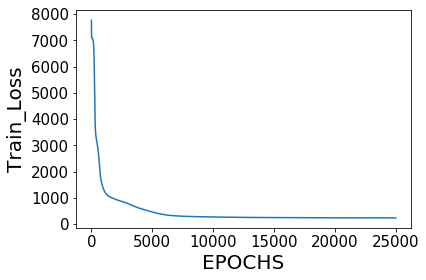

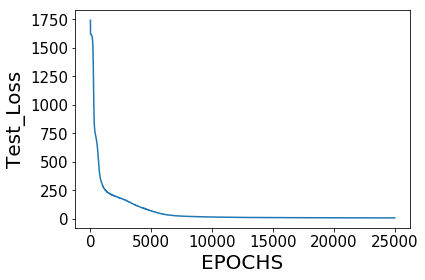

In [18]:
plt.figure()

#plt.subplot(121)
plt.plot()
plt.plot(loss_plot[:, 0], loss_plot[:, 1], '-')
plt.xlabel('EPOCHS', fontsize = 20)
plt.ylabel('Train_Loss', fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

plt.plot()
#plt.subplot(122)
plt.plot(loss_plot[:, 0], loss_plot[:, 2], '-')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('EPOCHS', fontsize = 20)
plt.ylabel('Test_Loss', fontsize = 20)
plt.show()

# Plot Loss and Accuracy

In [19]:
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, labels in test_loader: 
        inputs = Variable(inputs.float()).to(DEVICE)
        labels = Variable(labels.float()).to(DEVICE)
        outputs = model(inputs)
        #test_loss += F.mse_loss(outputs, labels, reduction='sum').item()
        #pred = torch.tensor([[1] if num[0] >= 0.5 else [0] for num in output]).to(device)
        #correct += (pred == target.long()).sum().item()
    #print('test_loss: {:.4f}'.format(test_loss))
    #print('inputs', inputs, '\nlabels', labels, '\noutputs', outputs)

labels = labels.cpu()
labels = labels.numpy()

outputs = outputs.cpu()
outputs = outputs.numpy()

np.set_printoptions(suppress=False) #Do not use Kexue Jishufa
print(labels, '\n\n', outputs)

[[-1.78874195  1.13666642 -0.65163434 -1.43855679]
 [-1.21269858  0.99669886 -0.39288512 -1.11090541]
 [ 0.60720319  0.13939756 -1.27424955  0.61108309]
 ..., 
 [ 1.10135806 -0.10554566 -0.33224079  1.1438185 ]
 [-1.33411944  0.84506732  2.29972363 -1.21043706]
 [ 0.23164551  0.48348448 -0.91038352  0.12029877]] 

 [[-1.83074951  1.05836737 -0.59700298 -1.43938601]
 [-1.25010729  1.03482425 -0.46875027 -1.13220251]
 [ 0.60655332  0.13761102 -1.26439512  0.58545089]
 ..., 
 [ 1.0795511  -0.10218541 -0.24189466  1.1105845 ]
 [-1.33584869  0.75481206  2.29611683 -1.17879772]
 [ 0.19433318  0.40658599 -0.8879388   0.09696417]]


In [20]:
labels = ss_y.inverse_transform(labels)
outputs = ss_y.inverse_transform(outputs)

labels[:,3] = np.power(10, -labels[:,3])
outputs[:,3] = np.power(10, -outputs[:,3])

print(labels, '\n\n' ,outputs)

[[ -6.56999946e-02   8.39999989e-02   6.60000005e-05   1.47000023e-07]
 [ -2.49000005e-02   8.16000029e-02   7.23999983e-05   6.19000247e-08]
 [  1.04000002e-01   6.69000000e-02   5.05999997e-05   6.56999344e-10]
 ..., 
 [  1.38999999e-01   6.27000034e-02   7.39000025e-05   1.61000130e-10]
 [ -3.34999971e-02   7.90000036e-02   1.38999996e-04   8.05000298e-08]
 [  7.73999989e-02   7.28000030e-02   5.95999991e-05   2.39999798e-09]] 

 [[ -6.86753094e-02   8.26574191e-02   6.73512695e-05   1.47322041e-07]
 [ -2.75495835e-02   8.22537318e-02   7.05235216e-05   6.54795755e-08]
 [  1.03953972e-01   6.68693632e-02   5.08437442e-05   7.02992220e-10]
 ..., 
 [  1.37455463e-01   6.27576187e-02   7.61346528e-05   1.75762599e-10]
 [ -3.36224772e-02   7.74524063e-02   1.38910793e-04   7.40498223e-08]
 [  7.47572407e-02   7.14814365e-02   6.01551546e-05   2.55248023e-09]]


In [21]:
np.savetxt('labels.csv', labels, delimiter=',')
np.savetxt('outputs.csv', outputs, delimiter=',')

In [22]:
R2_Vth = r2_score(labels[:,0], outputs[:,0])
R2_SS = r2_score(labels[:,1], outputs[:,1])
R2_Ion = r2_score(labels[:,2], outputs[:,2])
R2_Ioff = r2_score(labels[:,3], outputs[:,3])

print(R2_Vth, R2_SS, R2_Ion, R2_Ioff)

0.998618825055 0.985761033739 0.998122592698 0.990517388416


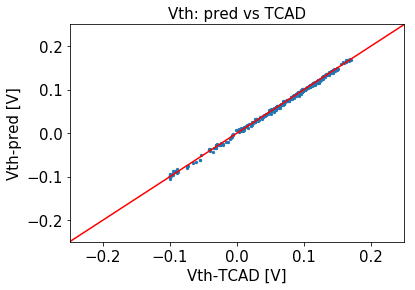

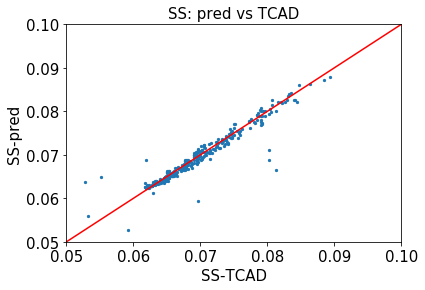

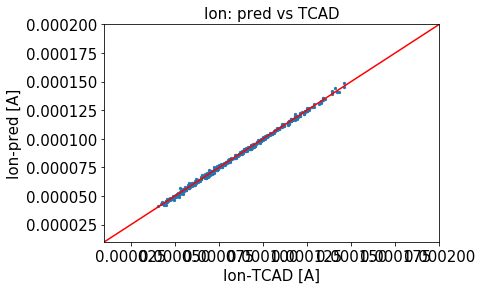

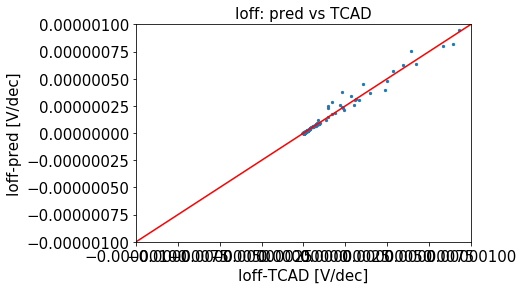

In [23]:
x = np.arange(-2, 2, 0.01)
y = x

plt.figure()
plt.title('Vth: pred vs TCAD', fontsize=15)
plt.scatter(labels[:,0], outputs[:,0], s=5)
plt.plot(x, y, color = 'r')
plt.xlabel('Vth-TCAD [V]', fontsize=15)
plt.ylabel('Vth-pred [V]', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.text(-0.2, 0.6, 'R2 = ', fontsize=15)
plt.axis([-0.25, 0.25, -0.25, 0.25])
plt.show()

plt.figure()
plt.title('SS: pred vs TCAD', fontsize=15)
plt.scatter(labels[:,1], outputs[:,1], s=5)
plt.plot(x, y, color = 'r')
plt.xlabel('SS-TCAD', fontsize=15)
plt.ylabel('SS-pred', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.text(-3e-3, 3e-3, 'R2 = ', fontsize=15)
plt.axis([0.05, 0.1, 0.05, 0.1])
plt.show()

plt.figure()
plt.title('Ion: pred vs TCAD', fontsize=15)
plt.scatter(labels[:,2], outputs[:,2], s=5)
plt.plot(x, y, color = 'r')
plt.xlabel('Ion-TCAD [A]', fontsize=15)
plt.ylabel('Ion-pred [A]', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.text(-0.75e-9, 0.0015, 'R2 = ', fontsize=15)
plt.axis([1e-5, 2e-4, 1e-5, 2e-4])
plt.show()

plt.figure()
#plt.subplot(224)
plt.title('Ioff: pred vs TCAD', fontsize=15)
plt.scatter(labels[:,3], outputs[:,3], s=5)
plt.plot(x, y, color = 'r')
plt.xlabel('Ioff-TCAD [V/dec]', fontsize=15)
plt.ylabel('Ioff-pred [V/dec]', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.text(0.06, 0.18, 'R2 ', fontsize=15)
plt.axis([-1e-6, 1e-6, -1e-6, 1e-6])
plt.show()

In [24]:
end = time.clock()
print('Running time is', end-start)

Running time is 35153.85


In [25]:
print(end)

35154.97
